In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [7]:
import numpy as np
import pandas as pd
import uncertainties as unc
from uncertainties import unumpy as unp
import matplotlib.pyplot as plt
import pymysql as Mdb
from datetime import datetime as dt
import math
import pickle
from copy import deepcopy
from scipy.optimize import curve_fit

from sys import path
path.append('../Evan_kEff_Module')
path.append('..')
path.append('../pylib')

from strfunct import R_ISO, F2_d_ratio
from keff import kEffCorrection
from productions import table_exists, schema_exists, roadset_dict
from targets import target_roadset_dict, purity, target_df, update_for_contam, calc_values
from dimuon import dimuon
from spill import spill
from roadsetcompare import plt_kin
from emc import plot_three_emc

pd.set_option("display.max_columns", 50)

In [5]:
target_roadset_dict[57]

,A,Density[g/cm^3],Layers,LengthPerLayer[cm],MassNo[g/mol],NIL[g/cm^2],TargPos,Z,Length[cm],NIL/D[cm],Density[/cm^3],Density[mol/cm^3],IntLengths,AttenFactor,AttenLength[cm],Scale
C,12.0,1.80200,3.0,1.10744,12.010700,85.800000,6.0,6.0,3.32232,47.613762,9.035192e+22,0.150033,0.069776,0.965909,3.209060,5.782726
Empty,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fe,56.0,7.87400,3.0,0.63500,55.845000,132.100000,5.0,26.0,1.90500,16.776734,8.491063e+22,0.140997,0.113550,0.945314,1.800824,14.179685
LD2,2.0,0.15451,1.0,50.80000,1.917509,95.643107,3.0,1.0,50.80000,619.007571,4.852565e+22,0.080579,0.082067,0.960066,48.771374,7.535684
LH2,1.0,0.07080,1.0,50.80000,1.007940,52.000000,1.0,1.0,50.80000,734.463277,4.230089e+22,0.070242,0.069166,0.966201,49.082993,3.475076
None,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W,184.0,19.30000,3.0,0.31750,183.840000,191.900000,7.0,74.0,0.95250,9.943005,6.322200e+22,0.104983,0.095796,0.953596,0.908300,17.530185


In [13]:
target_roadset_dict[57] - calc_values( update_for_contam(target_df.copy(), 57, bound='lower'))

,A,Density[g/cm^3],Layers,LengthPerLayer[cm],MassNo[g/mol],NIL[g/cm^2],TargPos,Z,Length[cm],NIL/D[cm],Density[/cm^3],Density[mol/cm^3],IntLengths,AttenFactor,AttenLength[cm],Scale
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Empty,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LD2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LH2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
None,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [521]:
class roadset(object):
    
    def __init__(self, rsn, server,
                 schema, dimuon_tbl, spill_tbl,
                 kin, fresh_start):
        self.roadset    = rsn
        self.runrange   = [roadset_dict[rsn]['lower'],
                           roadset_dict[rsn]['upper']]
        self.source     = ("merged_roadset%i_R005_V001" % rsn)
        self.server     = server
        self.schema     = schema
        self.port       = 3306
        if self.server == 'seaquel.physics.illinois.edu':
            self.port = 3283
        self.kin        = kin
        self.dimuon_tbl = dimuon_tbl
        self.spill_tbl  = spill_tbl
        
        # Get NIM3 trigger and chamber intensities, used for empty correction
        self.randoms_intensity = pd.DataFrame()
        #self.get_randoms_intensity()
        
        print ("\nRoadset %i" % (rsn))
        
        print (">> Compiling Signal Dimuons")
        self.dimuons    = dimuon(self.runrange, self.source, self.server, self.schema,
                                 self.dimuon_tbl, self.kin, fresh_start)
        print (">> Compiling Spill Data")
        self.spills     = spill(self.runrange, self.source, self.server, self.schema,
                                self.spill_tbl, fresh_start)
        
        self.group_cols = ['mass', 'dz', 'dpz', 'dpt', 'pz1', 'pz2',
                           'pt1', 'pt2', 'xF', 'xB', 'xT', 'costh',
                           'phi', 'trackSeparation', 'chisq_dimuon','QIESum', 
                           'chamber_intensity', 'trigger_intensity',
                           'weight_keff', 'weight_keff_sq',
                           'weight_bg', 'weight_bg_sq',
                           'weight', 'weight_sq']
        
        self.means      = pd.DataFrame()
        self.counts     = pd.DataFrame()
        self.emc_ratio  = pd.DataFrame()
        self.pre_contam_ld2 = None
        self.B = dict()
        
        return None
    
    
    def calculate_counts(self, kin):
        
        self.kin = deepcopy(kin)
        
        dimuons = self.dimuons.data.query('targetPos not in [2,4]').copy()
        # Check that all columns are present
        if not all(col in dimuons.columns for col in self.group_cols):
            print ("Not all of these columns are in the dimuon_df:")
            print self.group_cols
            print ("Please add them or alter this analysis code. Exiting...")
            return None
        
        # Group the dimuon data by target and kinematic bin
        binning = []
        binning.append(dimuons.target)
        for k in self.kin:
            binning.append(pd.cut(dimuons[k],
                                  self.kin[k]))
        print binning
        groups = dimuons.groupby(by=binning)
        
        # Calculate raw counts
        counts_df  = pd.DataFrame(groups.weight.count())
        
        # Calculate counts weighted by kefficiency factor
        w_keff_counts_df = pd.DataFrame(groups.weight_keff.sum())
        w_keff_counts_unc_df = pd.DataFrame(groups.weight_keff_sq.sum()).apply(unp.sqrt, axis=0)

        # Calculate counts weighted by background factor
        w_bg_counts_df = pd.DataFrame(groups.weight_bg.sum())
        w_bg_counts_unc_df = pd.DataFrame(groups.weight_bg_sq.sum()).apply(unp.sqrt, axis=0)

        # Calculate counts weighted by both keff and bg factors
        w_counts_df = pd.DataFrame(groups.weight.sum())
        w_counts_unc_df = pd.DataFrame(groups.weight_sq.sum()).apply(unp.sqrt, axis=0)
        
        # Calculate means of values
        means_df = groups[self.group_cols].mean()
        std_dev_df = groups[self.group_cols].std()
        means_df = pd.DataFrame(unp.uarray(means_df, std_dev_df),
                                columns=means_df.columns,
                                index=means_df.index)
        # Store raw counts 
        means_df['raw_counts'] = counts_df
        means_df['raw_counts'] = unp.uarray(means_df['raw_counts'],
                                            np.sqrt(means_df['raw_counts']))
        # Store weighted counts
        means_df['w_counts'] = unp.nominal_values(w_counts_df)
        means_df['w_unc'] = unp.nominal_values(w_counts_unc_df)
        means_df['w_counts'] = unp.uarray(means_df['w_counts'],
                                          means_df['w_unc'])
        means_df.drop('w_unc', axis=1, inplace=True)
        
        # Store keff weighted counts
        means_df['w_keff_counts'] = w_keff_counts_df
        means_df['w_keff_unc'] = w_keff_counts_unc_df
        means_df['w_keff_counts'] = unp.uarray(means_df['w_keff_counts'],
                                          means_df['w_keff_unc'])
        means_df.drop('w_keff_unc', axis=1, inplace=True)
        
        # Store keff weighted counts
        means_df['w_bg_counts'] = unp.nominal_values(w_bg_counts_df)
        means_df['w_bg_unc'] = unp.nominal_values(w_bg_counts_unc_df)
        means_df['w_bg_counts'] = unp.uarray(means_df['w_bg_counts'],
                                             means_df['w_bg_unc'])
        means_df.drop('w_bg_unc', axis=1, inplace=True)
        
        #means_df = means_df.applymap(self.fix_nan)
        
        self.means = means_df.copy()
        
        return None
    
    
    def normalize_to_livep(self):
        
        for counts in ['raw_counts','w_counts','w_keff_counts','w_bg_counts']:
            self.means[counts+'_pp'] = self.means[counts] / self.spills.live_p['liveProton_x10^16']
        
        return None
    
    
    def fix_nan(self, value):
        """Helper function to set unwanted NaN's to 0."""
        if np.isnan(unc.std_dev(value)):
            if np.isnan(unc.nominal_value(value)):
                return unc.ufloat(0.0, 0.0)
            else:
                return unc.ufloat(unc.nominal_value(value),0)
        else:
            return value
        
    
    def calc_bg_const(self, p1_e, p1_n):
        
        empty_sum = self.dimuons.data.query('targetPos==2').weight_keff.sum()
        empty_livep = self.spills.live_p.ix['Empty']['liveProton_x10^16']
        none_sum = self.dimuons.data.query('targetPos==4').weight_keff.sum()
        none_livep = self.spills.live_p.ix['None']['liveProton_x10^16']
        
        def bg_func(x, p1):
            return 1.0 + p1 * np.square(x)
        
        for targPos, target in zip([1,3], ['LH2', 'LD2']):
            livep_ratio = self.spills.live_p.ix[target]['liveProton_x10^16']/empty_livep
            targ_slice = self.dimuons.data.query('targetPos==@targPos').copy()
            targ_sum = np.multiply(
                    bg_func(targ_slice.chamber_intensity, p1_e),
                    targ_slice.weight_keff.values).values.sum()
            self.B[targPos] = (livep_ratio * empty_sum)/(targ_sum)
            
        for targPos, target in zip([5,6,7], ['Fe', 'C', 'W']):
            livep_ratio = self.spills.live_p.ix[target]['liveProton_x10^16']/none_livep
            targ_slice = self.dimuons.data.query('targetPos==@targPos').copy()
            targ_sum = np.sum((np.multiply(
                    bg_func(targ_slice.chamber_intensity, p1_n),
                    targ_slice.weight_keff.values)))
            self.B[targPos] = (livep_ratio * none_sum)/(targ_sum)
        
        return None
    
    
    def apply_bg_correction(self, p1_e, p1_n):
        
        self.dimuons.apply_bg_correction(self.B, p1_e, p1_n)
        self.group_cols += ['weight', 'weight_sq', 'weight_bg', 'weight_bg_sq']
        
        return None
        
        
    def calculate_ratios(self):
        
        target_df = target_roadset_dict[self.roadset].copy()

        ratio_list = []
        ratio_label_list = []
        if all(target in self.means.index for target in ('LH2', 'LD2')):
            ratio = np.divide(
                self.means.ix[['LD2']]['w_counts_pp'].values / target_df.ix['LD2'].Scale,
                self.means.ix[['LH2']]['w_counts_pp'].values / target_df.ix['LH2'].Scale)
            ratio_list.append(ratio)
            ratio_label_list.append('D/H')
        if all(target in self.means.index for target in ('C', 'LD2')):
            ratio = np.divide(
                self.means.ix[['C']]['w_counts_pp'].values / target_df.ix['C'].Scale,
                self.means.ix[['LD2']]['w_counts_pp'].values / target_df.ix['LD2'].Scale)
            ratio_list.append(ratio)
            ratio_label_list.append('C/D')
        if all(target in self.means.index for target in ('Fe', 'LD2')):
            ratio = np.divide(self.means.ix[['Fe']]['w_counts_pp'].values / target_df.ix['Fe'].Scale,
                              self.means.ix[['LD2']]['w_counts_pp'].values / target_df.ix['LD2'].Scale)
            ratio_list.append(ratio)
            ratio_label_list.append('Fe/D')
        if all(target in self.means.index for target in ('W', 'LD2')):
            ratio = np.divide(self.means.ix[['W']]['w_counts_pp'].values / target_df.ix['W'].Scale,
                              self.means.ix[['LD2']]['w_counts_pp'].values / target_df.ix['LD2'].Scale)
            ratio_list.append(ratio)
            ratio_label_list.append('W/D')
        if all(target in self.means.index for target in ('C', 'LD2')):
            ratio = np.divide(self.means.ix[['C']]['w_counts_pp'].values / target_df.ix['C'].Scale,
                              self.means.ix[['LH2']]['w_counts_pp'].values / target_df.ix['LH2'].Scale)
            ratio_list.append(ratio)
            ratio_label_list.append('C/H')
        if all(target in self.means.index for target in ('Fe', 'LH2')):
            ratio = np.divide(self.means.ix[['Fe']]['w_counts_pp'].values / target_df.ix['Fe'].Scale,
                              self.means.ix[['LH2']]['w_counts_pp'].values / target_df.ix['LH2'].Scale)
            ratio_list.append(ratio)
            ratio_label_list.append('Fe/H')
        if all(target in self.means.index for target in ('W', 'LH2')):
            ratio = np.divide(self.means.ix[['W']]['w_counts_pp'].values / target_df.ix['W'].Scale,
                              self.means.ix[['LH2']]['w_counts_pp'].values / target_df.ix['LH2'].Scale)
            ratio_list.append(ratio)
            ratio_label_list.append('W/H')
        if all(target in self.means.index for target in ('Fe', 'C')):
            ratio = np.divide(self.means.ix[['Fe']]['w_counts_pp'].values / target_df.ix['Fe'].Scale,
                              self.means.ix[['C']]['w_counts_pp'].values / target_df.ix['C'].Scale)
            ratio_list.append(ratio)
            ratio_label_list.append('Fe/C')
        if all(target in self.means.index for target in ('W', 'C')):
            ratio = np.divide(self.means.ix[['W']]['w_counts_pp'].values / target_df.ix['W'].Scale,
                              self.means.ix[['C']]['w_counts_pp'].values / target_df.ix['C'].Scale)
            ratio_list.append(ratio)
            ratio_label_list.append('W/C')

        bin_centers = self.means[self.kin.keys()[0]]['LD2'].values

        xranges = self.means.index.levels[1].values
        emc_df = pd.DataFrame([bin_centers] + ratio_list,
                              columns=xranges,
                              index=[self.kin.keys()[0]] + ratio_label_list).T
        self.emc_ratio = emc_df.copy()
        
        return None

    
    def contam_correct(self, bound='nominal'):
        
        p = purity[self.roadset][bound]
        d = self.means.ix[['LD2']]['w_counts_pp'].copy().values
        h = self.means.ix[['LH2']]['w_counts_pp'].copy().values

        new_d = d/p - h*((1.0-p)/p)
        
        self.pre_contam_ld2 = d
        
        _ = self.means.set_value(('LD2'), 'w_counts_pp', new_d)
        
        return None
    
    
    def apply_iso_correction(self):
        
        target_df = target_roadset_dict[self.roadset]
        W = target_df.ix['W']
        Fe = target_df.ix['Fe']
        
        cols = ['raw_counts', 'w_counts', 'w_keff_counts', 'w_bg_counts']
        
        for col in cols:
            xt = unp.nominal_values(self.means.ix['W'].xT.values)
            w_factor = R_ISO(xt, W['MassNo[g/mol]'], W.Z)[0]
            fe_factor = R_ISO(xt, Fe['MassNo[g/mol]'], Fe.Z)[0]
            self.means.loc['W'][col] = (self.means.loc['W'][col].values * w_factor)
            self.means.loc['Fe'][col] = (self.means.loc['Fe'][col].values * fe_factor)
        
        return None

In [524]:
class emc(object):
    
    def __init__(self,
                 server='e906-db3.fnal.gov',
                 schema='user_dannowitz_thesis',
                 dimuon_tbl='kDimuon_d',
                 spill_tbl='Spill_d',
                 roadsets=[57, 62, 67],
                 kin=['xT'],
                 kin_bins=[[0.1, 0.13, 0.16, 0.195,
                            0.24, 0.29, 0.35, 0.45, 0.58]],
                 fresh_start=False,
                 recalc_keff=False):
        
        #xF: [[-0.2913, 0.2831, 0.3544, 0.4073, 0.4573, 0.5083, 0.5646, 0.6407, 0.9899]]
        #xB: [[0.3045, 0.4892, 0.529, 0.5624, 0.5955, 0.6301, 0.6701, 0.7245, 0.9919]]
        #xT: [[0.0856, 0.1367, 0.1529, 0.1676, 0.1831, 0.2017, 0.2269, 0.2694, 0.6786]]
        #mass: [[4.2, 4.3274, 4.4677, 4.6218, 4.8012, 5.0171, 5.3114, 5.7649, 9.9422]]
        #dpt: [[0.0042, 0.3232, 0.4766, 0.6146, 0.7512, 0.9089, 1.1072, 1.4358, 3.8993]]
        #dpz: [[36.4265, 58.9458, 63.7682, 67.827, 71.8368, 76.033, 80.8751, 87.4742, 119.86]]
        
        self.kin        = dict(zip(kin, kin_bins))
        self.rsn        = roadsets
        self.server     = server
        self.port       = 3306
        if self.server == 'seaquel.physics.illinois.edu':
            self.port = 3283
        self.schema     = schema
        self.roadsets   = roadsets
        self.dimuon_tbl = dimuon_tbl
        self.spill_tbl  = spill_tbl
        self.keff = dict()
        self.emc_ratio  = pd.DataFrame()
        self.means      = pd.DataFrame()
        
        if not schema_exists(self.server, self.schema):
            print ("Creating analysis schema.")
            self.init_schema()
        if not fresh_start:
            if not table_exists(self.server, self.schema, self.dimuon_tbl):
                self.init_dimuon_table()
            if not table_exists(self.server, self.schema, self.spill_tbl):
                self.init_spill_table()

        if fresh_start:
            self.date_created = dt.now()
            self.drop_tables()
            print ("Creating analysis tables.")
            self.init_dimuon_table()
            self.init_spill_table()

        print ("\n--First Pass--")
                
        self.roadsets   = {i: roadset(i, server, schema, 
                                      dimuon_tbl, spill_tbl,
                                      self.kin, fresh_start)
                           for i in self.rsn}
        
        print ("\n--Second Pass--\n")
        
        if isinstance(kin_bins[0], int):
            _, kin_bins = pd.qcut(my_emc.get_all_dimuons()[kin], kin_bins[0], retbins=True)
            kin_bins = [round(i,4) for i in kin_bins]
            self.kin = dict(zip(kin, [list(kin_bins)]))
        
        if recalc_keff:
            print ("Calculating kEfficiency curve fits")
            self.calc_keff()
            #with open('keff67_%s.pkl' % self.kin.keys()[0],
            #          'wb', pickle.HIGHEST_PROTOCOL) as f:
            #    pickle.dump(self.keff, f)
        else:
            print ("Loading existing kEfficiency fits")
            with open('keff67_%s.pkl' % self.kin.keys()[0], 'rb') as f:
                self.keff = pickle.load(f)
                
        print ("Applying kEfficiency Correction")
        for rs in self.roadsets:
            self.roadsets[rs].dimuons.keff_dict = deepcopy(self.keff)
            self.roadsets[rs].dimuons.kin = deepcopy(self.kin)
            self.roadsets[rs].dimuons.apply_keff(self.kin, self.keff)
        
        print ("Calculating rate-dependent background curve fit parameters\n")
        _, self.p1_e, _, self.p1_n = self.calc_bg_curve()
        
        for rs in self.roadsets:
            print ("Processing Roadset %i..." % rs)
            print (">> Calculating Background Subtraction parameters")
            self.roadsets[rs].calc_bg_const(self.p1_e, self.p1_n)
            self.roadsets[rs].apply_bg_correction(self.p1_e, self.p1_n)
            print (">> Calculating weighted yields")
            self.roadsets[rs].calculate_counts(self.kin)
            print (">> Applying Isoscalar Corrections")
            self.roadsets[rs].apply_iso_correction()
            print (">> Normalizing to Live Proton count")
            self.roadsets[rs].normalize_to_livep()
            print (">> Applying LD2 Contamination Correction")
            self.roadsets[rs].contam_correct(bound='nominal')
            print (">> Calculating cross section ratios")
            self.roadsets[rs].calculate_ratios()
        
        print ("Combining ratios into one measurement.")
        self.emc_ratio = self.combine_ratios()
        print ("Combining kinematic means into one set of values.")
        self.means = self.combine_means()
        
        return None
    
    def init_schema(self):
        port = 3306
        if self.server == 'seaquel.physics.illinois.edu':
            port = 3283
        try:
            db = Mdb.connect(read_default_file='../.my.cnf',
                             read_default_group='guest',
                             host=self.server,
                             port=self.port)
            cur = db.cursor()

            cur.execute('CREATE DATABASE IF NOT EXISTS %s' % self.schema)

            if db:
                db.close()

        except Mdb.Error, e:

            print "Error %d: %s" % (e.args[0], e.args[1])
            return 1

        return 0
    
    def drop_tables(self):
        try:
            db = Mdb.connect(read_default_file='../.my.cnf',
                             read_default_group='guest',
                             db=self.schema,
                             host=self.server,
                             port=self.port)
            cur = db.cursor()

            query = "DROP TABLE IF EXISTS %s.%s"
            cur.execute(query % (self.schema, self.dimuon_tbl))
            cur.execute(query % (self.schema, self.spill_tbl))
            
            if db:
                db.close()

        except Mdb.Error, e:

            print "Error %d: %s" % (e.args[0], e.args[1])
            return 1

        return 0
    
    def init_dimuon_table(self):
        
        source = ('merged_roadset%i_R005_V001' % self.roadsets[0])
        try:
            db = Mdb.connect(read_default_file='../.my.cnf',
                             read_default_group='guest',
                             db=source,
                             host=self.server,
                             port=self.port)
            cur = db.cursor()

            query = ("CREATE TABLE %s.%s LIKE kDimuon" %
                     (self.schema, self.dimuon_tbl))
            cur.execute(query)
            query = ("""ALTER TABLE %s.%s 
                        ADD QIESum FLOAT DEFAULT NULL,
                        ADD chamber_intensity FLOAT DEFAULT NULL,
                        ADD trigger_intensity FLOAT DEFAULT NULL,
                        ADD weight FLOAT DEFAULT NULL
                     """ % (self.schema, self.dimuon_tbl))
            cur.execute(query)
            
            if db:
                db.close()

        except Mdb.Error, e:

            print "Error %d: %s" % (e.args[0], e.args[1])
            return 1

        return 0
    
    def init_spill_table(self):
        
        source = ('merged_roadset%i_R005_V001' % self.roadsets[0])
        try:
            db = Mdb.connect(read_default_file='../.my.cnf',
                             read_default_group='guest',
                             db=source,
                             host=self.server,
                             port=self.port)
            cur = db.cursor()

            query = ("CREATE TABLE %s.%s LIKE Spill" %
                     (self.schema, self.spill_tbl))
            cur.execute(query)
            
            if db:
                db.close()

        except Mdb.Error, e:

            print "Error %d: %s" % (e.args[0], e.args[1])
            return 1

        return 0
    
    
    def get_trigger_protons(self):
        """Get the number of trigger protons for each chamber_intensity bucket."""
        
        filename = "nim_trig_int.csv"
        
        trig_p = pd.read_csv(filename,
            header=None,
            names=['chamber_intensity', 'trigger_intensity'],
            index_col='chamber_intensity')
        
        return trig_p
    
    
    def get_bg(self):
        
        # Define intensity bins
        int_bins = [0,10000,20000,30000,40000,50000,60000]
        
        # Get all dimuons from all roadsets for bg targets
        empty_query = "targetPos==2 and chamber_intensity<60000"
        empty = self.get_all_dimuons(query=empty_query)
        none_query = "targetPos==4 and chamber_intensity<60000"
        none = self.get_all_dimuons(query=none_query)
        
        # Get sum of trigger protons binned (up to 60k) in chamber_intensity 
        trigger_p = self.get_trigger_protons().ix[:'(50000,60000]']
        
        # Group bg yields in chamber_intensity bins
        empty_grp = empty.groupby(by=pd.cut(empty.chamber_intensity, int_bins))
        none_grp = none.groupby(by=pd.cut(none.chamber_intensity, int_bins))
        
        # Calculate weighted sums and uncertainties
        empty_total = pd.DataFrame(empty_grp.weight_keff.sum())
        empty_total['stddev'] = np.sqrt(empty_grp.weight_keff_sq.sum())
        none_total = pd.DataFrame(none_grp.weight_keff.sum())
        none_total['stddev'] = np.sqrt(none_grp.weight_keff_sq.sum())
        
        # Calculate yields per trigger proton
        empty_total.weight_keff = empty_total.weight_keff/trigger_p.trigger_intensity
        none_total.weight_keff = none_total.weight_keff/trigger_p.trigger_intensity
        empty_total.stddev = empty_total.stddev/trigger_p.trigger_intensity
        none_total.stddev = none_total.stddev/trigger_p.trigger_intensity
    
        # Get x, y, yerr values for fitting
        x = [5000,15000,25000,35000,45000,55000]
        y_e = empty_total.weight_keff.values
        y_e_err = empty_total.stddev.values
        y_n = none_total.weight_keff.values
        y_n_err = none_total.stddev.values
        
        return (x, y_e, y_e_err, y_n, y_n_err)
        
    
    def calc_bg_curve(self):
        
        x, y_e, y_e_err, y_n, y_n_err = self.get_bg()
        
        # Define fit function
        def bg_funct(x, p0, p1):
            return p0*(1.0+p1*np.square(x))
            #return p0*(1.0 + p1 * x)
        
        # Give it a best guess to start at
        p0 = [5.0e-9, 6.0e-5]
        
        # Fit the background curve
        popt_e, pcov_e = curve_fit(bg_funct, x, y_e, p0=p0, sigma=y_e_err)
        popt_n, pcov_n = curve_fit(bg_funct, x, y_n, p0=p0, sigma=y_n_err)
        
        p0_e = popt_e[0]
        p0_e_err = pcov_e[0,0]**0.5
        p0_n = popt_n[0]
        p0_n_err = pcov_n[0,0]**0.5
        p1_e = popt_e[1]
        p1_e_err = pcov_e[1,1]**0.5
        p1_n = popt_n[1]
        p1_n_err = pcov_n[1,1]**0.5
        
        p0_e = unc.ufloat(p0_e, p0_e_err)
        p0_n = unc.ufloat(p0_n, p0_n_err)
        p1_e = unc.ufloat(p1_e, p1_e_err)
        p1_n = unc.ufloat(p1_n, p1_n_err)
        
        return p0_e, p1_e, p0_n, p1_n
    
    
    def get_all_livep(self):
        """
        Get a DataFrame of all dimuons from all roadsets.
        Optionally takes a query for selection purposes.
        """
        livep_df = None
        for rsn in self.rsn:
            if livep_df is None:
                livep_df = self.roadsets[rsn].spills.live_p.copy()
            else:
                livep_df += self.roadsets[rsn].spills.live_p
        
        return livep_df
    
    
    def get_all_dimuons(self, query=None):
        """
        Get a DataFrame of all dimuons from all roadsets.
        Optionally takes a query for selection purposes.
        """
        dimuon_list = []
        for rsn in self.rsn:
            if query:
                dimuon_list.append(self.roadsets[rsn].dimuons.data.query(query).copy())
            else:
                dimuon_list.append(self.roadsets[rsn].dimuons.data.copy())
                
        full_set = pd.concat(dimuon_list)
        
        return full_set
    
    
    def calc_keff(self):
        
        target_df = target_roadset_dict['all'].copy()
        
        for i in [1,3,5,6,7]:
            self.keff[i] = kEffCorrection(67, i, kin=self.kin.keys(), kin_bins=self.kin.values())
            
        XD = 1.0 - np.exp(-target_df.ix['LD2']['IntLengths'])
        XH = 1.0 - np.exp(-target_df.ix['LH2']['IntLengths'])
        self.keff[2] = deepcopy(self.keff[3])
        self.keff[2].exp_df.p0 = (self.keff[1].exp_df.p0 - 
                                  (XH*(self.keff[3].exp_df.p0-self.keff[1].exp_df.p0)/(XD-XH)))
        self.keff[4] = deepcopy(self.keff[2])

        return None
    
    
    def combine_ratios(self):

        if len(self.roadsets) < 2:
            return None

        nominal = []
        inv_sq_sig = []
        ratio_list = [self.roadsets[rs].emc_ratio.copy() for rs in self.roadsets]
        for ratio in ratio_list:
            tmp_nominal = ratio.applymap(unp.nominal_values)
            nominal.append(tmp_nominal)

            tmp_sig = ratio.applymap(unp.std_devs)
            tmp_inv_sq_sig = 1.0/np.square(tmp_sig)
            inv_sq_sig.append(tmp_inv_sq_sig)

        numerator = 0.0
        denominator = 0.0
        for i in range(0, len(ratio_list)):
            numerator += inv_sq_sig[i] * nominal[i]
            denominator += inv_sq_sig[i]

        combined_ratio_nom = np.divide(numerator, denominator)
        combined_ratio_sig = np.divide(1.0,np.sqrt(denominator))

        combined_ratio = pd.DataFrame(unp.uarray(combined_ratio_nom,
                                                std_devs=combined_ratio_sig),
                                      columns=combined_ratio_nom.columns,
                                      index=combined_ratio_nom.index)

        if self.kin.keys()[0] not in combined_ratio.columns:
            combined_ratio.insert(0, self.kin.keys()[0], emc_df_list[0][self.kin.keys()[0]])

        return combined_ratio
    
    
    def combine_means(self):

        if len(self.roadsets) < 2:
            return None

        nominal = []
        inv_sq_sig = []
        columns = [u'mass', u'dz', u'dpz', u'dpt', u'pz1', u'pz2',
                   u'pt1', u'pt2', u'xF',  u'xB', u'xT', u'costh',
                   u'phi', u'trackSeparation', u'chisq_dimuon',
                   u'QIESum', u'chamber_intensity', u'trigger_intensity']
        means_list = [self.roadsets[rs].means[columns].copy() for rs in self.roadsets]
        for means in means_list:
            tmp_nominal = means.applymap(unp.nominal_values)
            nominal.append(tmp_nominal)

            tmp_sig = means.applymap(unp.std_devs)
            tmp_inv_sq_sig = 1.0/np.square(tmp_sig)
            inv_sq_sig.append(tmp_inv_sq_sig)

        numerator = 0.0
        denominator = 0.0
        for i in range(0, len(means_list)):
            numerator += inv_sq_sig[i] * nominal[i]
            denominator += inv_sq_sig[i]

        combined_means_nom = np.divide(numerator, denominator)
        combined_means_sig = np.divide(1.0,np.sqrt(denominator))

        combined_means = pd.DataFrame(unp.uarray(combined_means_nom,
                                                std_devs=combined_means_sig),
                                      columns=combined_means_nom.columns,
                                      index=combined_means_nom.index)

        if self.kin.keys()[0] not in combined_means.columns:
            combined_emc.insert(0, self.kin.keys()[0], emc_df_list[0][self.kin.keys()[0]])
            
        return combined_means

In [159]:
%%time
my_emc = emc(roadsets=[57, 62, 67], fresh_start=False)


--First Pass--

Roadset 57
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 10404
>> Compiling Spill Data
>> Getting Live Proton data.

Roadset 62
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 15089
>> Compiling Spill Data
>> Getting Live Proton data.

Roadset 67
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 37521
>> Compiling Spill Data
>> Getting Live Proton data.

--Second Pass--

Loading existing kEfficiency fits
Applying kEfficiency Correction
Calculating rate-dependent background curve fit parameters

Processing Roadset 57...
>> Calculating Background Subtraction parameters
>> Calculating weighted yields
>> Applying Isoscalar Corrections
>> Normalizing to Live Proton count
>> Applying LD2 Contamination Correction
>> Calculating cross section ratios
Processing Roadset 67...
>> Calculating Background Subtraction parameters
>> Calculating weighted yields
>> Applying Isoscalar

# Systematic Studies!!!

## 1. Contamination

In [548]:
import targets
reload(targets)

<module 'targets' from '../pylib/targets.pyc'>

In [545]:
from targets import target_roadset_dict, update_for_contam

In [546]:
targets.target_roadset_dict[57]

,A,Density[g/cm^3],Layers,LengthPerLayer[cm],MassNo[g/mol],NIL[g/cm^2],TargPos,Z,Length[cm],NIL/D[cm],Density[/cm^3],Density[mol/cm^3],IntLengths,AttenFactor,AttenLength[cm],Scale
C,12.0,1.80200,3.0,1.10744,12.010700,85.800000,6.0,6.0,3.32232,47.613762,9.035192e+22,0.150033,0.069776,0.965909,3.209060,5.782726
Empty,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fe,56.0,7.87400,3.0,0.63500,55.845000,132.100000,5.0,26.0,1.90500,16.776734,8.491063e+22,0.140997,0.113550,0.945314,1.800824,14.179685
LD2,2.0,0.15451,1.0,50.80000,1.917509,95.643107,3.0,1.0,50.80000,619.007571,4.852565e+22,0.080579,0.082067,0.960066,48.771374,7.535684
LH2,1.0,0.07080,1.0,50.80000,1.007940,52.000000,1.0,1.0,50.80000,734.463277,4.230089e+22,0.070242,0.069166,0.966201,49.082993,3.475076
None,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W,184.0,19.30000,3.0,0.31750,183.840000,191.900000,7.0,74.0,0.95250,9.943005,6.322200e+22,0.104983,0.095796,0.953596,0.908300,17.530185


In [ ]:
%%time
low_contam_emc = emc(roadsets=[57, 62, 67], fresh_start=False, recalc_keff=True)

# Hi-Lo PT and X1 vs X2 studies

In [501]:
low_pt_xt_emc = emc(roadsets=[57, 62, 67], fresh_start=False, recalc_keff=True, kin=['xT'], kin_bins=[4])


--First Pass--

Roadset 57
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 3806
>> Compiling Spill Data
>> Getting Live Proton data.

Roadset 62
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 5486
>> Compiling Spill Data
>> Getting Live Proton data.

Roadset 67
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 13527
>> Compiling Spill Data
>> Getting Live Proton data.

--Second Pass--

Calculating kEfficiency curve fits
WHERE chamber_intensity >= 0 AND chamber_intensity < 100000 AND mass > 4.200000 AND mass < 10.000000 HAVING xT >= 0.100000 AND xT < 0.579600 AND dpt < 0.6
WHERE chamber_intensity >= 0 AND chamber_intensity < 100000 AND mass > 4.200000 AND mass < 10.000000 HAVING xT >= 0.100000 AND xT < 0.579600 AND dpt < 0.6
WHERE chamber_intensity >= 0 AND chamber_intensity < 100000 AND mass > 4.200000 AND mass < 10.000000 HAVING xT >= 0.100000 AND xT < 0.579600 AND dpt < 0.6
WHERE 

In [502]:
hi_pt_xt_emc = emc(roadsets=[57, 62, 67], fresh_start=False, recalc_keff=True, kin=['xT'], kin_bins=[4])


--First Pass--

Roadset 57
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 6622
>> Compiling Spill Data
>> Getting Live Proton data.

Roadset 62
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 9646
>> Compiling Spill Data
>> Getting Live Proton data.

Roadset 67
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 24074
>> Compiling Spill Data
>> Getting Live Proton data.

--Second Pass--

Calculating kEfficiency curve fits
WHERE chamber_intensity >= 0 AND chamber_intensity < 100000 AND mass > 4.200000 AND mass < 10.000000 HAVING xT >= 0.100000 AND xT < 0.579600 AND dpt > 0.6
WHERE chamber_intensity >= 0 AND chamber_intensity < 100000 AND mass > 4.200000 AND mass < 10.000000 HAVING xT >= 0.100000 AND xT < 0.579600 AND dpt > 0.6
WHERE chamber_intensity >= 0 AND chamber_intensity < 100000 AND mass > 4.200000 AND mass < 10.000000 HAVING xT >= 0.100000 AND xT < 0.579600 AND dpt > 0.6
WHERE 

In [512]:
low_xb_xt_emc = emc(roadsets=[57, 62, 67], fresh_start=False, recalc_keff=True, kin=['xT'], kin_bins=[4])


--First Pass--

Roadset 57
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 3659
>> Compiling Spill Data
>> Getting Live Proton data.

Roadset 62
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 5507
>> Compiling Spill Data
>> Getting Live Proton data.

Roadset 67
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 13931
>> Compiling Spill Data
>> Getting Live Proton data.

--Second Pass--

Calculating kEfficiency curve fits


//anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Applying kEfficiency Correction
Calculating rate-dependent background curve fit parameters

Processing Roadset 57...
>> Calculating Background Subtraction parameters
>> Calculating weighted yields
>> Applying Isoscalar Corrections
>> Normalizing to Live Proton count
>> Applying LD2 Contamination Correction
>> Calculating cross section ratios
Processing Roadset 67...
>> Calculating Background Subtraction parameters
>> Calculating weighted yields
>> Applying Isoscalar Corrections
>> Normalizing to Live Proton count
>> Applying LD2 Contamination Correction
>> Calculating cross section ratios
Processing Roadset 62...
>> Calculating Background Subtraction parameters
>> Calculating weighted yields
>> Applying Isoscalar Corrections
>> Normalizing to Live Proton count
>> Applying LD2 Contamination Correction
>> Calculating cross section ratios
Combining ratios into one measurement.
Combining kinematic means into one set of values.


In [525]:
hi_xb_xt_emc = emc(roadsets=[57, 62, 67], fresh_start=False, recalc_keff=True, kin=['xT'], kin_bins=[4])


--First Pass--

Roadset 57
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 6769
>> Compiling Spill Data
>> Getting Live Proton data.

Roadset 62
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 9625
>> Compiling Spill Data
>> Getting Live Proton data.

Roadset 67
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 23670
>> Compiling Spill Data
>> Getting Live Proton data.

--Second Pass--

Calculating kEfficiency curve fits
Applying kEfficiency Correction
Calculating rate-dependent background curve fit parameters

Processing Roadset 57...
>> Calculating Background Subtraction parameters
>> Calculating weighted yields
[11      LH2
22      LH2
28      LH2
30      LH2
32      LH2
33      LH2
34      LH2
35      LH2
41      LH2
44      LH2
49      LH2
50      LH2
54      LH2
67      LH2
71      LH2
72      LH2
79      LH2
91      LH2
103     LH2
110     LH2
111     LH2
112     LH2
118     L

# Plot the EMC Ratios

In [515]:
low_xb_xt_emc.emc_ratio.xT

(0.1, 0.153]      0.1491+/-0.0015
(0.153, 0.183]      0.170+/-0.005
(0.183, 0.227]      0.204+/-0.007
(0.227, 0.58]       0.290+/-0.033
Name: xT, dtype: object

In [514]:
hi_xb_xt_emc.emc_ratio.xT

(0.1, 0.153]      0.134+/-0.007
(0.153, 0.183]    0.167+/-0.005
(0.183, 0.227]    0.202+/-0.007
(0.227, 0.58]     0.280+/-0.029
Name: xT, dtype: object

In [510]:
binning = {'xF': [-0.2913, 0.2831, 0.3544, 0.4073, 0.4573, 0.5083, 0.5646, 0.6407, 0.9899],
           'xB': [0.3045, 0.4892, 0.529, 0.5624, 0.5955, 0.6301, 0.6701, 0.7245, 0.9919],
           'xT': [0.1, 0.13, 0.16, 0.195, 0.24, 0.29, 0.35, 0.45, 0.58],
           'mass': [4.2, 4.3274, 4.4677, 4.6218, 4.8012, 5.0171, 5.3114, 5.7649, 9.9422],
           'dpt': [0.0042, 0.3232, 0.4766, 0.6146, 0.7512, 0.9089, 1.1072, 1.4358, 3.8993],
           'dpz': [36.4265, 58.9458, 63.7682, 67.827, 71.8368, 76.033, 80.8751, 87.4742, 119.86],
           'costh': [-0.841, -0.3058, -0.1816, -0.0892, -0.006, 0.0773, 0.1715, 0.3012, 0.8177],
           'lowpt-xT': [0.1, 0.1531, 0.1833, 0.227, 0.5796],
           'hipt-xT': [0.1, 0.1531, 0.1833, 0.227, 0.5796]}

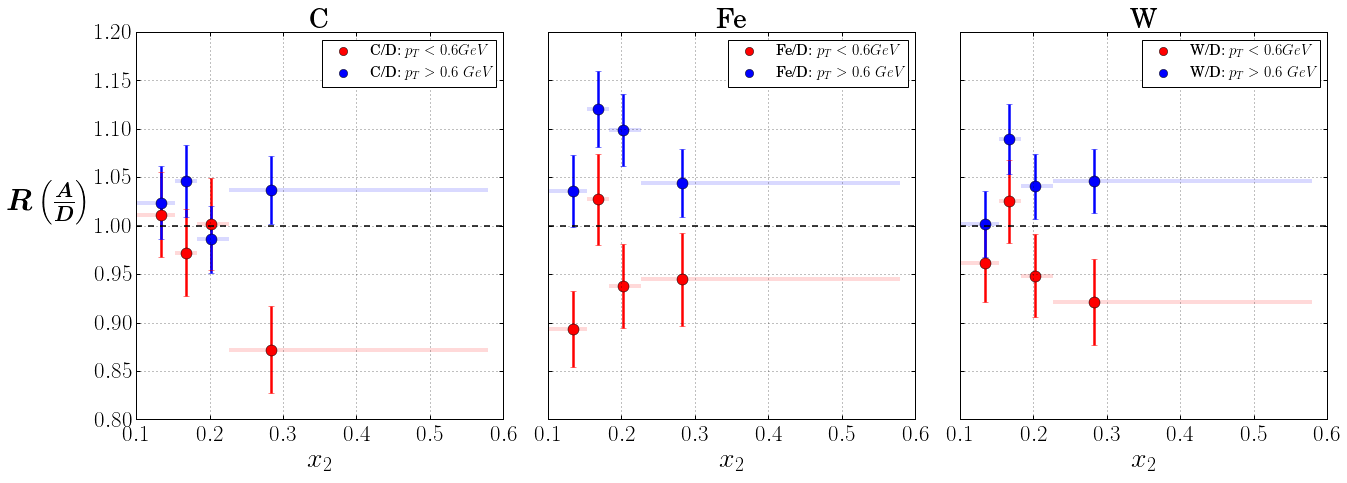

In [534]:
plot_three_emc(unp.nominal_values(low_pt_xt_emc.emc_ratio['xT'].values),
               'xT',
               binning['lowpt-xT'],
               [low_pt_xt_emc.emc_ratio['C/D'],
                hi_pt_xt_emc.emc_ratio['C/D']],
               [r'C/D: $p_T<0.6 GeV$', r'C/D: $p_T>0.6\ GeV$'],
               [low_pt_xt_emc.emc_ratio['Fe/D'],
                hi_pt_xt_emc.emc_ratio['Fe/D']],
               [r'Fe/D: $p_T<0.6 GeV$', r'Fe/D: $p_T>0.6\ GeV$'],
               [low_pt_xt_emc.emc_ratio['W/D'],
                hi_pt_xt_emc.emc_ratio['W/D']],
               [r'W/D: $p_T<0.6 GeV$', r'W/D: $p_T>0.6\ GeV$'],
               savefile='figures/xT-emc-pT.png')

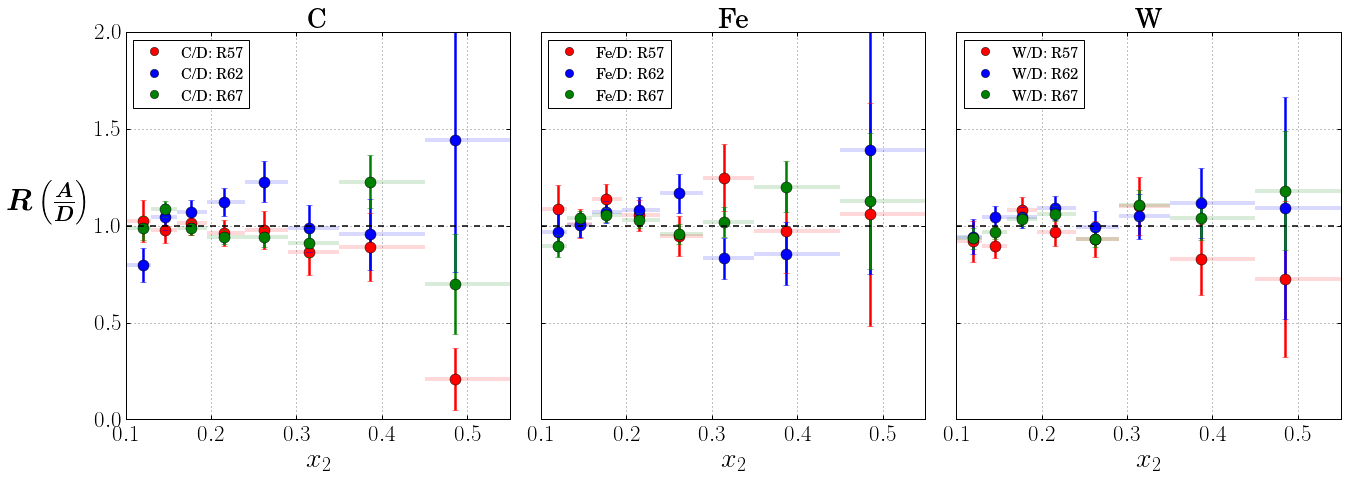

In [469]:
plot_three_emc(unp.nominal_values(my_emc.emc_ratio['xT'].values),
               'xT',
               binning['xT'],
               [my_emc.roadsets[57].emc_ratio['C/D'],
                my_emc.roadsets[62].emc_ratio['C/D'],
                my_emc.roadsets[67].emc_ratio['C/D']],
               ['C/D: R57', 'C/D: R62', 'C/D: R67'],
               [my_emc.roadsets[57].emc_ratio['Fe/D'],
                my_emc.roadsets[62].emc_ratio['Fe/D'],
                my_emc.roadsets[67].emc_ratio['Fe/D']],
               ['Fe/D: R57', 'Fe/D: R62', 'Fe/D: R67'],
               [my_emc.roadsets[57].emc_ratio['W/D'],
                my_emc.roadsets[62].emc_ratio['W/D'],
                my_emc.roadsets[67].emc_ratio['W/D']],
               ['W/D: R57', 'W/D: R62', 'W/D: R67'],
               savefile='figures/xT-emc-roadset.png',
               lims=(0.1,0.55, 0, 2))

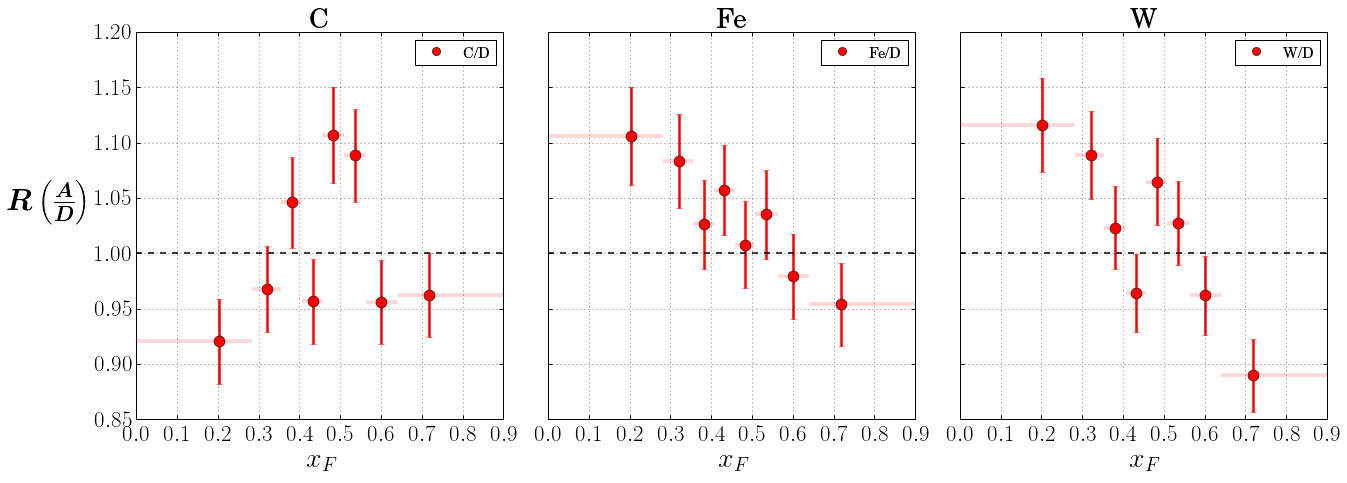

In [526]:
plot_three_emc(unp.nominal_values(xf_emc.emc_ratio['xF'].values),
               'xF',
               binning['xF'],
               [xf_emc.emc_ratio['C/D']], ['C/D'],
               [xf_emc.emc_ratio['Fe/D']], ['Fe/D'],
               [xf_emc.emc_ratio['W/D']], ['W/D'],
               xlabel=r'$x_F$',
               savefile='figures/xF_emc.png',
               lims=(0.0,0.9, 0.85, 1.2))

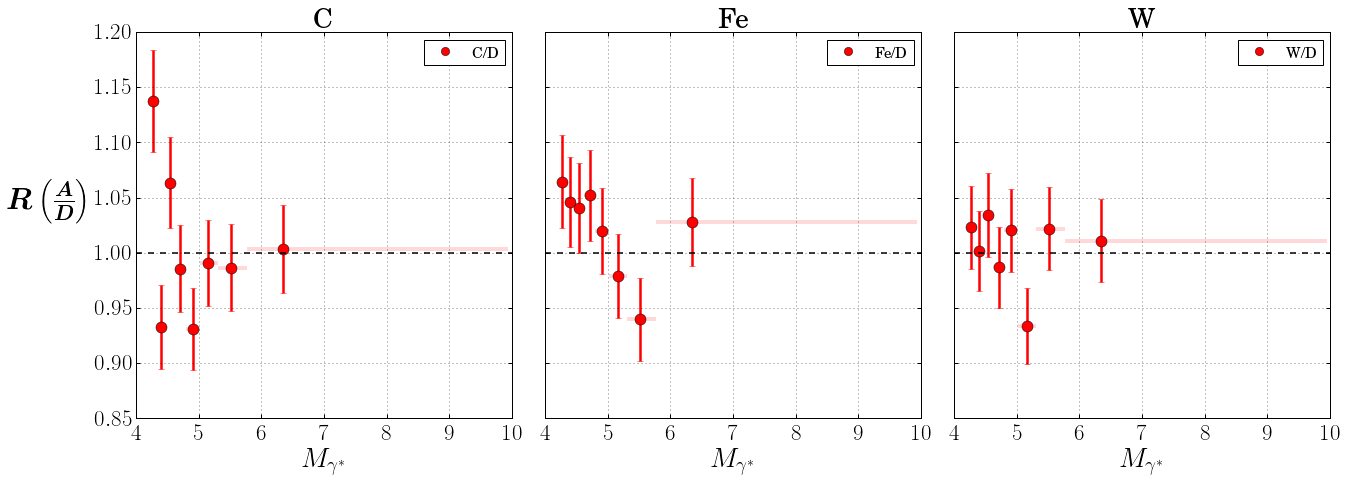

In [454]:
plot_three_emc(unp.nominal_values(mass_emc.emc_ratio['mass'].values),
               'mass',
               binning['mass'],
               [mass_emc.emc_ratio['C/D']], ['C/D'],
               [mass_emc.emc_ratio['Fe/D']], ['Fe/D'],
               [mass_emc.emc_ratio['W/D']], ['W/D'],
               xlabel=r'$M_{\gamma^*}$',
               savefile='mass_emc.png')

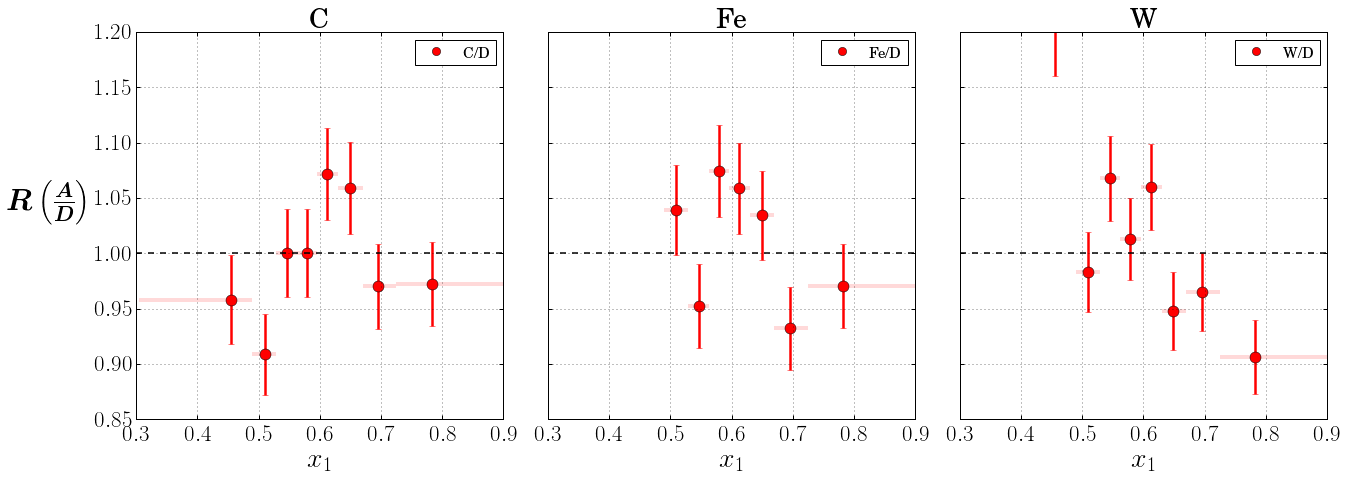

In [527]:
plot_three_emc(unp.nominal_values(xb_emc.emc_ratio['xB'].values),
               'xB',
               binning['xB'],
               [xb_emc.emc_ratio['C/D']], ['C/D'],
               [xb_emc.emc_ratio['Fe/D']], ['Fe/D'],
               [xb_emc.emc_ratio['W/D']], ['W/D'],
               xlabel=r'$x_1$',
               savefile='figures/xB_emc.png',
               lims=(0.3, 0.9, 0.85, 1.20))

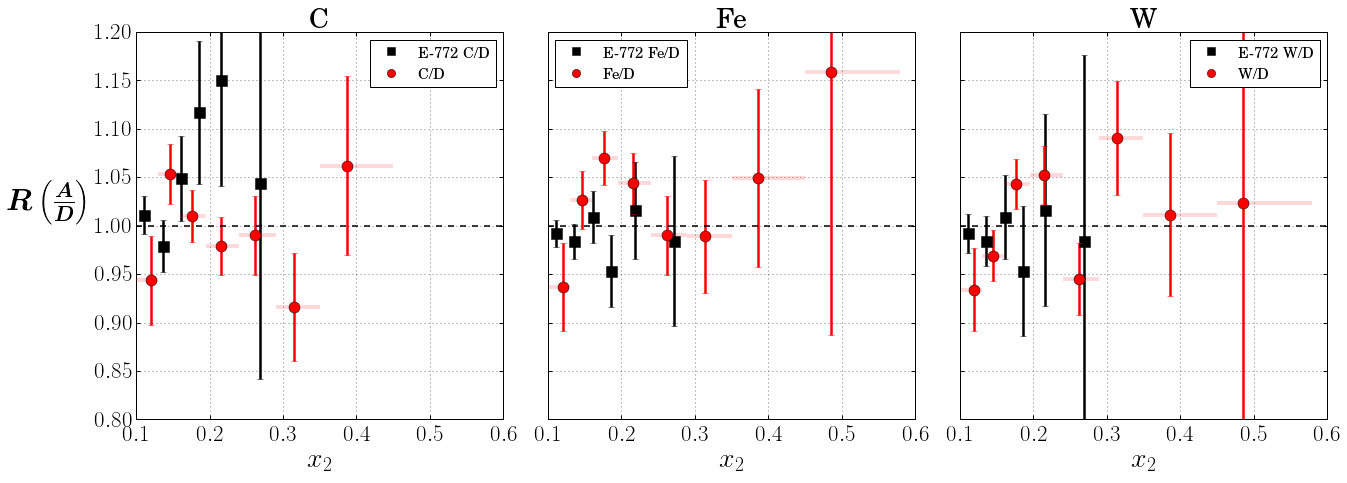

In [537]:
plot_three_emc(unp.nominal_values(my_emc.emc_ratio['xT'].values),
               'xT',
               binning['xT'],
               [my_emc.emc_ratio['C/D']], ['C/D'],
               [my_emc.emc_ratio['Fe/D']], ['Fe/D'],
               [my_emc.emc_ratio['W/D']], ['W/D'],
               xlabel=r'$x_2$',
               savefile='figures/xt-emc-zoom.png',
               lims=(0.1, 0.6, 0.8, 1.20))

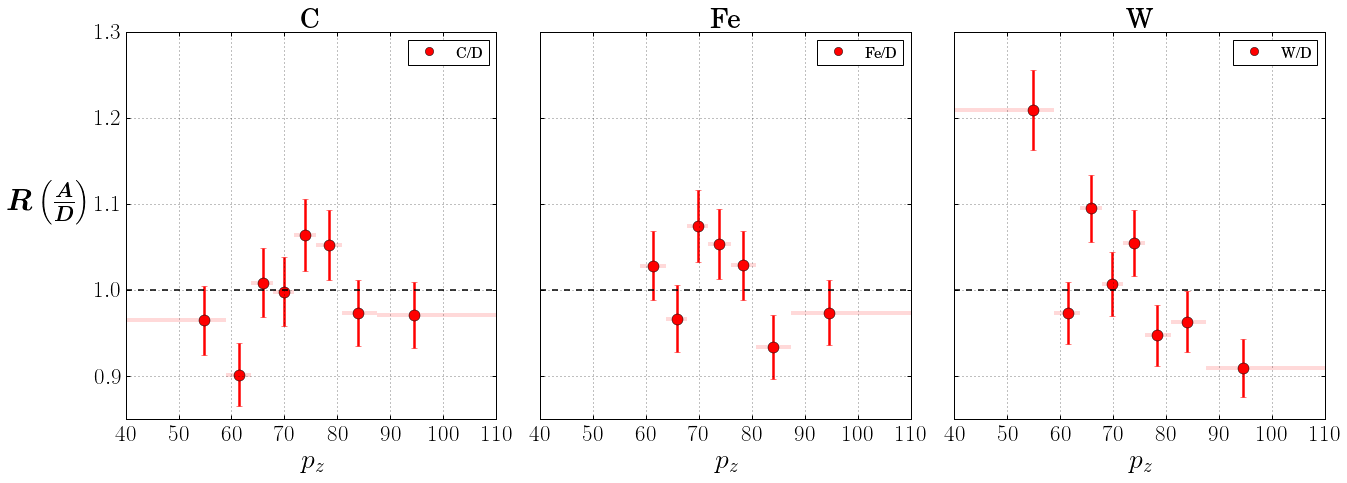

In [532]:
plot_three_emc(unp.nominal_values(pz_emc.emc_ratio['dpz'].values),
               'dpz',
               binning['dpz'],
               [pz_emc.emc_ratio['C/D']], ['C/D'],
               [pz_emc.emc_ratio['Fe/D']], ['Fe/D'],
               [pz_emc.emc_ratio['W/D']], ['W/D'],
               xlabel=r'$p_z$',
               savefile='figures/pz_emc.png',
               lims=(40,110, 0.85, 1.3))

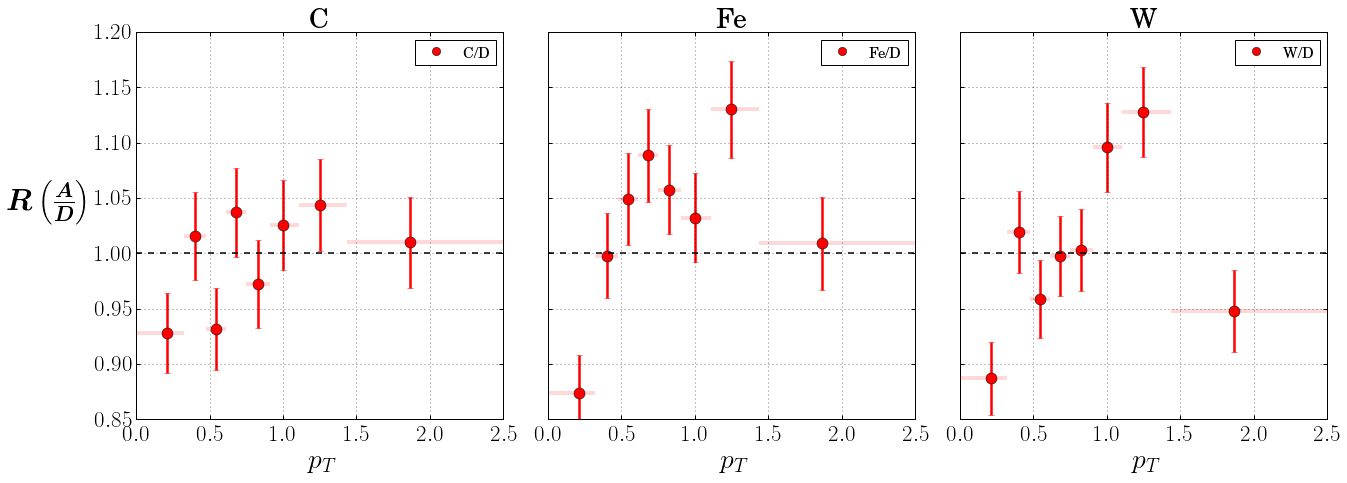

In [529]:
plot_three_emc(unp.nominal_values(pt_emc.emc_ratio['dpt'].values),
               'dpt',
               binning['dpt'],
               [pt_emc.emc_ratio['C/D']], ['C/D'],
               [pt_emc.emc_ratio['Fe/D']], ['Fe/D'],
               [pt_emc.emc_ratio['W/D']], ['W/D'],
               xlabel=r'$p_T$',
               savefile='figures/pT_emc.png',
               lims=(0.0,2.5, 0.85, 1.2))

TypeError: 'NoneType' object has no attribute '__getitem__'

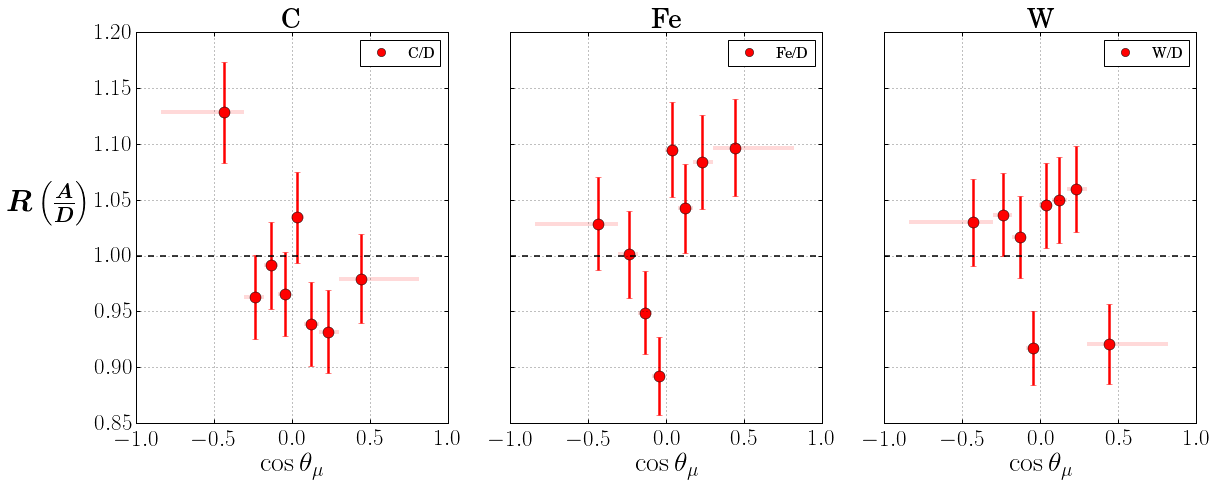

In [530]:
plot_three_emc(unp.nominal_values(costh_emc.emc_ratio['costh'].values),
               'costh',
               binning['costh'],
               [costh_emc.emc_ratio['C/D']], ['C/D'],
               [costh_emc.emc_ratio['Fe/D']], ['Fe/D'],
               [costh_emc.emc_ratio['W/D']], ['W/D'],
               xlabel=r'$\cos\theta_\mu$',
               savefile='figures/costh_emc.png')
               #lims=(0.0,2.5, 0.85, 1.2))

In [473]:
ld2_total = (my_emc.roadsets[57].means.w_counts_pp.ix['LD2'].sum() +
             my_emc.roadsets[62].means.w_counts_pp.ix['LD2'].sum() +
             my_emc.roadsets[67].means.w_counts_pp.ix['LD2'].sum())
c_total = (my_emc.roadsets[57].means.w_counts_pp.ix['C'].sum() +
           my_emc.roadsets[62].means.w_counts_pp.ix['C'].sum() +
           my_emc.roadsets[67].means.w_counts_pp.ix['C'].sum())
fe_total = (my_emc.roadsets[57].means.w_counts_pp.ix['Fe'].sum() +
            my_emc.roadsets[62].means.w_counts_pp.ix['Fe'].sum() +
            my_emc.roadsets[67].means.w_counts_pp.ix['Fe'].sum())
w_total = (my_emc.roadsets[57].means.w_counts_pp.ix['W'].sum() +
           my_emc.roadsets[62].means.w_counts_pp.ix['W'].sum() +
           my_emc.roadsets[67].means.w_counts_pp.ix['W'].sum())

In [478]:
print "C", (c_total/(target_roadset_dict['all'].ix['C'].Scale))/(ld2_total/(target_roadset_dict['all'].ix['LD2'].Scale))
print "Fe", R_ISO(0.2, 56, 26)[0]*(fe_total/(target_roadset_dict['all'].ix['Fe'].Scale))/(ld2_total/(target_roadset_dict['all'].ix['LD2'].Scale))
print "W", R_ISO(0.2, 184, 74)[0]*(w_total/(target_roadset_dict['all'].ix['W'].Scale))/(ld2_total/(target_roadset_dict['all'].ix['LD2'].Scale))

 C 1.023+/-0.016
Fe [1.0633971316670034+/-0.017436765269293]
W [1.050968766983075+/-0.016215724750434406]


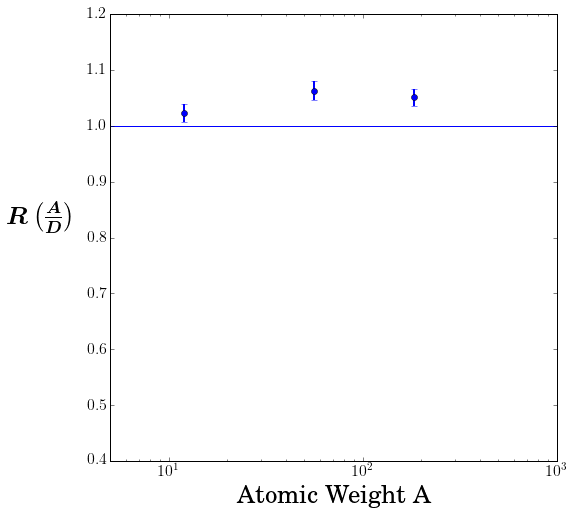

In [492]:
x = [12.01, 55.85, 183.85]
y = [1.023, 1.063397, 1.0509688]
yerr = [0.016, 0.017, 0.016]
f, ax = plt.subplots(1, figsize=(8,8))
ax.errorbar(x, y, yerr, fmt='o', lw=2)
ax.set_xscale("log", nonposx='clip')
ax.axhline(1, 0, 200)
ax.set_ylim([0.4, 1.2])
ax.set_xlim([5,1000])
ax.set_ylabel(r'$\boldsymbol{R \left(\frac{A}{D}\right)}$', rotation=0, labelpad=45, fontsize=25)
ax.set_xlabel('Atomic Weight A', fontsize=25)
plt.savefig('int-DY-A.png')

In [279]:
print my_emc.roadsets[67].means.ix['LD2'].w_counts_pp
print my_emc.roadsets[67].pre_contam_ld2

xT
(0.1, 0.13]        185+/-6
(0.13, 0.16]      502+/-10
(0.16, 0.195]     621+/-11
(0.195, 0.24]     493+/-10
(0.24, 0.29]       310+/-9
(0.29, 0.35]       152+/-6
(0.35, 0.45]        64+/-4
(0.45, 0.58]     9.6+/-1.5
Name: w_counts_pp, dtype: object
[179.61062086926285+/-5.711487160922537
 486.78735412629106+/-9.566987578491078
 601.9335707737029+/-10.662189085118552
 478.26594884657464+/-9.758733442609655
 299.6313682093245+/-8.195667368328596
 147.02335262716218+/-5.878993499909446
 62.066133989827684+/-3.7935523800988635
 9.370347348937726+/-1.4605659898435361]


In [280]:
print my_emc.roadsets[62].means[['raw_counts_pp', 'w_keff_counts_pp', 'w_counts_pp']].to_latex()

\begin{tabular}{lllll}
\toprule
  &             &      raw\_counts\_pp &   w\_keff\_counts\_pp &        w\_counts\_pp \\
target & xT &                    &                    &                    \\
\midrule
C & (0.1, 0.13] &           100+/-10 &           146+/-14 &           134+/-13 \\
  & (0.13, 0.16] &           322+/-17 &           511+/-28 &           470+/-26 \\
  & (0.16, 0.195] &           433+/-20 &           653+/-31 &           603+/-28 \\
  & (0.195, 0.24] &           345+/-18 &           539+/-29 &           497+/-26 \\
  & (0.24, 0.29] &           196+/-13 &           316+/-22 &           293+/-21 \\
  & (0.29, 0.35] &             92+/-9 &           159+/-17 &           147+/-15 \\
  & (0.35, 0.45] &             38+/-6 &            66+/-11 &            61+/-10 \\
  & (0.45, 0.58] &          7.4+/-2.6 &             11+/-4 &             11+/-4 \\
Fe & (0.1, 0.13] &           273+/-23 &           415+/-35 &           399+/-34 \\
  & (0.13, 0.16] &    (7.5+/-0.4)e+02 &  (1.

In [352]:
my_emc.means.to_csv('seaquest-mean-kin-bins-x2.tsv', sep='\t')

In [354]:
my_emc.means.ix['LD2'][['mass', 'dpt', 'xF', 'xB', 'xT']].to_csv('seaquest-mean-kin-bins-x2.tsv', sep='\t')

In [130]:
%%time
my_emc = emc(roadsets=[57, 62, 67], fresh_start=False, recalc_keff=True, kin=['xB'], kin_bins=[8])


--First Pass--

Roadset 57
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 10428
>> Compiling Spill Data
>> Getting Live Proton data.

Roadset 62
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 15132
>> Compiling Spill Data
>> Getting Live Proton data.

Roadset 67
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 37601
>> Compiling Spill Data
>> Getting Live Proton data.

--Second Pass--

Calculating kEfficiency curve fits
Applying kEfficiency Correction
Applying kEfficiency Correction
Applying kEfficiency Correction
Calculating rate-dependent background curve fit parameters

Processing Roadset 57...
>> Calculating Background Subtraction parameters
>> Calculating weighted yields
>> Applying Isoscalar Corrections
>> Normalizing to Live Proton count
>> Applying LD2 Contamination Correction
>> Calculating cross section ratios
Processing Roadset 67...
>> Calculating Background Subtractio

In [359]:
print my_emc.keff[3].exp_df.p0.values

[  1.39274366e-05   1.49934060e-05   1.58996220e-05   1.45190627e-05
   1.63328375e-05   1.69414207e-05   1.92143248e-05   2.24279820e-05]


# Compare Roadset Distributions!

In [ ]:
xf_emc = emc(roadsets=[57, 62, 67], fresh_start=False, recalc_keff=True, kin=['xF'], kin_bins=[8])
xt_emc = emc(roadsets=[57, 62, 67], fresh_start=False, recalc_keff=True, kin=['xT'], kin_bins=[8])
xb_emc = emc(roadsets=[57, 62, 67], fresh_start=False, recalc_keff=True, kin=['xB'], kin_bins=[8])
mass_emc = emc(roadsets=[57, 62, 67], fresh_start=False, recalc_keff=True, kin=['mass'], kin_bins=[8])

In [145]:
pt_emc = emc(roadsets=[57, 62, 67], fresh_start=False, recalc_keff=True, kin=['dpt'], kin_bins=[8])
pz_emc = emc(roadsets=[57, 62, 67], fresh_start=False, recalc_keff=True, kin=['dpz'], kin_bins=[8])


--First Pass--

Roadset 57
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 10428
>> Compiling Spill Data
>> Getting Live Proton data.

Roadset 62
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 15132
>> Compiling Spill Data
>> Getting Live Proton data.

Roadset 67
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 37601
>> Compiling Spill Data
>> Getting Live Proton data.

--Second Pass--

Calculating kEfficiency curve fits
Applying kEfficiency Correction
Calculating rate-dependent background curve fit parameters

Processing Roadset 57...
>> Calculating Background Subtraction parameters
>> Calculating weighted yields
>> Applying Isoscalar Corrections
>> Normalizing to Live Proton count
>> Applying LD2 Contamination Correction
>> Calculating cross section ratios
Processing Roadset 67...
>> Calculating Background Subtraction parameters
>> Calculating weighted yields
>> Applying Isoscala

ValueError: operands could not be broadcast together with shapes (295979,2) (295979,) (295979,2) 

In [289]:
costh_emc = emc(roadsets=[57, 62, 67], fresh_start=False, recalc_keff=True, kin=['costh'], kin_bins=[8])


--First Pass--

Roadset 57
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 10428
>> Compiling Spill Data
>> Getting Live Proton data.

Roadset 62
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 15132
>> Compiling Spill Data
>> Getting Live Proton data.

Roadset 67
>> Compiling Signal Dimuons
>> Fetching dimuon data from the database
>> #Dimuons: 37601
>> Compiling Spill Data
>> Getting Live Proton data.

--Second Pass--

Calculating kEfficiency curve fits
Applying kEfficiency Correction
Calculating rate-dependent background curve fit parameters

Processing Roadset 57...
>> Calculating Background Subtraction parameters
>> Calculating weighted yields
>> Applying Isoscalar Corrections
>> Normalizing to Live Proton count
>> Applying LD2 Contamination Correction
>> Calculating cross section ratios
Processing Roadset 67...
>> Calculating Background Subtraction parameters
>> Calculating weighted yields
>> Applying Isoscala

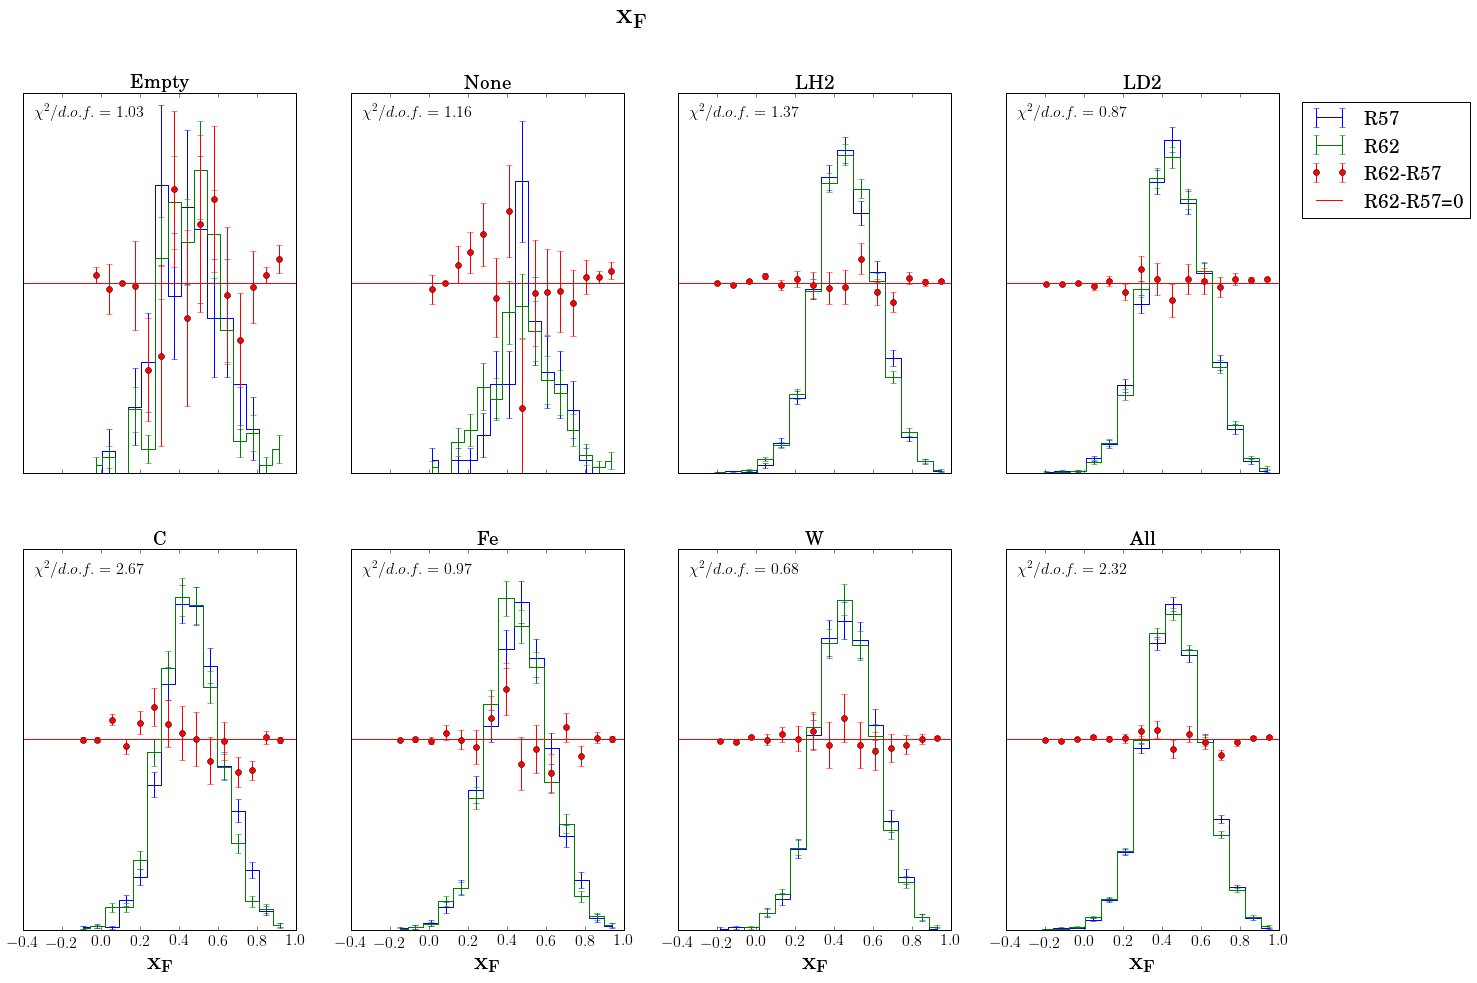

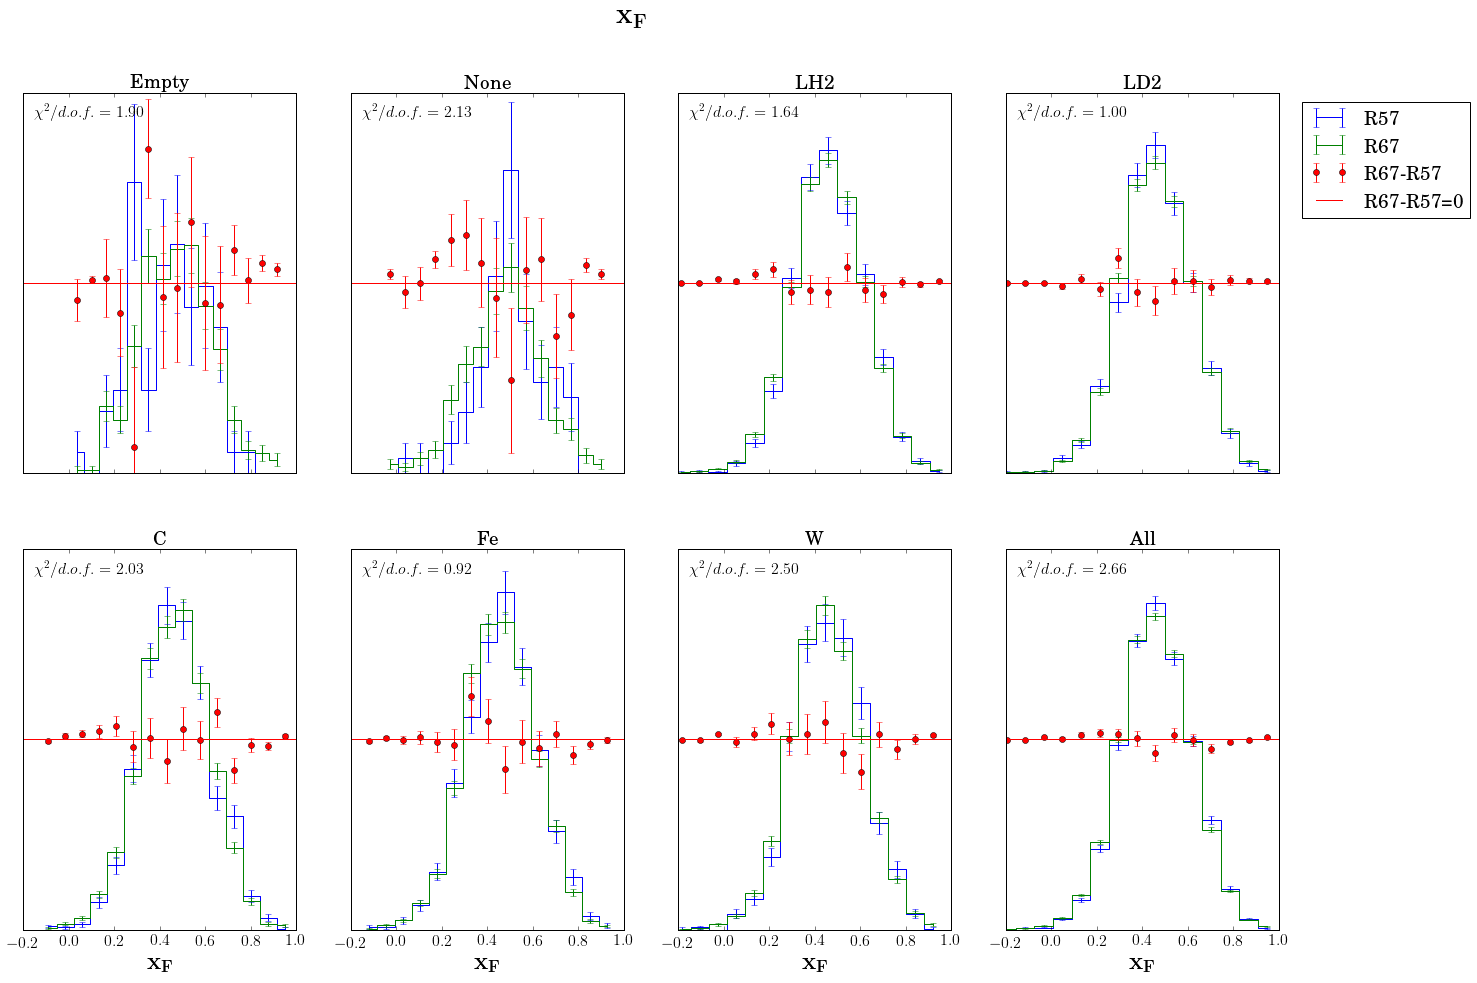

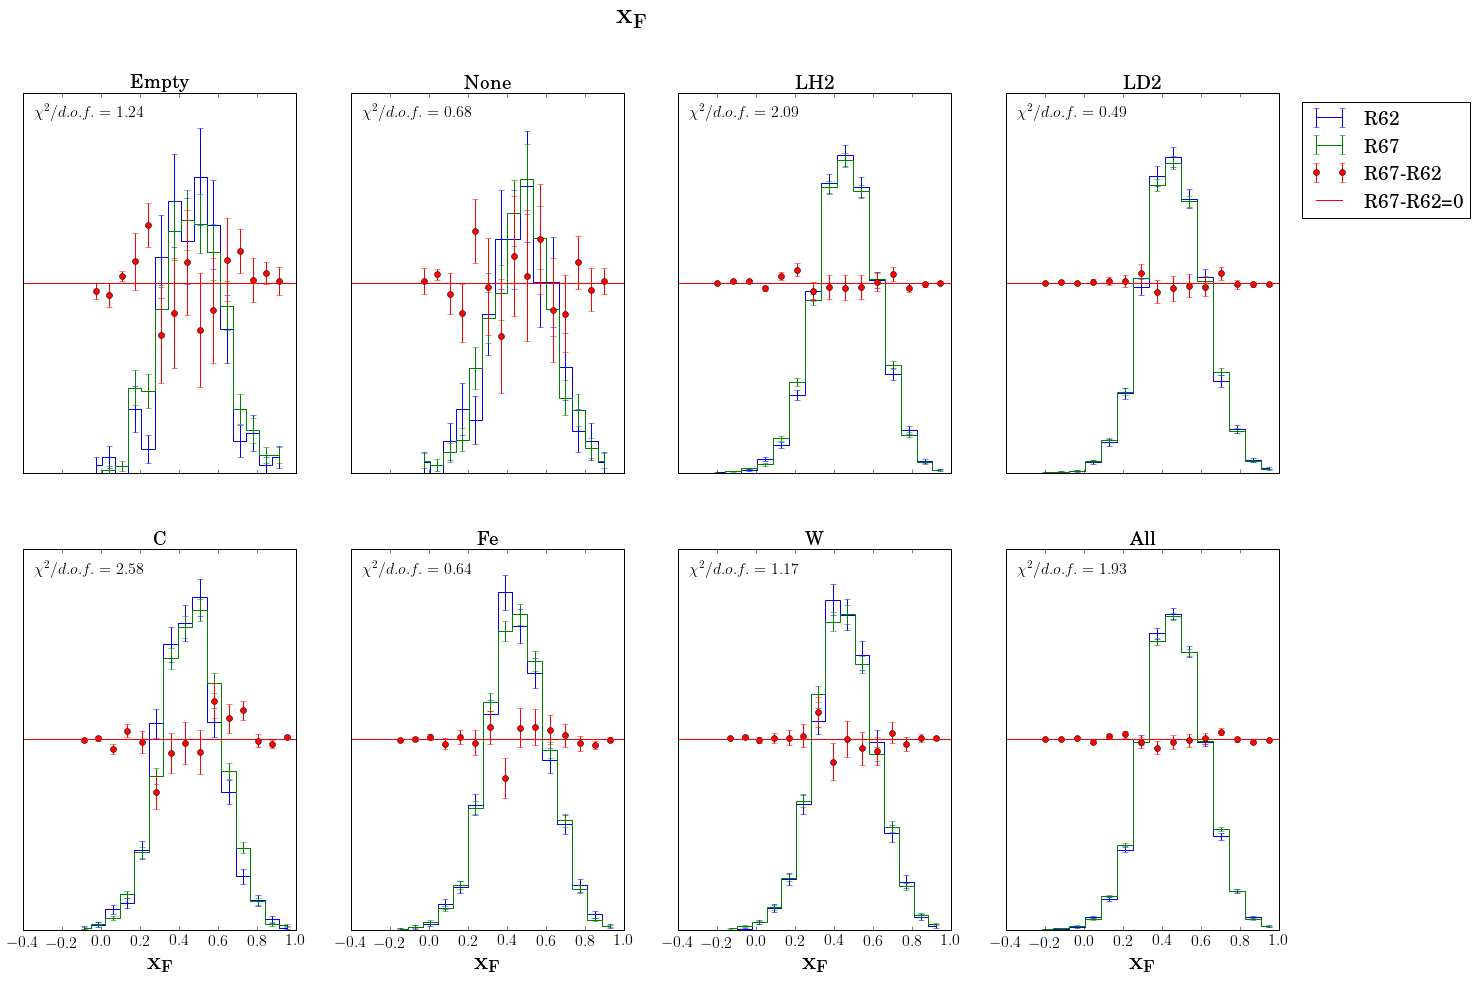

In [404]:
dimuon_df = pd.concat([xf_emc.roadsets[57].dimuons.data.copy(),
                       xf_emc.roadsets[62].dimuons.data.copy(),
                       xf_emc.roadsets[67].dimuons.data.copy()])
plt_kin(dimuon_df, "xF", r'$\mathbf{x_F}$', 57, 62)
plt_kin(dimuon_df, "xF", r'$\mathbf{x_F}$', 57, 67)
plt_kin(dimuon_df, "xF", r'$\mathbf{x_F}$', 62, 67)

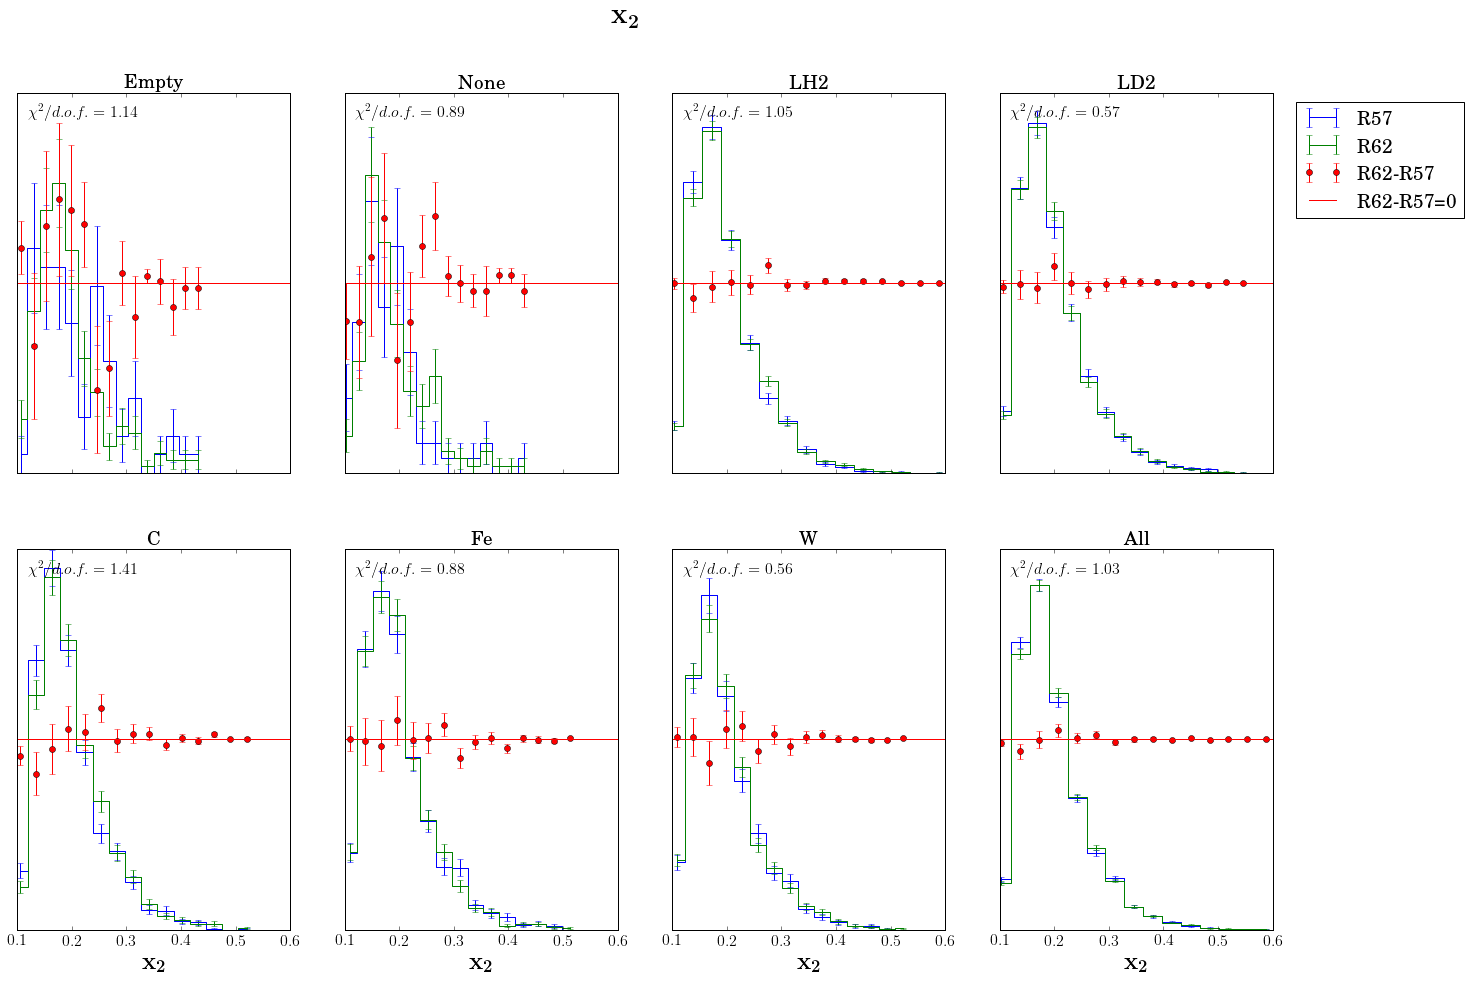

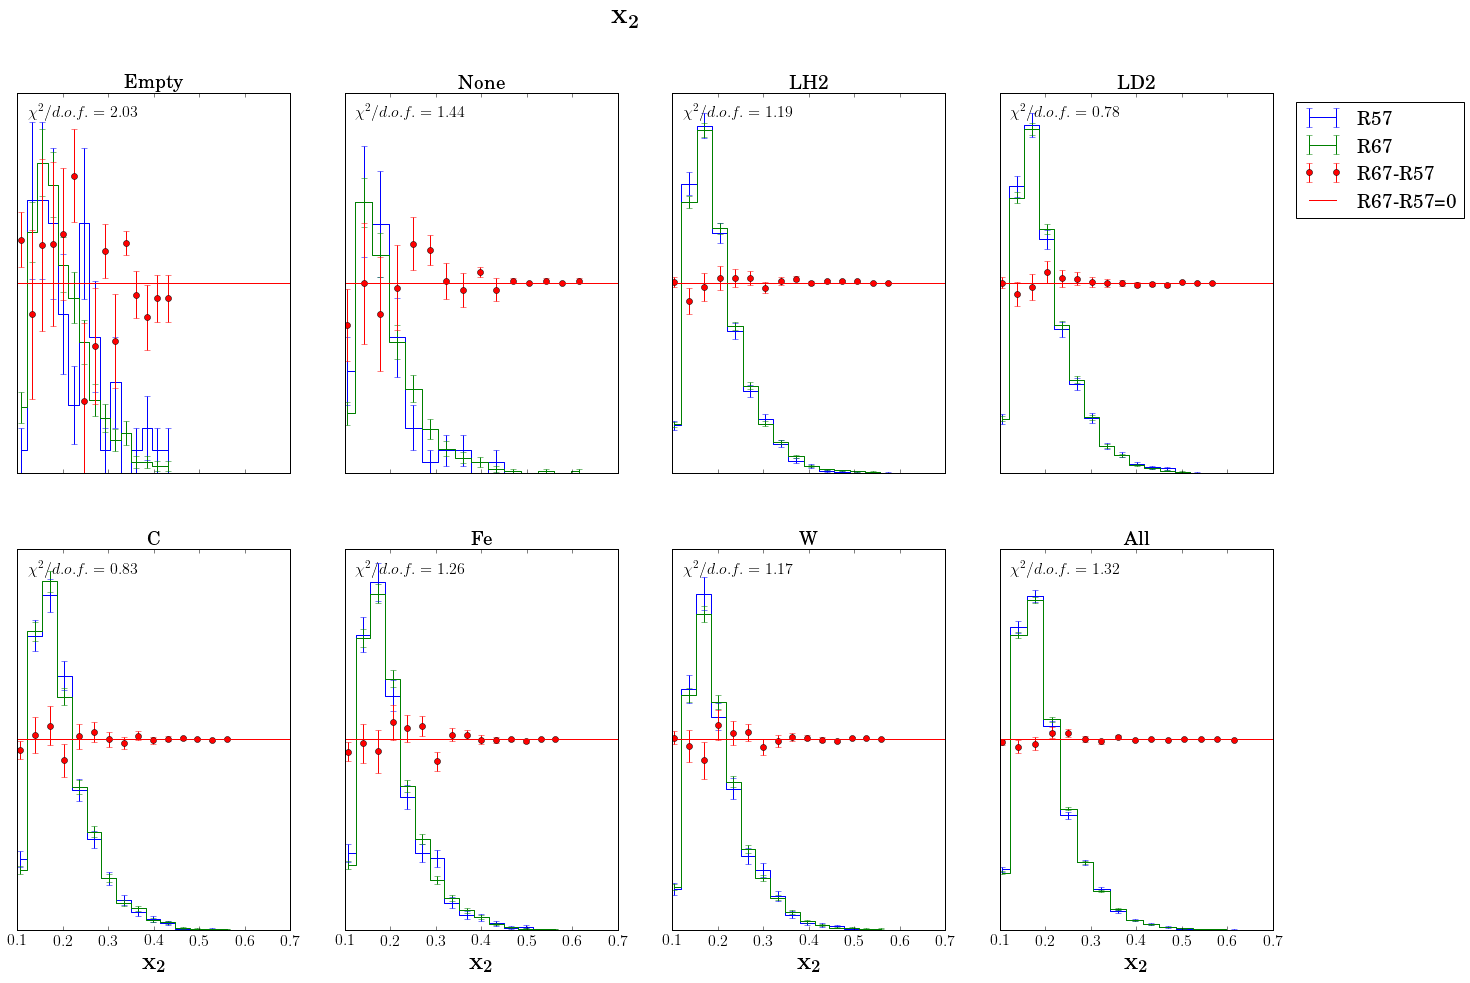

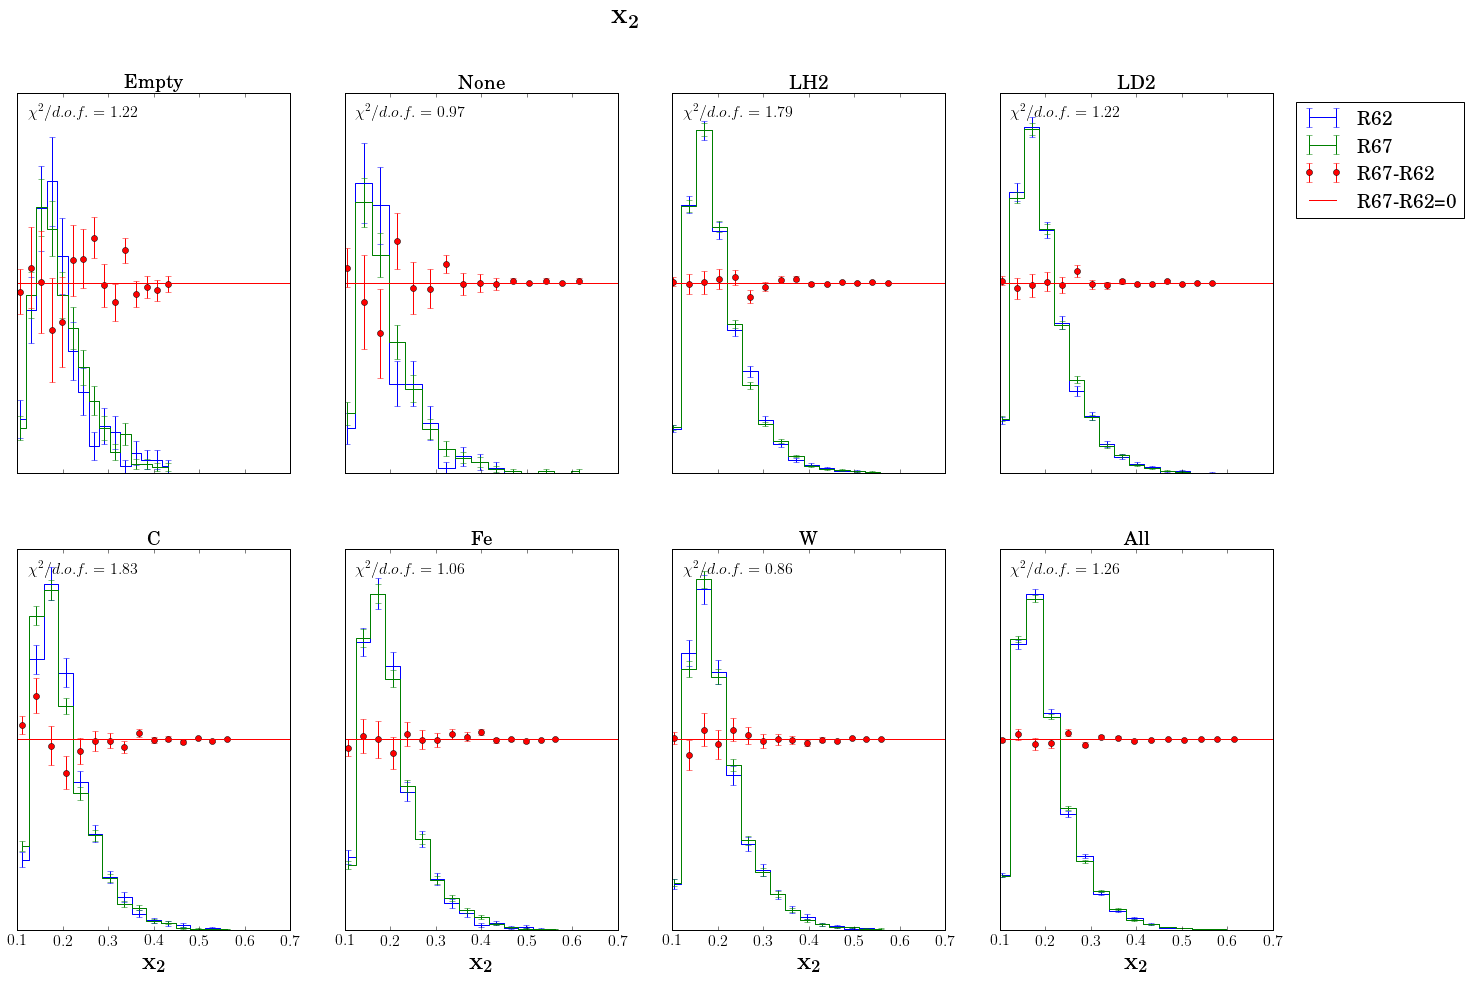

In [405]:
dimuon_df = pd.concat([xt_emc.roadsets[57].dimuons.data.copy(),
                       xt_emc.roadsets[62].dimuons.data.copy(),
                       xt_emc.roadsets[67].dimuons.data.copy()])
plt_kin(dimuon_df, "xT", r'$\mathbf{x_2}$', 57, 62)
plt_kin(dimuon_df, "xT", r'$\mathbf{x_2}$', 57, 67)
plt_kin(dimuon_df, "xT", r'$\mathbf{x_2}$', 62, 67)

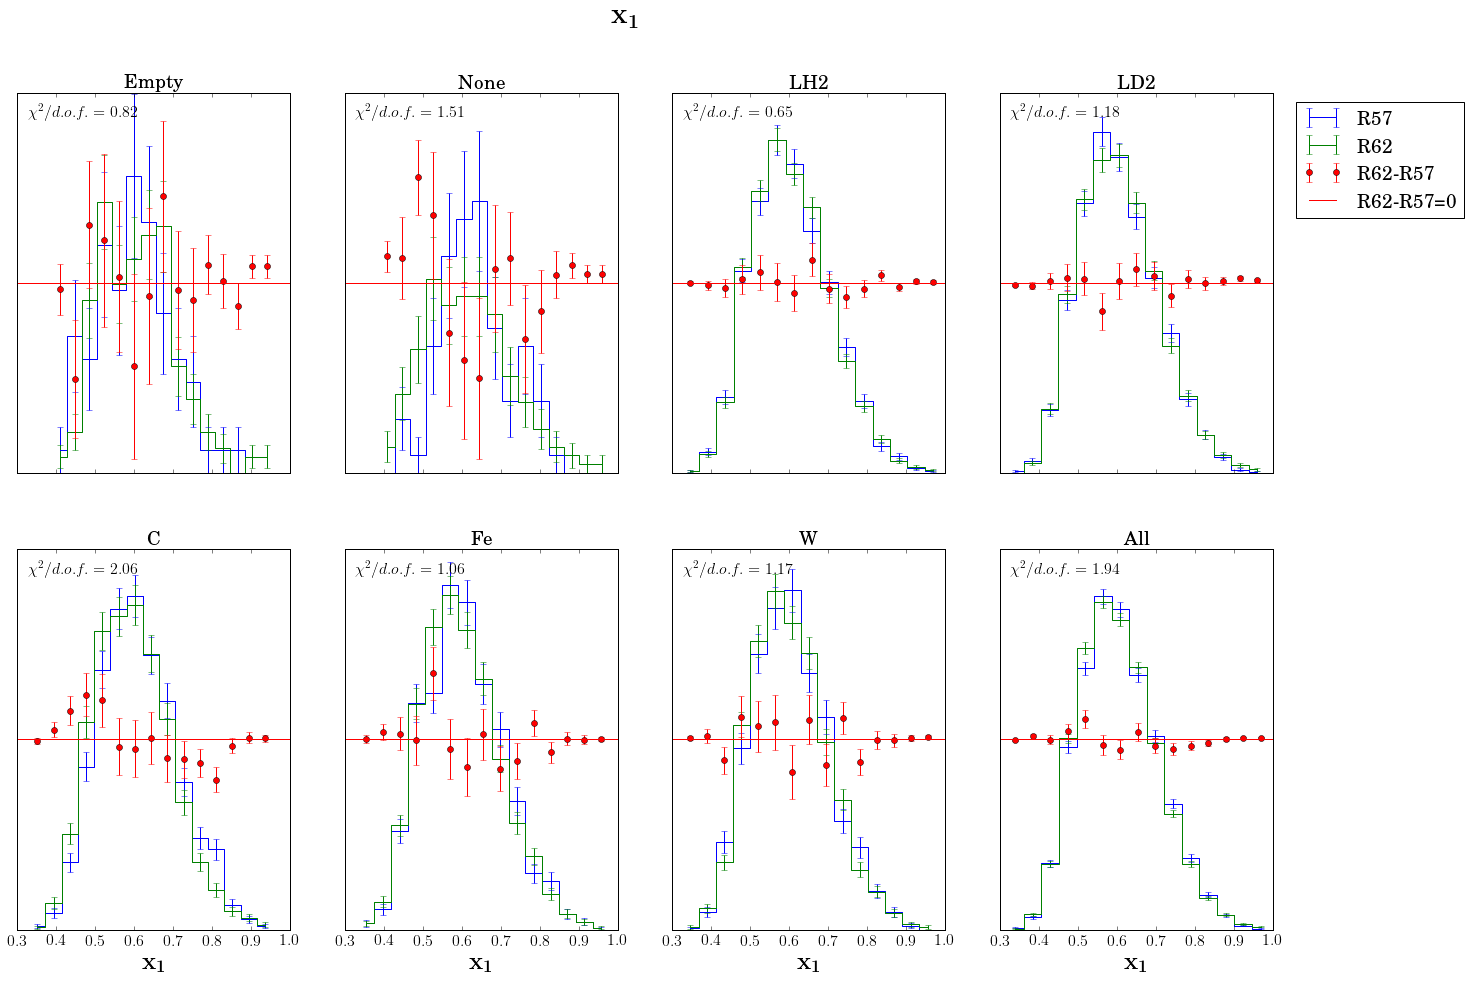

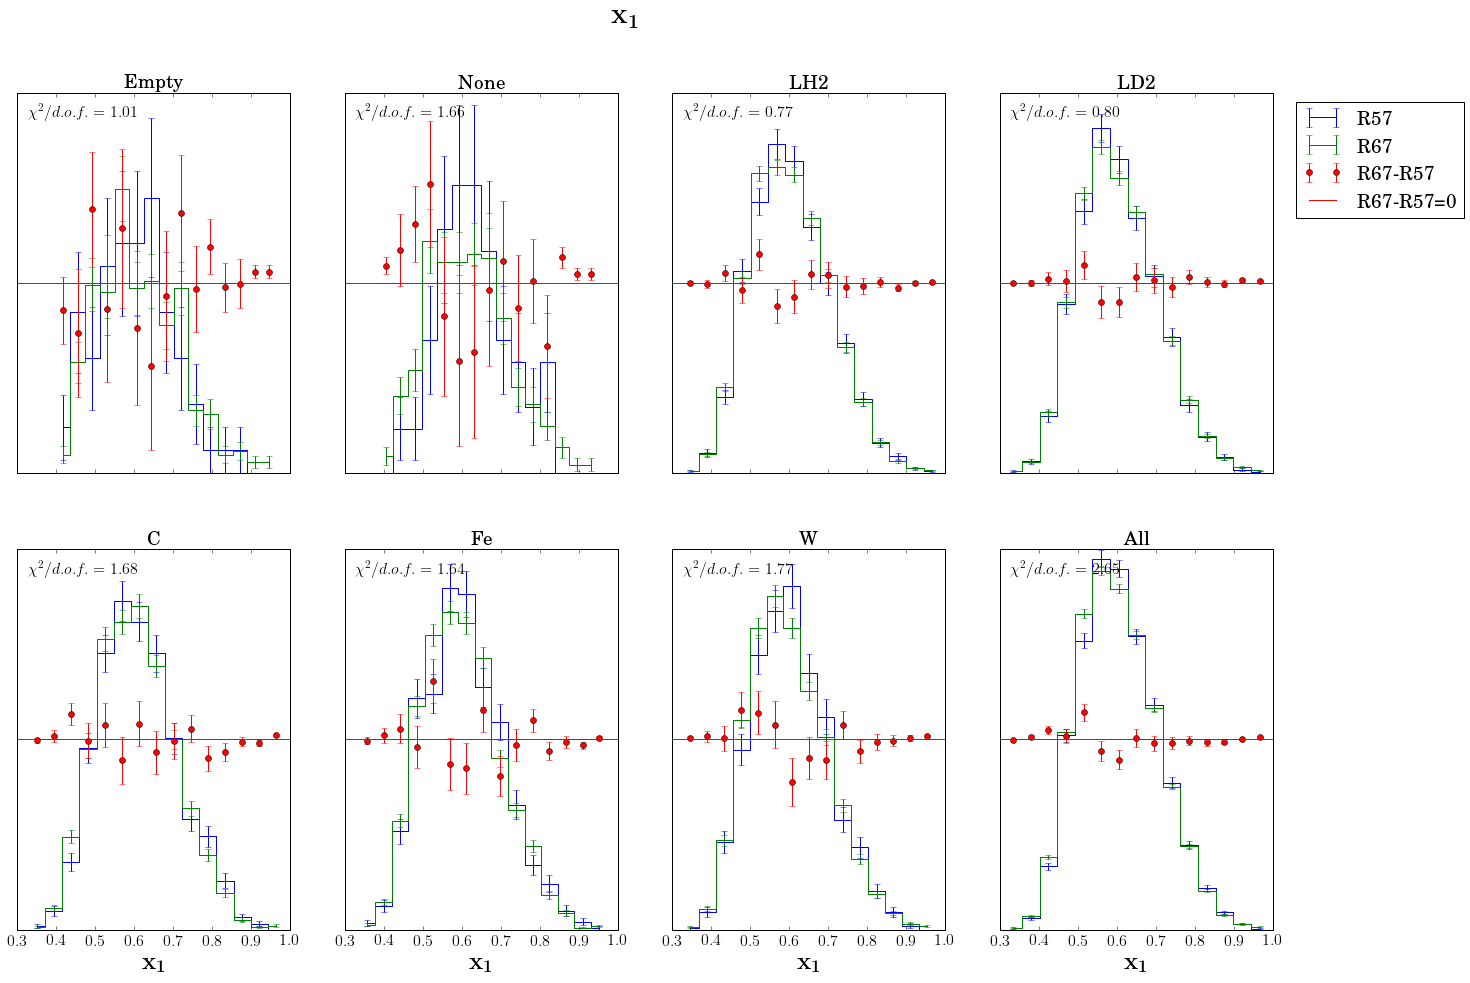

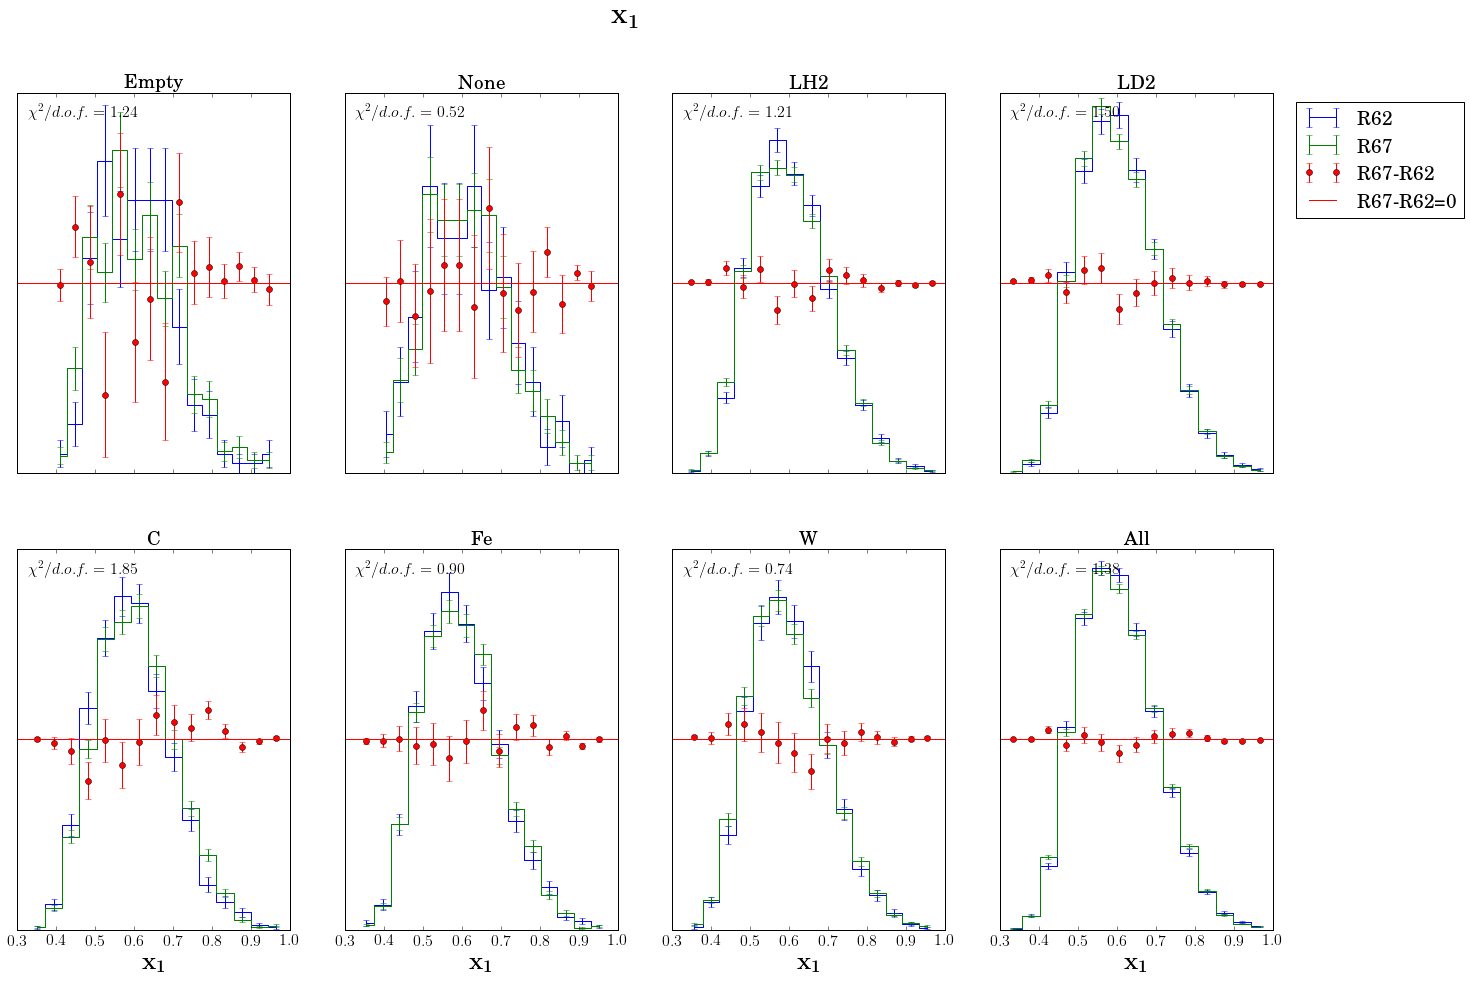

In [406]:
dimuon_df = pd.concat([xb_emc.roadsets[57].dimuons.data.copy(),
                       xb_emc.roadsets[62].dimuons.data.copy(),
                       xb_emc.roadsets[67].dimuons.data.copy()])
plt_kin(dimuon_df, "xB", r'$\mathbf{x_1}$', 57, 62)
plt_kin(dimuon_df, "xB", r'$\mathbf{x_1}$', 57, 67)
plt_kin(dimuon_df, "xB", r'$\mathbf{x_1}$', 62, 67)

In [411]:
dimuon_df.head()

,dimuonID,runID,spillID,eventID,targetPos,posTrackID,negTrackID,dx,dy,dz,dpx,dpy,dpz,mass,xF,xB,xT,costh,phi,trackSeparation,chisq_dimuon,px1,py1,pz1,px2,py2,pz2,isValid,isTarget,isDump,QIESum,chamber_intensity,trigger_intensity,weight,dpt,pt1,pt2,target,roadset,weight_keff,weight_keff_sq,weight_bg,weight_bg_sq,weight_sq
3,8312,9045,310966,123195,1,77594,77595,-0.135188,-0.053822,-118.373256,0.192485,-0.031923,59.896244,6.266526,0.182668,0.497970,0.348095,-0.225865,0.385112,42.5,1.211102,3.074028,0.651784,23.991137,-2.881543,-0.683707,35.905107,1,1,0,1.176240e+11,8259.36,10717.3,1.016+/-0.010,0.195114,3.142367,2.961544,LH2,57,1.144961,1.310936,0.888+/-0.009,0.788+/-0.016,1.033+/-0.021
6,3231,9046,310993,48263,1,30264,30265,-0.279677,0.121889,-216.456770,-0.393286,1.432690,65.773497,5.589235,0.321871,0.545960,0.270569,0.222447,-1.559702,57.5,8.614078,2.420347,1.467141,40.075376,-2.813633,-0.034451,25.698121,1,0,0,1.146890e+11,48640.00,53168.2,1.394+/-0.029,1.485690,2.830297,2.813844,LH2,57,2.402265,5.770879,0.580+/-0.012,0.337+/-0.014,1.94+/-0.08
11,2522,9047,311041,34983,1,22034,22035,0.374492,0.175432,-168.420330,1.130525,0.539590,57.108843,4.792991,0.275048,0.473989,0.228716,-0.172402,0.055615,-140.0,9.103848,2.705143,1.436394,30.867898,-1.574618,-0.896803,26.240945,1,1,0,1.180820e+11,13459.60,11369.6,1.075+/-0.010,1.252695,3.062846,1.812092,LH2,57,1.232576,1.519243,0.872+/-0.008,0.761+/-0.014,1.156+/-0.021
16,5646,9047,311057,76136,1,48320,48321,0.249570,-0.096968,-152.815095,-0.859808,-0.093004,64.405971,5.702066,0.305873,0.534684,0.274686,-0.039227,-0.102791,-97.5,2.657848,2.449138,-0.028902,26.152571,-3.308946,-0.064102,38.253400,1,1,0,1.180710e+11,33346.40,25065.3,1.2245+/-0.0009,0.864823,2.449309,3.309567,LH2,57,1.637252,2.680593,0.7479+/-0.0005,0.5594+/-0.0008,1.4994+/-0.0022
17,5871,9047,311058,78842,1,50121,50120,0.160277,-0.011053,-183.888171,-0.151477,0.760005,80.610717,4.702394,0.576439,0.667710,0.151503,0.137315,1.039866,-65.0,4.091123,2.125177,-0.398707,42.492100,-2.276654,1.158712,38.118617,1,1,0,1.181570e+11,36455.40,29398.1,1.255+/-0.004,0.774953,2.162255,2.554558,LH2,57,1.746402,3.049918,0.7189+/-0.0025,0.517+/-0.004,1.576+/-0.011


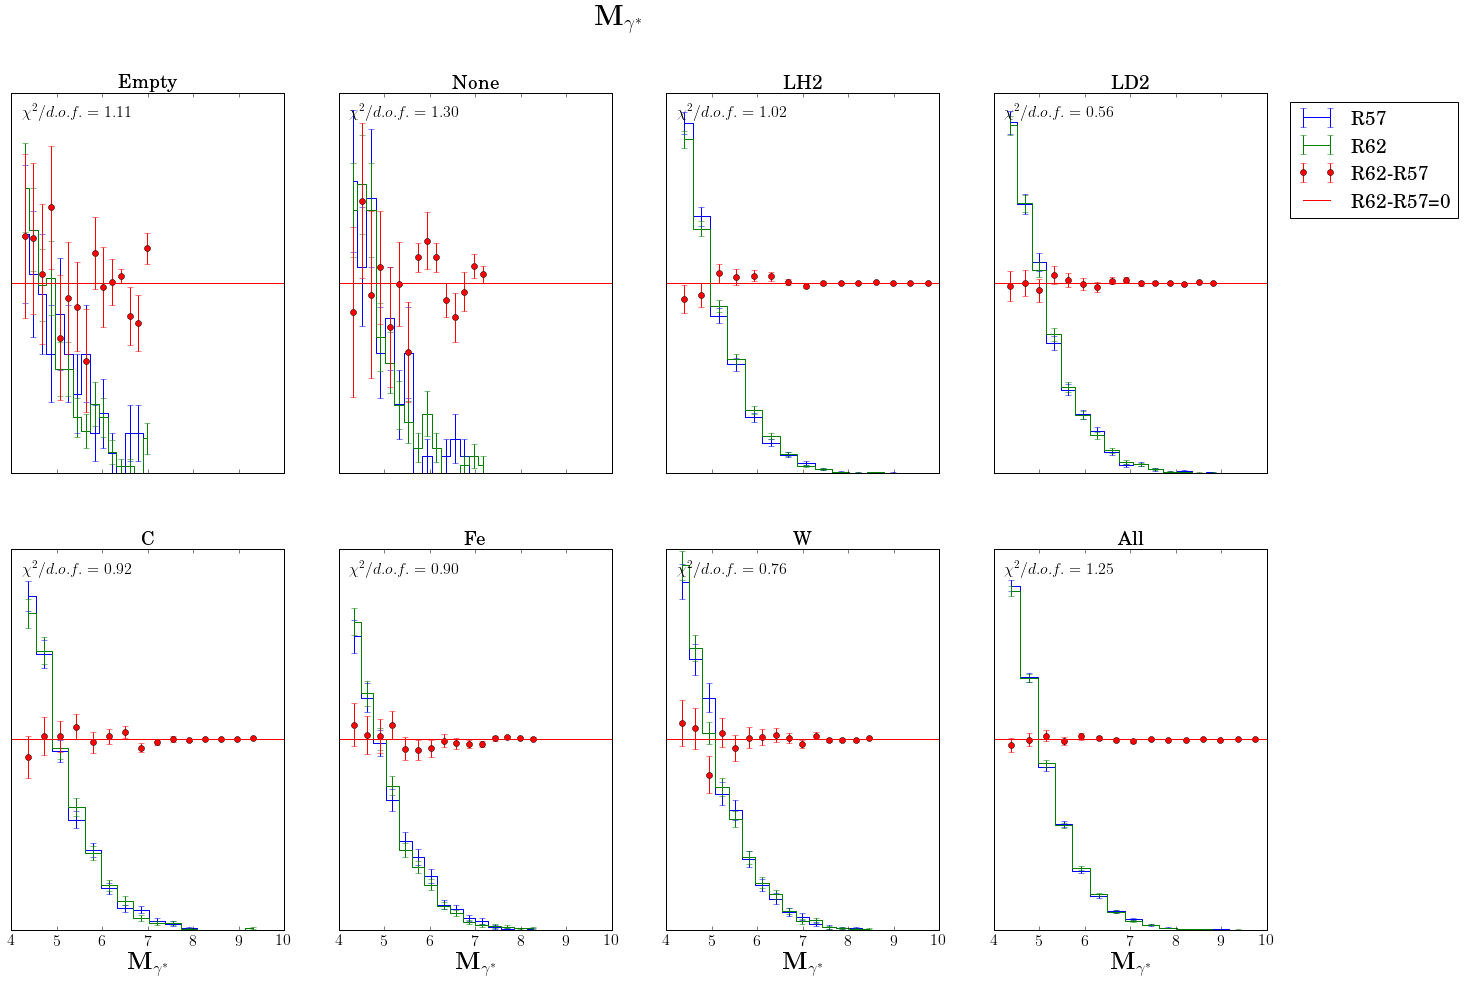

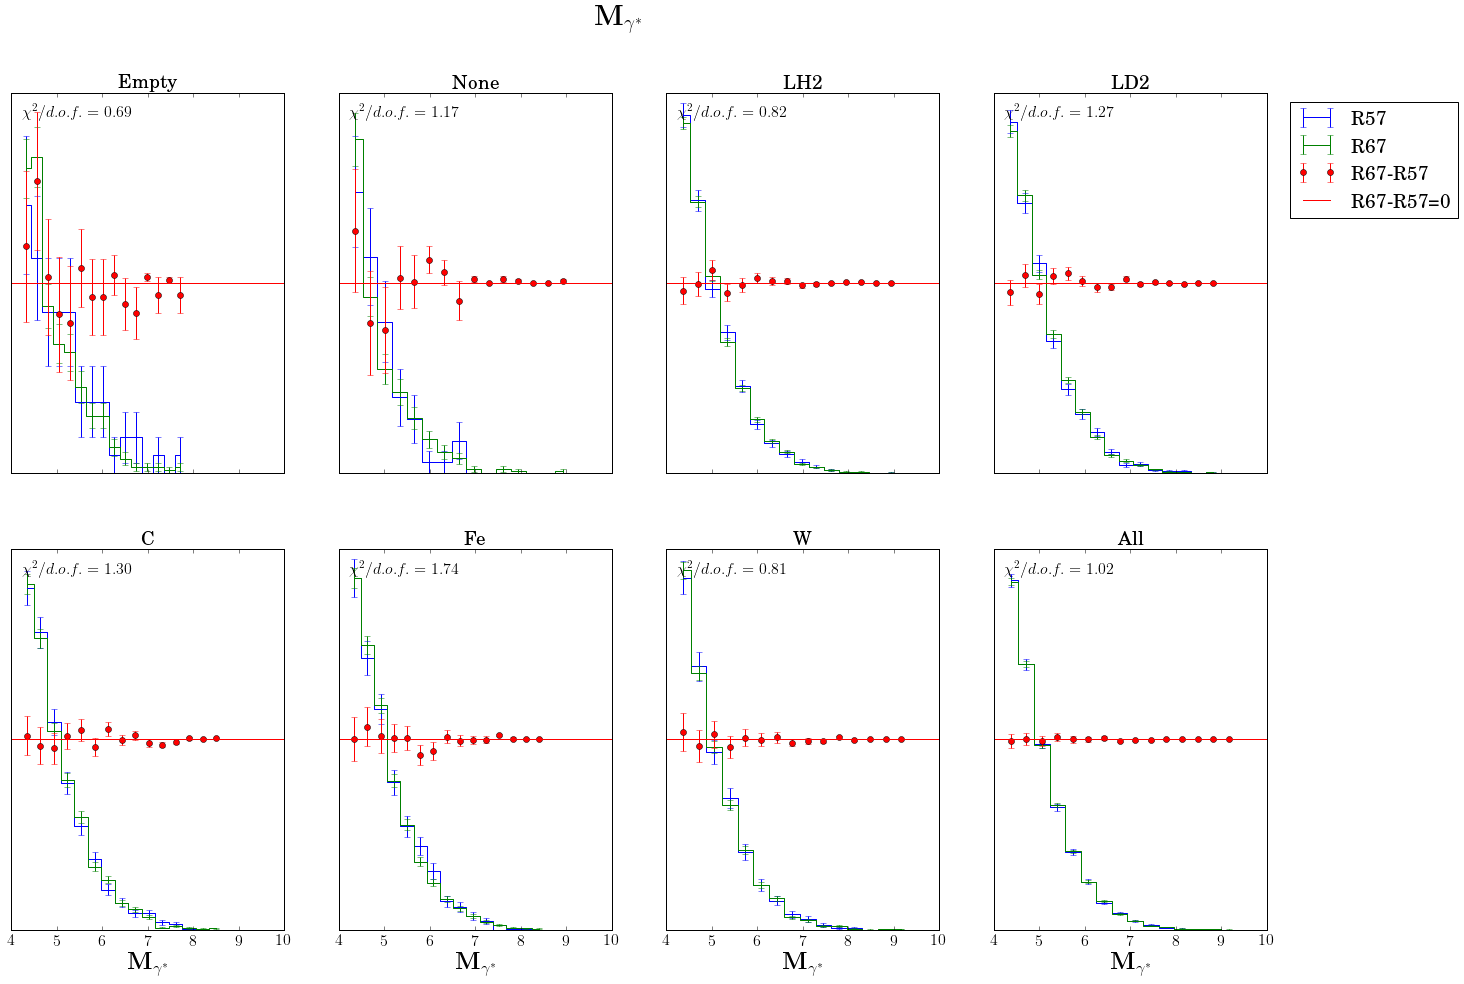

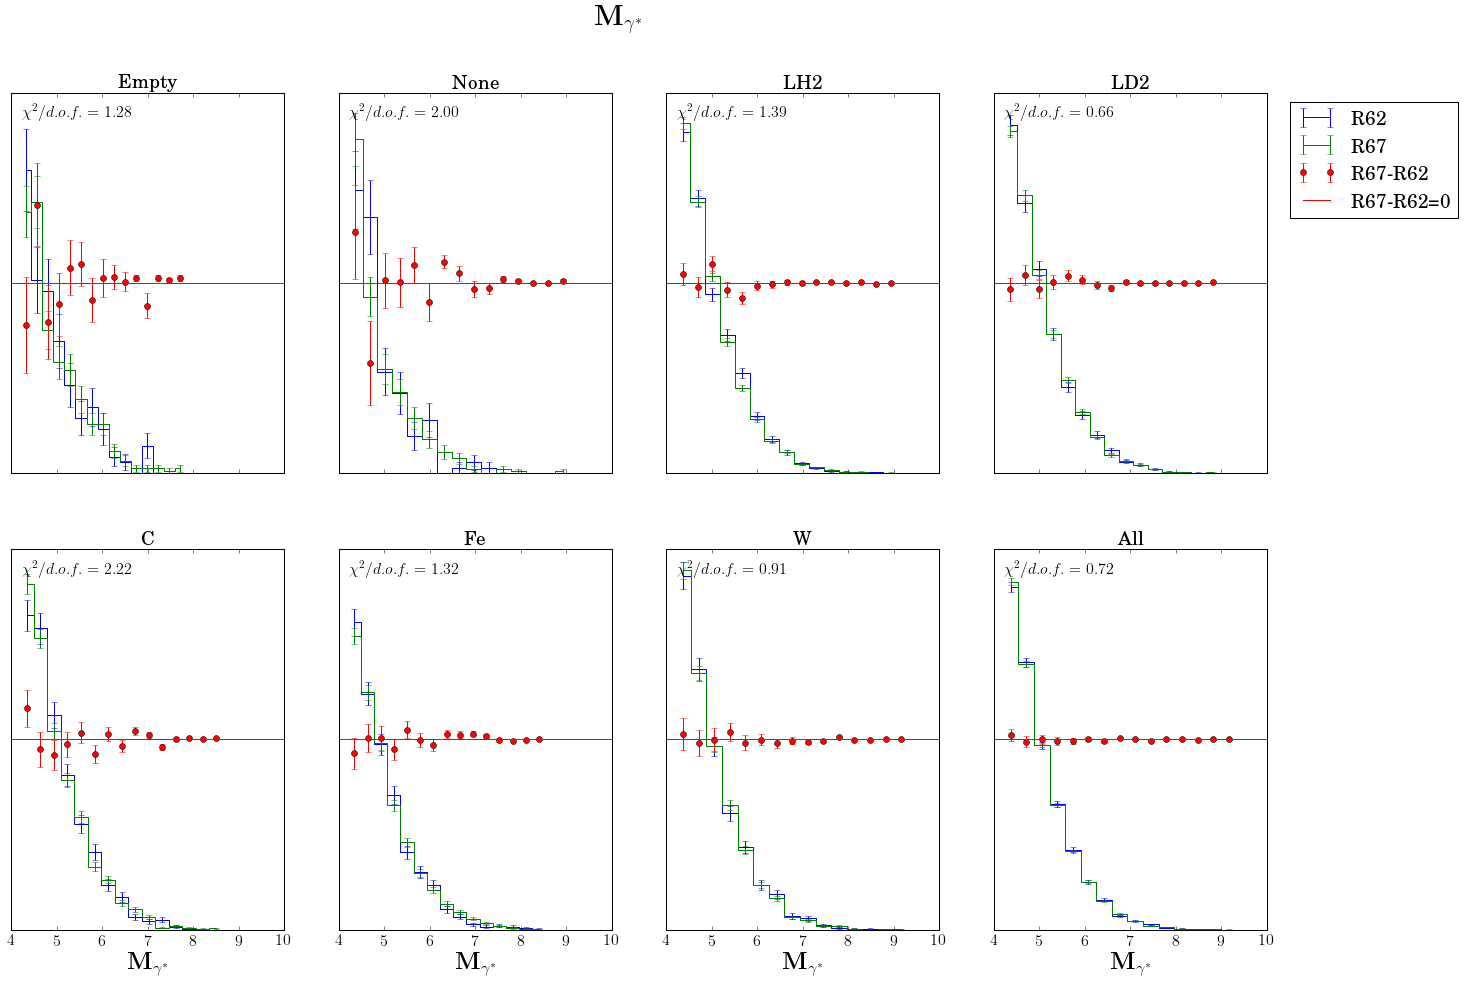

In [407]:
dimuon_df = pd.concat([mass_emc.roadsets[57].dimuons.data.copy(),
                       mass_emc.roadsets[62].dimuons.data.copy(),
                       mass_emc.roadsets[67].dimuons.data.copy()])
plt_kin(dimuon_df, "mass", r'$\mathbf{M_{\gamma^*}}$', 57, 62)
plt_kin(dimuon_df, "mass", r'$\mathbf{M_{\gamma^*}}$', 57, 67)
plt_kin(dimuon_df, "mass", r'$\mathbf{M_{\gamma^*}}$', 62, 67)

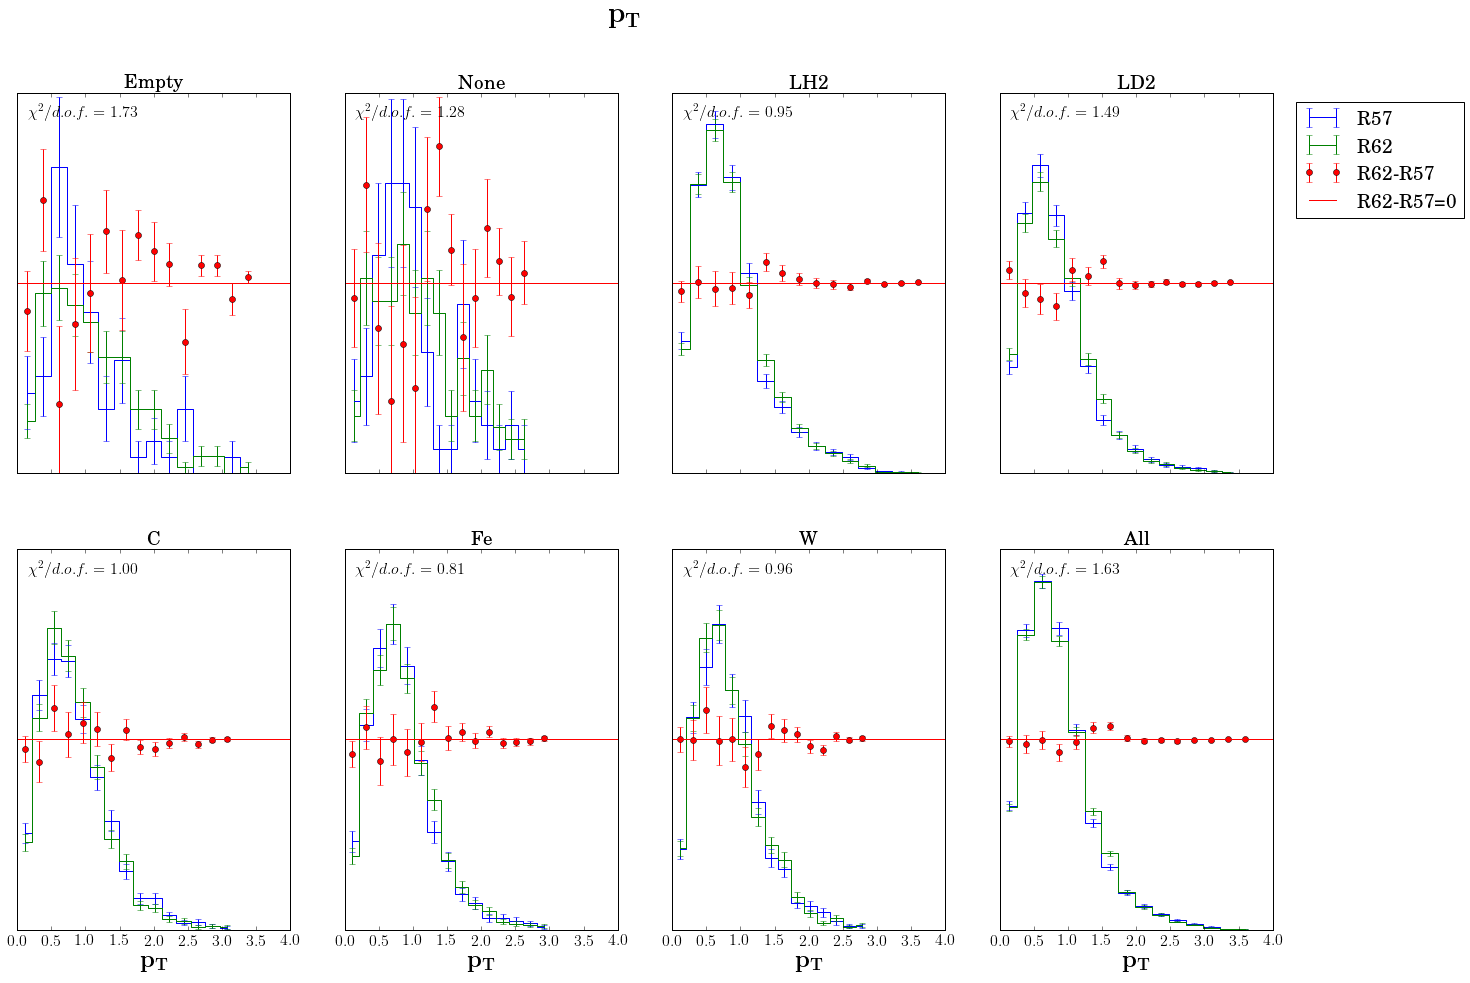

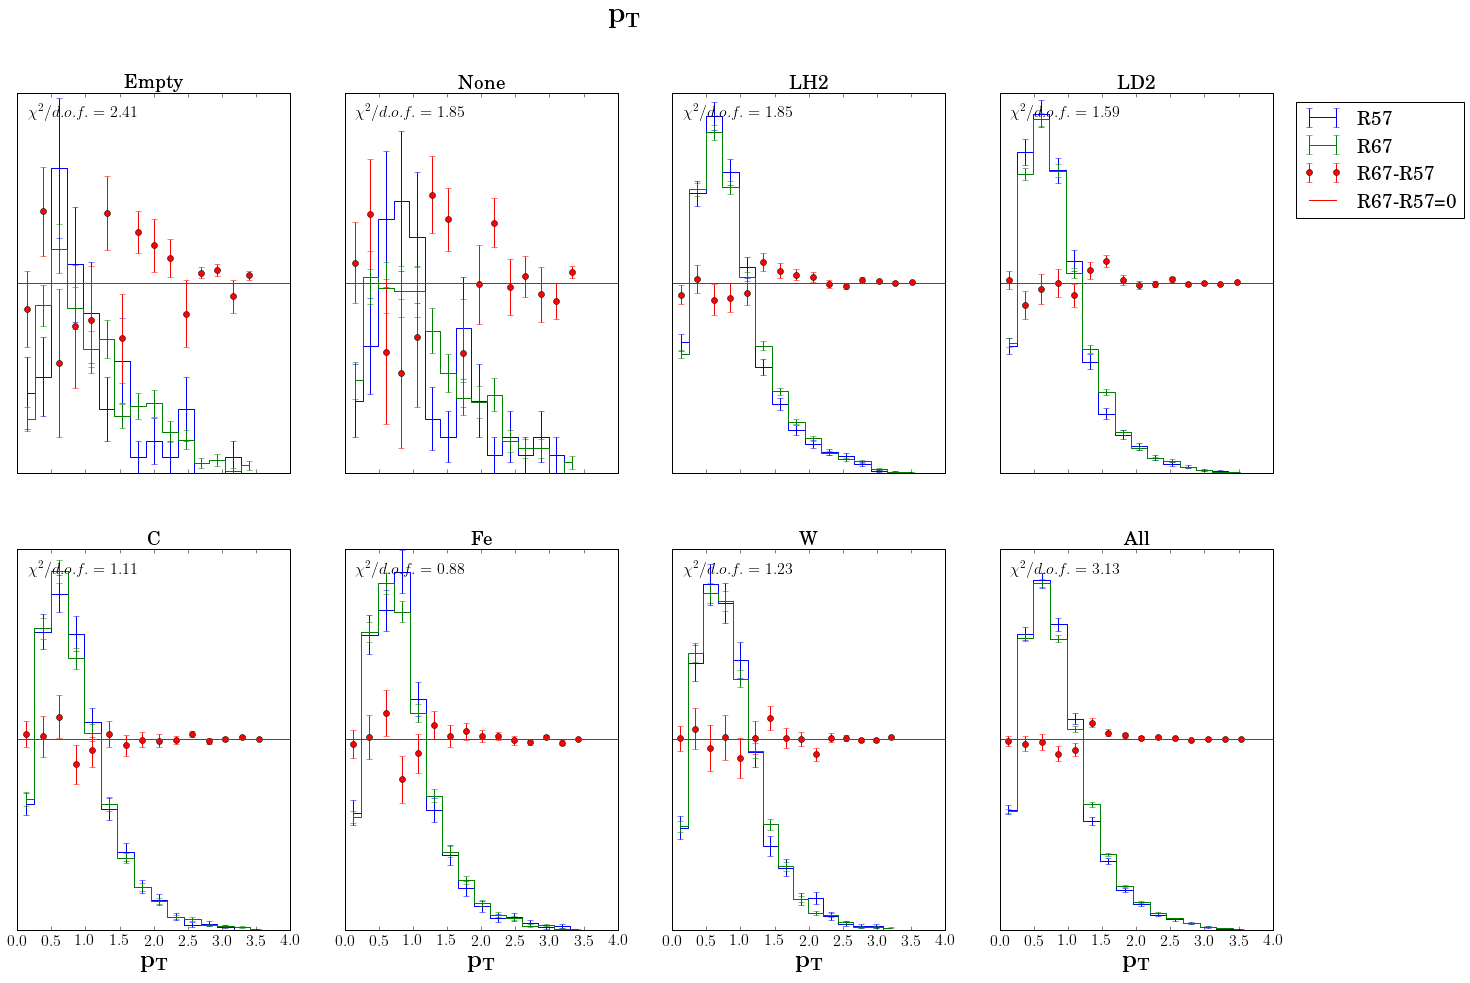

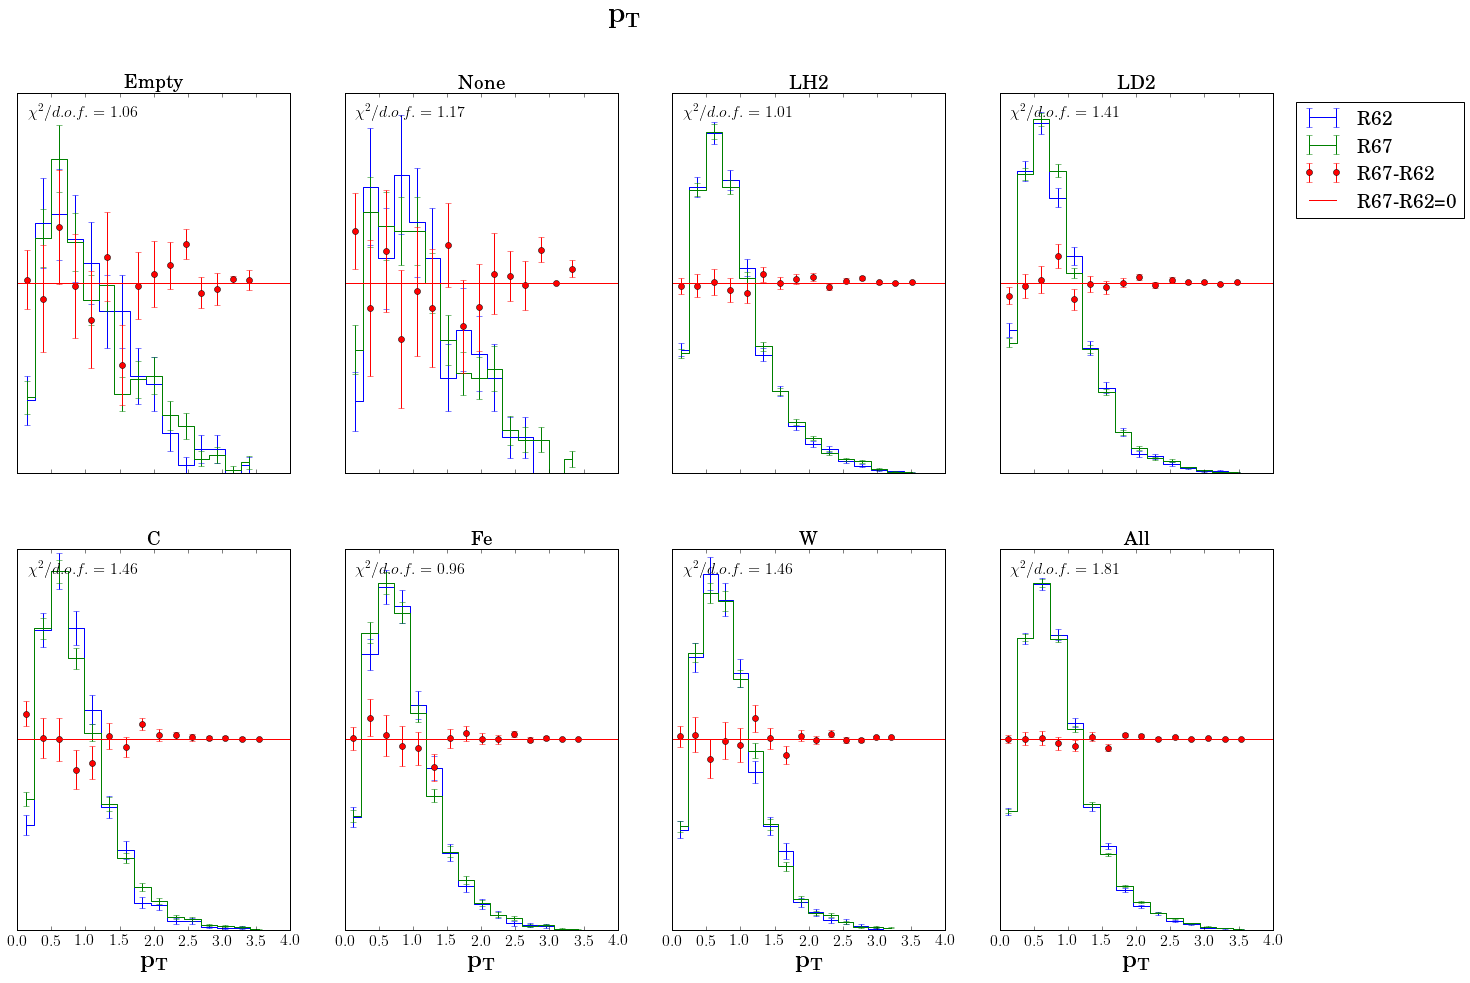

In [408]:
dimuon_df = pd.concat([pt_emc.roadsets[57].dimuons.data.copy(),
                       pt_emc.roadsets[62].dimuons.data.copy(),
                       pt_emc.roadsets[67].dimuons.data.copy()])
plt_kin(dimuon_df, "dpt", r'$\mathbf{p_T}$', 57, 62)
plt_kin(dimuon_df, "dpt", r'$\mathbf{p_T}$', 57, 67)
plt_kin(dimuon_df, "dpt", r'$\mathbf{p_T}$', 62, 67)

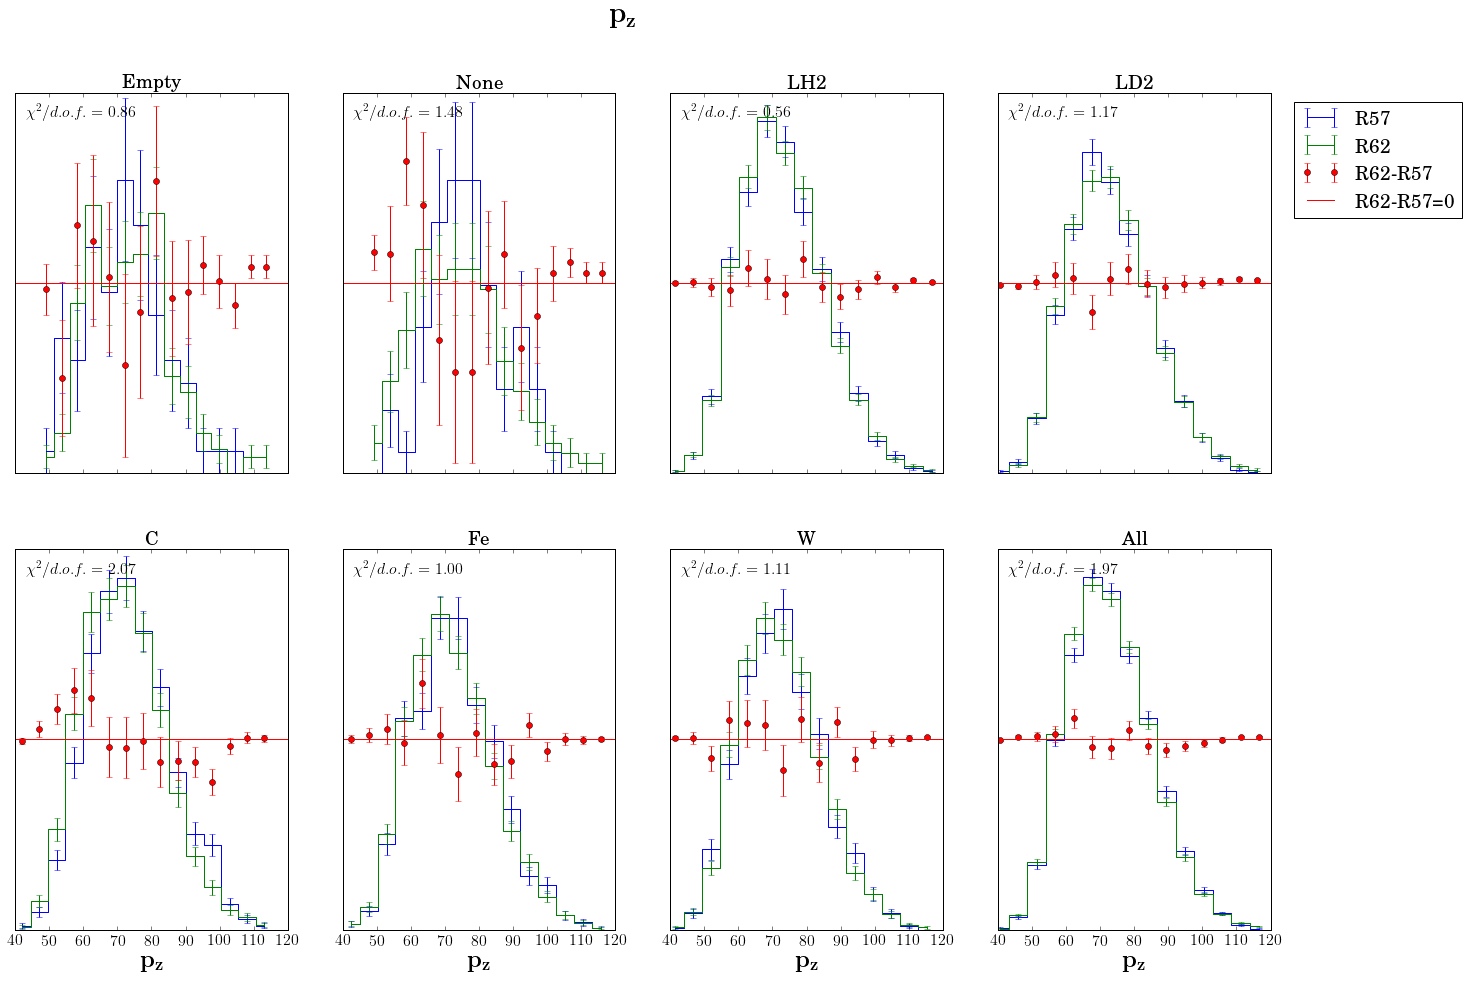

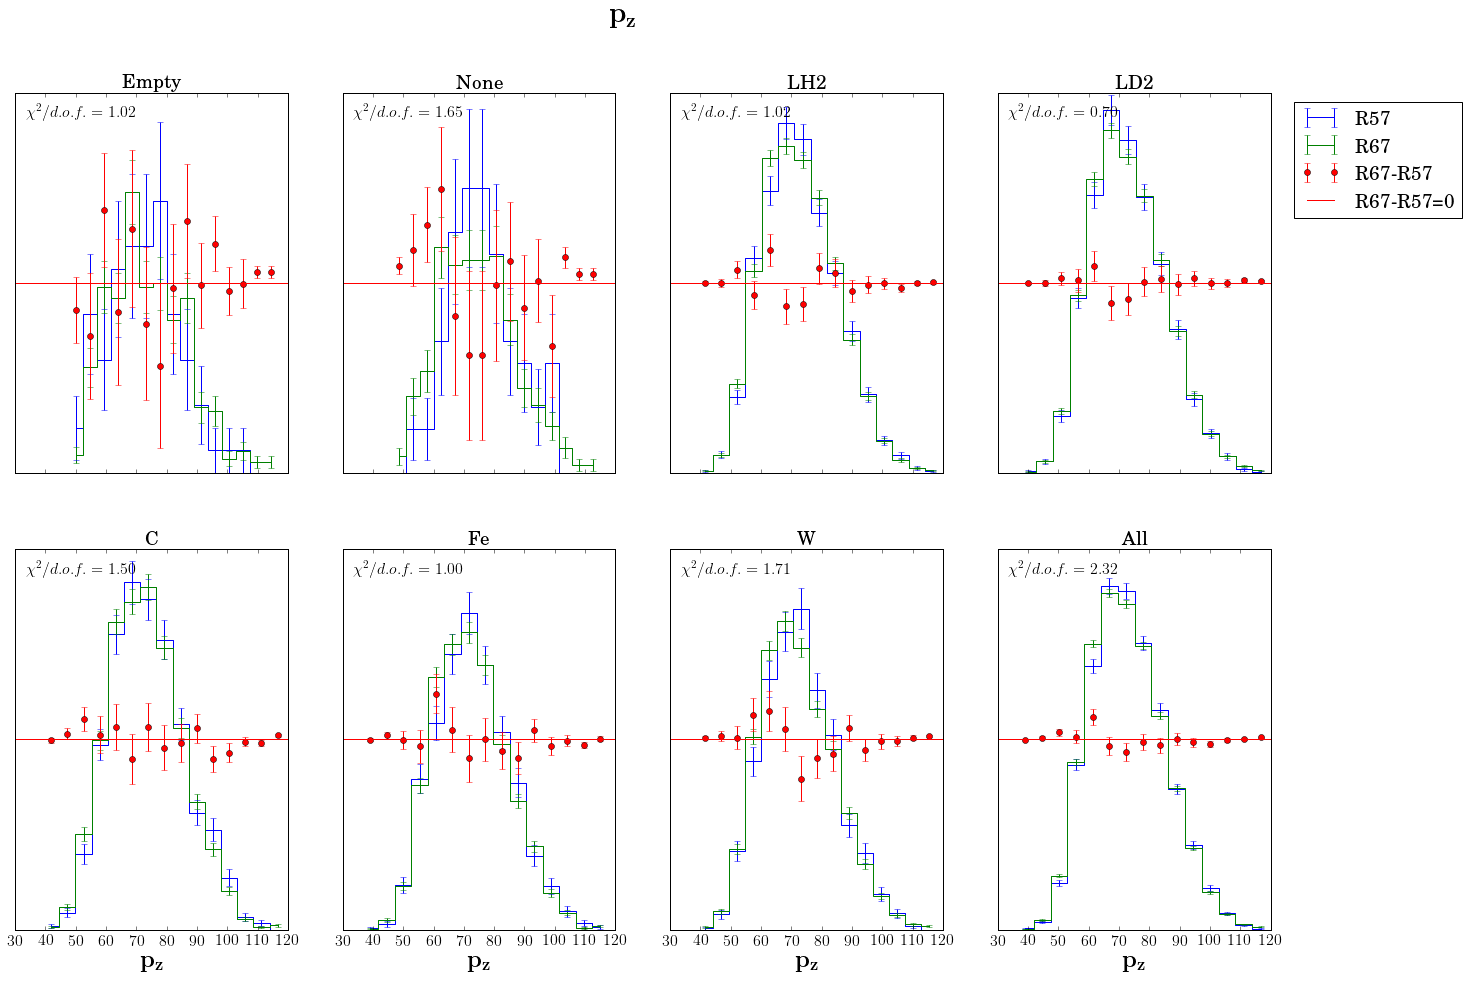

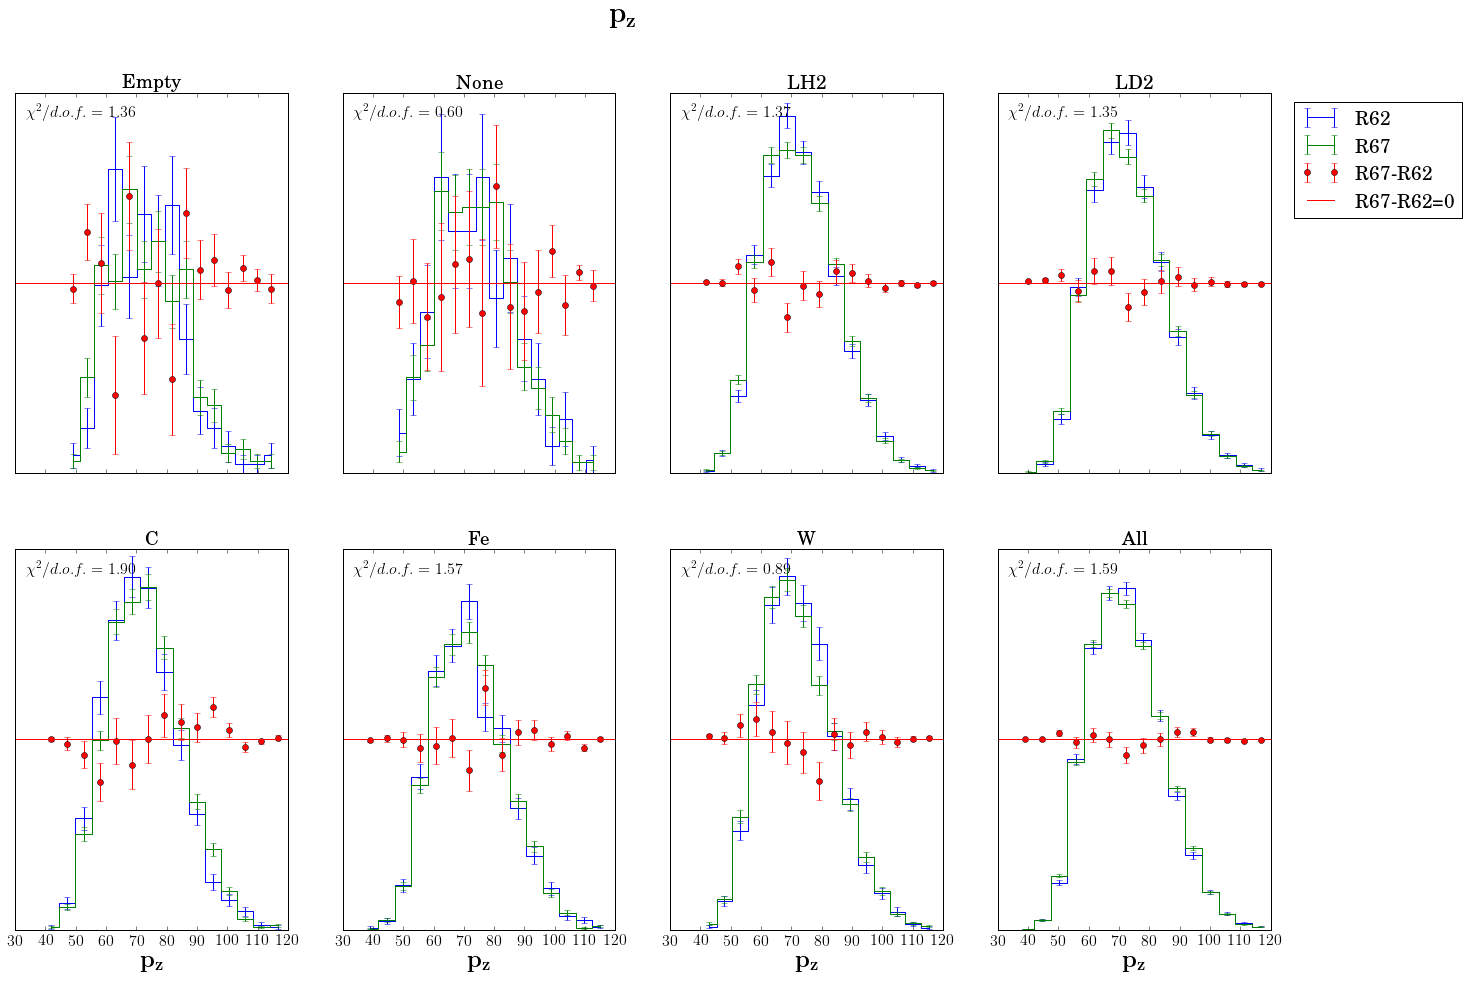

In [409]:
dimuon_df = pd.concat([pz_emc.roadsets[57].dimuons.data.copy(),
                       pz_emc.roadsets[62].dimuons.data.copy(),
                       pz_emc.roadsets[67].dimuons.data.copy()])
plt_kin(dimuon_df, "dpz", r'$\mathbf{p_z}$', 57, 62)
plt_kin(dimuon_df, "dpz", r'$\mathbf{p_z}$', 57, 67)
plt_kin(dimuon_df, "dpz", r'$\mathbf{p_z}$', 62, 67)

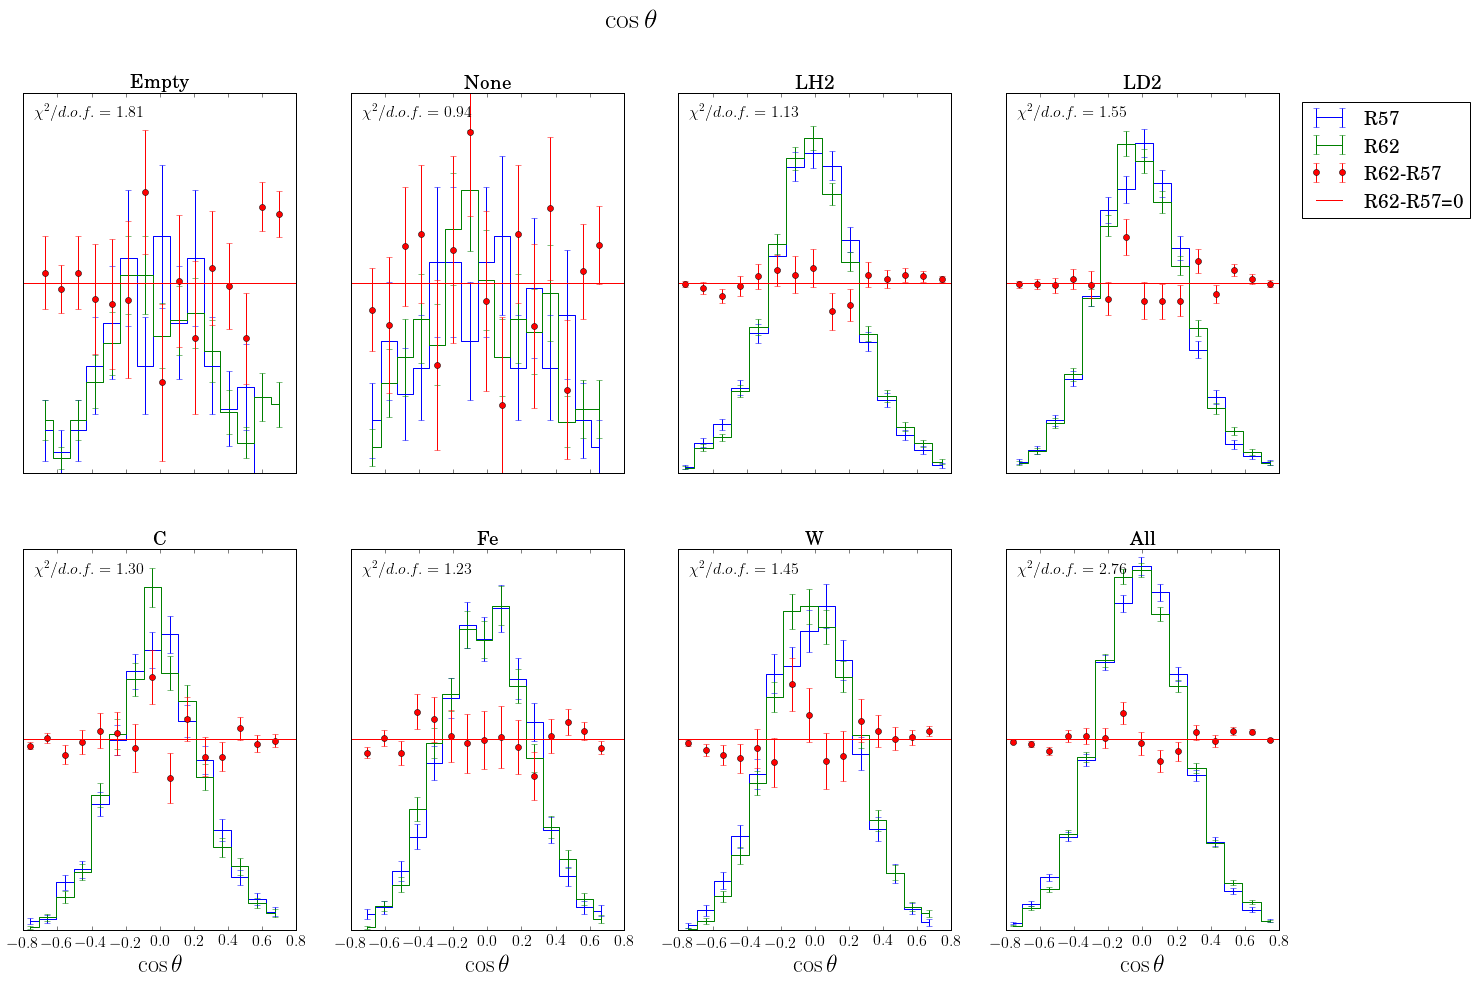

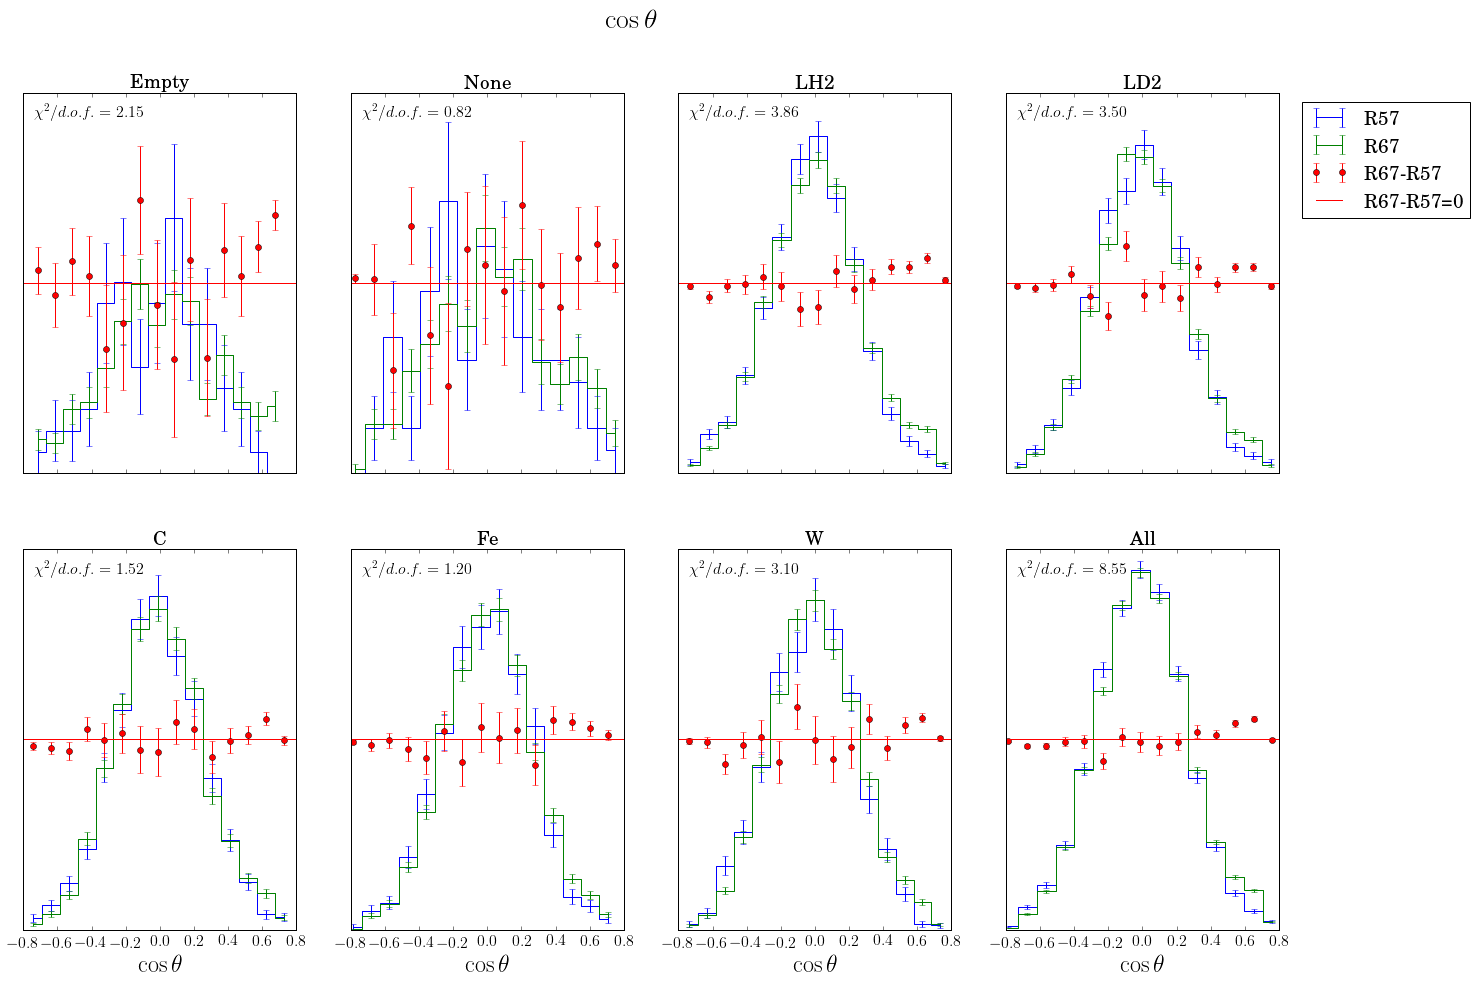

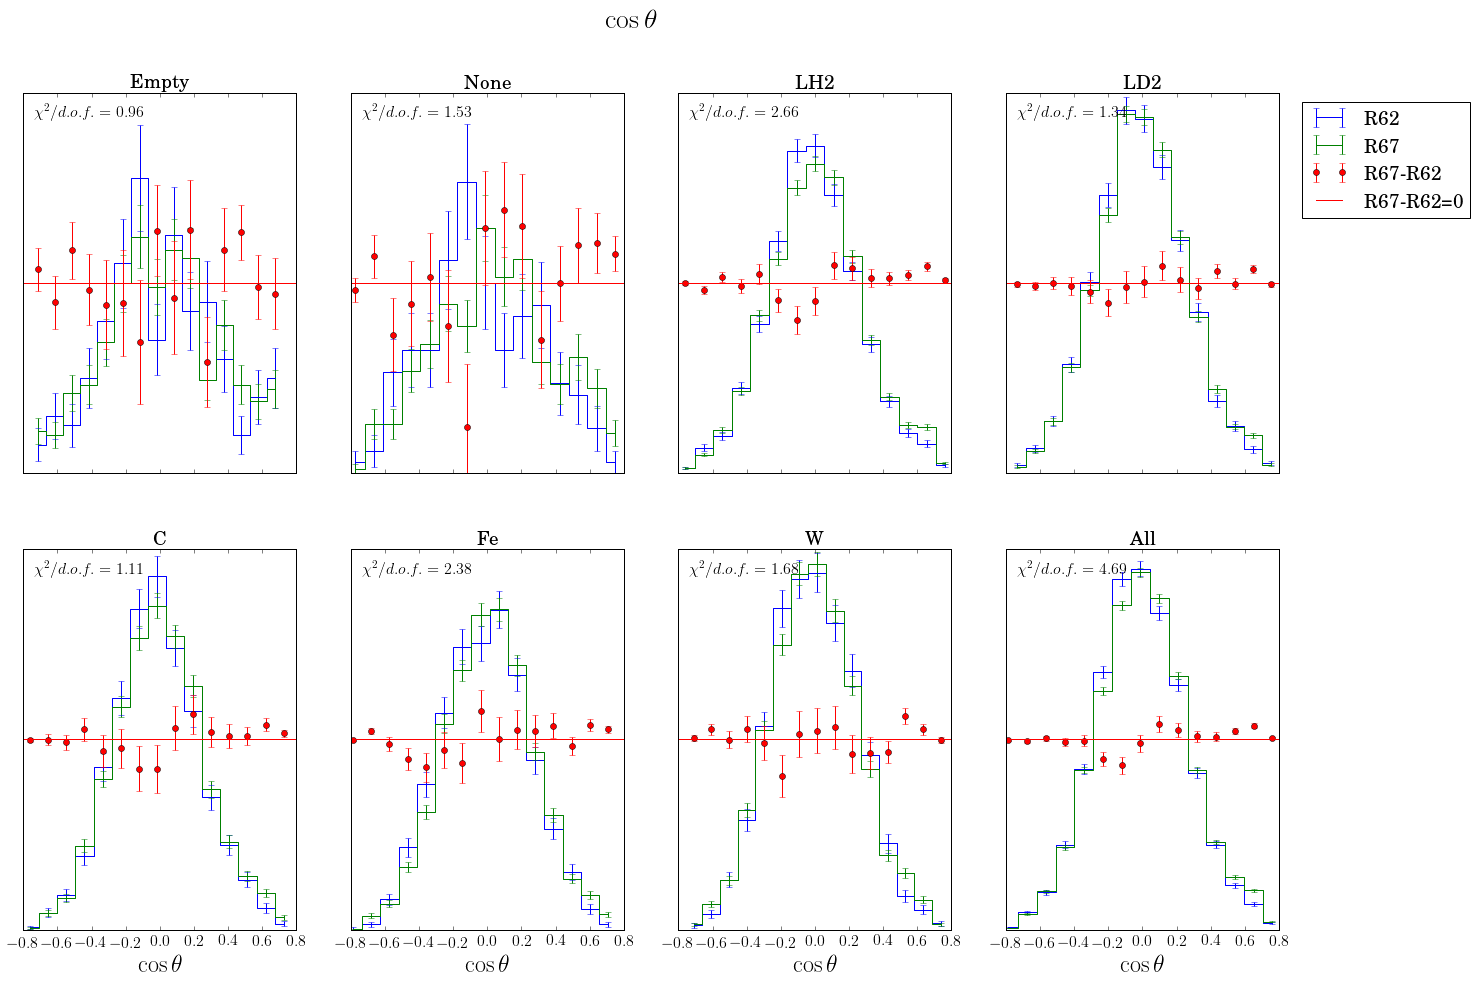

In [410]:
dimuon_df = pd.concat([costh_emc.roadsets[57].dimuons.data.copy(),
                       costh_emc.roadsets[62].dimuons.data.copy(),
                       costh_emc.roadsets[67].dimuons.data.copy()])
plt_kin(dimuon_df, "costh", r'$\mathbf{\cos\theta}$', 57, 62)
plt_kin(dimuon_df, "costh", r'$\mathbf{\cos\theta}$', 57, 67)
plt_kin(dimuon_df, "costh", r'$\mathbf{\cos\theta}$', 62, 67)

In [162]:
print xf_emc.kin.values()
print xb_emc.kin.values()
print xt_emc.kin.values()
print mass_emc.kin.values()
print pt_emc.kin.values()
print pz_emc.kin.values()

[[-0.2913, 0.2831, 0.3544, 0.4073, 0.4573, 0.5083, 0.5646, 0.6407, 0.9899]]
[[0.3045, 0.4892, 0.529, 0.5624, 0.5955, 0.6301, 0.6701, 0.7245, 0.9919]]
[[0.0856, 0.1367, 0.1529, 0.1676, 0.1831, 0.2017, 0.2269, 0.2694, 0.6786]]
[[4.2, 4.3274, 4.4677, 4.6218, 4.8012, 5.0171, 5.3114, 5.7649, 9.9422]]
[[0.0042, 0.3232, 0.4766, 0.6146, 0.7512, 0.9089, 1.1072, 1.4358, 3.8993]]
[[36.4265, 58.9458, 63.7682, 67.827, 71.8368, 76.033, 80.8751, 87.4742, 119.86]]


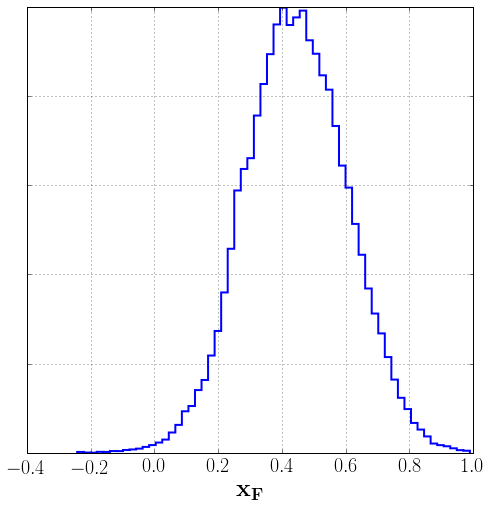

In [396]:
(xf_emc.get_all_dimuons('targetPos in [1,3,5,6,7]')
       .xF
       .hist(bins=60, normed=True, histtype='step', lw=2, figsize=[8,8],
             weights=unp.nominal_values(xf_emc.get_all_dimuons('targetPos in [1,3,5,6,7]').weight)))
_ = plt.yticks(visible=False)
_ = plt.xticks(fontsize=20)
plt.xlabel(r'$\mathbf{x_F}$', fontsize=25)
plt.savefig('figures/xF-dist.png')

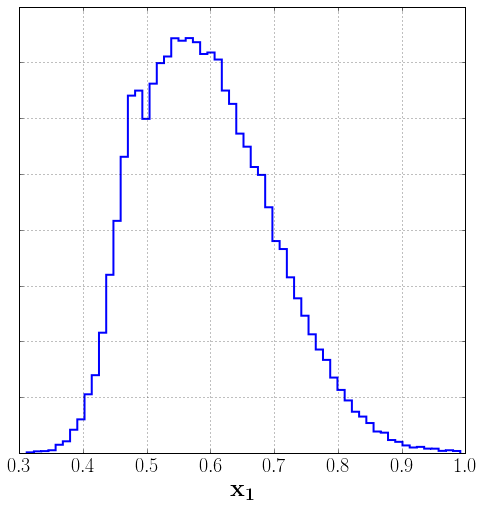

In [397]:
(xb_emc.get_all_dimuons('targetPos in [1,3,5,6,7]')
       .xB
       .hist(bins=60, normed=True, histtype='step', lw=2, figsize=[8,8],
             weights=unp.nominal_values(xb_emc.get_all_dimuons('targetPos in [1,3,5,6,7]').weight)))
_ = plt.yticks(visible=False)
_ = plt.xticks(fontsize=20)
plt.xlabel(r'$\mathbf{x_1}$', fontsize=25)
plt.savefig('figures/x1-dist.png')

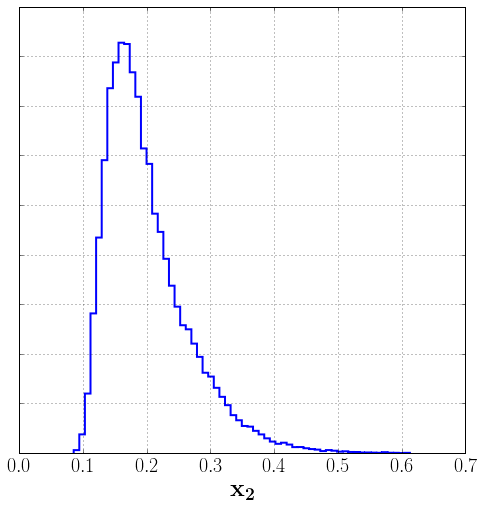

In [398]:
(xt_emc.get_all_dimuons('targetPos in [1,3,5,6,7]')
       .xT
       .hist(bins=60, normed=True, histtype='step', lw=2, figsize=[8,8],
             weights=unp.nominal_values(xt_emc.get_all_dimuons('targetPos in [1,3,5,6,7]').weight)))
_ = plt.yticks(visible=False)
_ = plt.xticks(fontsize=20)
plt.xlabel(r'$\mathbf{x_2}$', fontsize=25)
plt.tick_params()
#plt.savefig('figures/x2-dist.png')

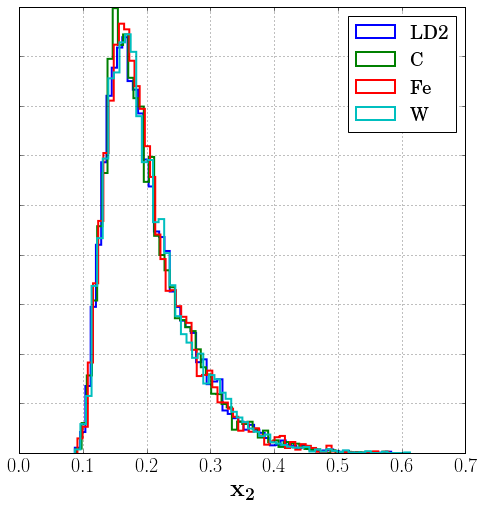

In [399]:
(xt_emc.get_all_dimuons('targetPos==3')
       .xT
       .hist(bins=60, normed=True, histtype='step', lw=2, figsize=[8,8],
             weights=unp.nominal_values(xt_emc.get_all_dimuons('targetPos==3').weight), label="LD2"))
(xt_emc.get_all_dimuons('targetPos==6')
       .xT
       .hist(bins=60, normed=True, histtype='step', lw=2, figsize=[8,8],
             weights=unp.nominal_values(xt_emc.get_all_dimuons('targetPos==6').weight), label="C"))
(xt_emc.get_all_dimuons('targetPos==5')
       .xT
       .hist(bins=60, normed=True, histtype='step', lw=2, figsize=[8,8],
             weights=unp.nominal_values(xt_emc.get_all_dimuons('targetPos==5').weight), label="Fe"))
(xt_emc.get_all_dimuons('targetPos==7')
       .xT
       .hist(bins=60, normed=True, histtype='step', lw=2, figsize=[8,8],
             weights=unp.nominal_values(xt_emc.get_all_dimuons('targetPos==7').weight), label="W"))

_ = plt.yticks(visible=False)
_ = plt.xticks(fontsize=20)
plt.legend(loc='upper right')
plt.xlabel(r'$\mathbf{x_2}$', fontsize=25)
plt.savefig('figures/x2-dist-targs.png')

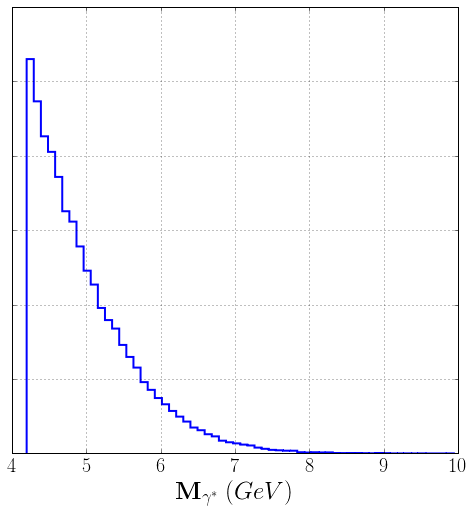

In [400]:
(mass_emc.get_all_dimuons('targetPos in [1,3,5,6,7]')
       .mass
       .hist(bins=60, normed=True, histtype='step', lw=2, figsize=[8,8],
             weights=unp.nominal_values(mass_emc.get_all_dimuons('targetPos in [1,3,5,6,7]').weight)))
_ = plt.yticks(visible=False)
_ = plt.xticks(fontsize=20)
plt.xlabel(r'$\mathbf{M_{\gamma^*}}\ (GeV)$', fontsize=25)
plt.savefig('figures/mass-dist.png')

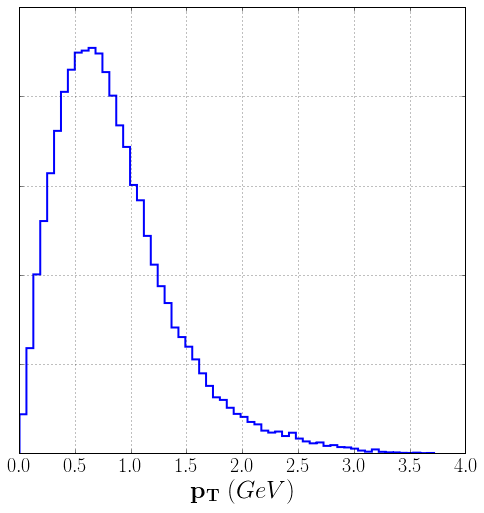

In [401]:
(pt_emc.get_all_dimuons('targetPos in [1,3,5,6,7]')
       .dpt
       .hist(bins=60, normed=True, histtype='step', lw=2, figsize=[8,8],
             weights=unp.nominal_values(pt_emc.get_all_dimuons('targetPos in [1,3,5,6,7]').weight)))
_ = plt.yticks(visible=False)
_ = plt.xticks(fontsize=20)
plt.xlabel(r'$\mathbf{p_T}\ (GeV)$', fontsize=25)
plt.savefig('figures/pt-dist.png')

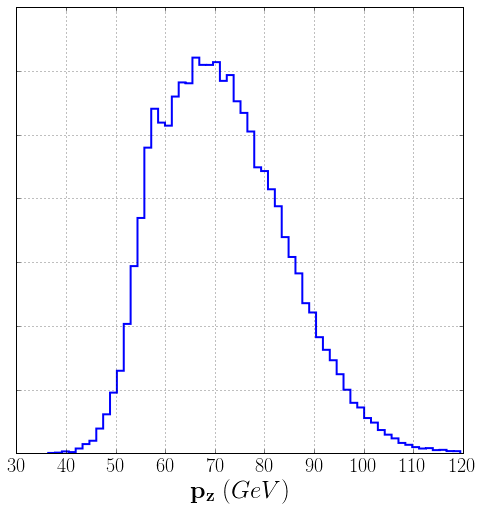

In [402]:
(pz_emc.get_all_dimuons('targetPos in [1,3,5,6,7]')
       .dpz
       .hist(bins=60, normed=True, histtype='step', lw=2, figsize=[8,8],
             weights=unp.nominal_values(pz_emc.get_all_dimuons('targetPos in [1,3,5,6,7]').weight)))
_ = plt.yticks(visible=False)
_ = plt.xticks(fontsize=20)
plt.xlabel(r'$\mathbf{p_z}\ (GeV)$', fontsize=25)
plt.savefig('figures/pz-dist.png')

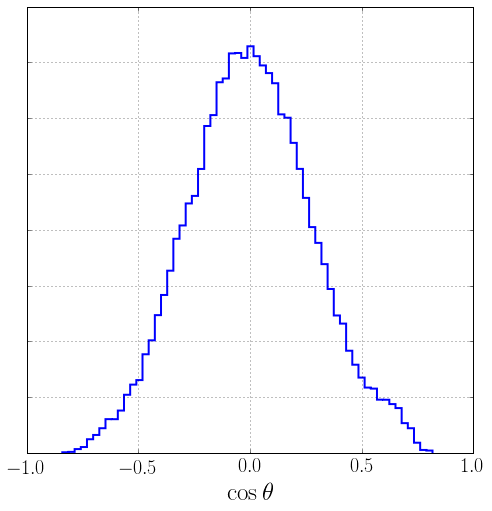

In [403]:
(costh_emc.get_all_dimuons('targetPos in [1,3,5,6,7]')
       .costh
       .hist(bins=60, normed=True, histtype='step', lw=2, figsize=[8,8],
             weights=unp.nominal_values(costh_emc.get_all_dimuons('targetPos in [1,3,5,6,7]').weight)))
_ = plt.yticks(visible=False)
_ = plt.xticks(fontsize=20)
plt.xlabel(r'$\mathbf{\cos\theta}$', fontsize=25)
plt.savefig('figures/costh-dist.png')

In [302]:
def my_round(x):
    return round(x,3)

In [303]:
print (my_emc.means
                   .ix['LD2']
                   .applymap(unp.nominal_values)
                   [['xB','xT','mass','xF','costh','phi','dpz','dpt','pz1','pz2','pt1','pt2']]
                   .applymap(my_round)
                   .to_latex())

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
{} &     xB &     xT &   mass &     xF &  costh &    phi &     dpz &    dpt &     pz1 &     pz2 &    pt1 &    pt2 \\
xT            &        &        &        &        &        &        &         &        &         &         &        &        \\
\midrule
(0.1, 0.13]   &  0.746 &  0.120 &  4.378 &  0.690 &  0.011 &  0.043 &  90.145 &  0.737 &  45.815 &  44.329 &  2.124 &  2.112 \\
(0.13, 0.16]  &  0.650 &  0.146 &  4.516 &  0.559 & -0.005 & -0.030 &  78.487 &  0.762 &  39.415 &  39.079 &  2.224 &  2.186 \\
(0.16, 0.195] &  0.592 &  0.177 &  4.751 &  0.467 & -0.011 & -0.008 &  71.473 &  0.805 &  35.833 &  35.641 &  2.365 &  2.305 \\
(0.195, 0.24] &  0.567 &  0.215 &  5.143 &  0.404 & -0.009 &  0.008 &  68.394 &  0.841 &  34.344 &  34.015 &  2.562 &  2.500 \\
(0.24, 0.29]  &  0.557 &  0.262 &  5.626 &  0.348 & -0.007 &  0.008 &  67.097 &  0.900 &  33.728 &  33.349 &  2.800 &  2.726 \\
(0.29, 0.35]  &  0.543 &  0.314 &  6.079 &  0.280 & -0.021 &  0.03

In [335]:
dimuon_df = my_emc.get_all_dimuons('targetPos in [1,3,5,6,7]').copy()
print 'x2', np.average(dimuon_df.xT.values,  weights=unp.nominal_values(dimuon_df.weight.values))
print 'x1', np.average(dimuon_df.xB,  weights=unp.nominal_values(dimuon_df.weight))
print 'xF', np.average(dimuon_df.xF,  weights=unp.nominal_values(dimuon_df.weight))
print 'mass', np.average(dimuon_df.mass,  weights=unp.nominal_values(dimuon_df.weight))
print 'pT', np.average(dimuon_df.dpt,  weights=unp.nominal_values(dimuon_df.weight))
print 'pz', np.average(dimuon_df.dpz,  weights=unp.nominal_values(dimuon_df.weight))
print 'costh', np.average(dimuon_df.costh, weights=unp.nominal_values(dimuon_df.weight))
print 'phi', np.average(dimuon_df.phi, weights=unp.nominal_values(dimuon_df.weight))
print 'pz1', np.average(dimuon_df.pz1, weights=unp.nominal_values(dimuon_df.weight))
print 'pz2', np.average(dimuon_df.pz2, weights=unp.nominal_values(dimuon_df.weight))
print 'pt1', np.average(dimuon_df.pt1, weights=unp.nominal_values(dimuon_df.weight))
print 'pt2', np.average(dimuon_df.pt2, weights=unp.nominal_values(dimuon_df.weight))
# $\phi_\mu$ &     $p_z$ &    $p_T$ &     $p_z^+$ &    $p_z^-$ &    $p_T^+$ &   $p_T^-$ 

x2 0.201068590193
x1 0.601475894511
xF 0.45327547772
mass 5.01152472395
pT 0.865010347294
pz 72.553431626
costh -0.00214541152472
phi 0.000539684532128
pz1 36.4447406097
pz2 36.1086910155
pt1 2.47236382227
pt2 2.44089875342


In [332]:
dimuon_df[np.isnan(unp.nominal_values(dimuon_df.weight.values))]

,dimuonID,runID,spillID,eventID,targetPos,posTrackID,negTrackID,dx,dy,dz,dpx,dpy,dpz,mass,xF,xB,xT,costh,phi,trackSeparation,chisq_dimuon,px1,py1,pz1,px2,py2,pz2,isValid,isTarget,isDump,QIESum,chamber_intensity,trigger_intensity,weight,dpt,pt1,pt2,target,roadset,weight_keff,weight_keff_sq,weight_bg,weight_bg_sq,weight_sq
94,2982,9054,311416,42297,2,26272,26273,-0.143481,0.152404,-77.594714,1.078571,0.258832,53.019268,6.525313,0.005875,0.441803,0.437068,0.017145,-0.616834,47.5,7.912895,3.602673,-1.075023,30.582546,-2.524102,1.333855,22.436721,1,1,0,1.180920e+11,29020.90,46893.60,None,1.109193,3.759645,2.854866,Empty,57,1.459963,2.131492,None,None,None
193,6605,9062,311878,101881,2,61803,61804,-0.244073,-0.013549,-189.586826,-0.687675,-0.189123,88.240730,5.323576,0.639630,0.730987,0.175613,0.119575,0.114849,17.5,5.017301,2.127791,0.899019,43.585455,-2.815466,-1.088142,44.655275,1,1,0,1.250680e+11,36722.40,92977.60,None,0.713207,2.309920,3.018427,Empty,57,1.486804,2.210587,None,None,None
289,988,9073,312362,14540,2,8849,8850,0.331703,-0.050955,-185.801875,0.393342,0.530793,55.844295,4.621630,0.284257,0.463371,0.207880,0.012344,-1.022485,-182.5,6.541797,2.502950,0.069062,30.321807,-2.109607,0.461732,25.522487,0,0,0,1.177960e+11,17267.10,34199.90,None,0.660651,2.503903,2.159546,Empty,57,1.245272,1.550701,None,None,None
523,8668,9092,313572,122264,2,76392,76393,0.224754,-0.116940,-221.768234,0.267317,-1.139569,66.455411,4.470216,0.418797,0.550827,0.171889,-0.172951,1.278510,-70.0,7.473509,2.333217,-0.726551,30.040851,-2.065900,-0.413018,36.414560,1,1,0,1.137340e+11,36459.80,54766.20,None,1.170502,2.443722,2.106781,Empty,57,1.482593,2.198083,None,None,None
534,5166,9093,313616,73397,2,45509,45510,0.056120,-0.115584,-157.402203,0.715304,0.735618,77.221473,7.660247,0.314183,0.641711,0.410601,0.104038,-0.351313,-2.5,3.206024,3.811865,2.040427,47.396957,-3.096561,-1.304809,29.824516,1,1,0,1.114470e+11,10096.10,14095.50,None,1.026057,4.323616,3.360241,Empty,57,1.140704,1.301206,None,None,None
632,729,9100,314122,9088,2,5880,5881,0.342087,0.187240,-212.514063,0.309734,0.426783,61.936757,4.870609,0.345647,0.513736,0.206640,0.053485,-0.516748,-172.5,11.499470,2.374248,1.227900,35.511539,-2.064514,-0.801117,26.425219,0,0,0,1.168980e+11,16468.80,33642.90,None,0.527332,2.672974,2.214499,Empty,57,1.232707,1.519566,None,None,None
654,6518,9102,314232,85429,2,54317,54316,-0.232739,0.162292,-164.063778,0.379877,0.518612,64.853673,5.379309,0.343179,0.538123,0.241046,-0.231624,-1.142219,102.5,4.285397,2.754872,-0.263129,26.497402,-2.374995,0.781741,38.356271,1,1,0,1.081490e+11,27972.70,19693.90,None,0.642857,2.767410,2.500344,Empty,57,1.278501,1.634564,None,None,None
669,6597,9103,314298,83458,2,53736,53737,0.094500,0.069975,-251.274608,-0.769381,-0.282607,60.611822,5.303895,0.288005,0.503142,0.252812,0.316993,-0.186164,-57.5,12.810194,2.121303,0.283680,35.527076,-2.890684,-0.566287,25.084747,0,1,0,1.081940e+11,17085.80,17408.10,None,0.819643,2.140187,2.945630,Empty,57,1.161912,1.350039,None,None,None
870,2472,9118,315134,33963,2,21298,21297,0.248838,-0.160520,-272.828442,0.277311,-0.571796,77.574424,4.261293,0.562507,0.642428,0.128971,-0.123497,1.171313,-115.0,13.589425,2.251451,-0.184147,36.247597,-1.974140,-0.387650,41.326826,0,0,0,1.216270e+11,24982.60,34165.10,None,0.635494,2.258969,2.011840,Empty,57,1.505781,2.267375,None,None,None
979,7520,9134,315750,103768,2,64566,64567,0.087026,-0.045058,-135.869167,-1.085170,0.974947,64.034970,5.555652,0.300468,0.531612,0.274041,0.335347,0.957810,-22.5,0.527435,2.043778,1.038980,38.040418,-3.128947,-0.064033,25.994552,1,1,0,1.202320e+11,29971.10,25328.20,None,1.458806,2.292708,3.129602,Empty,57,1.478164,2.184970,None,None,None


In [304]:
my_emc.get_all_dimuons().mean()

dimuonID             7.554312e+03
runID                1.289816e+04
spillID              5.085809e+05
eventID              8.476950e+04
targetPos            3.639350e+00
posTrackID           5.599918e+04
negTrackID           5.599916e+04
dx                   3.029844e-02
dy                   1.523328e-02
dz                  -1.443024e+02
dpx                  4.376364e-02
dpy                  7.564238e-02
dpz                  7.274469e+01
mass                 4.979604e+00
xF                   4.581464e-01
xB                   6.030312e-01
xT                   1.977350e-01
costh               -1.934117e-03
phi                  1.677106e-04
trackSeparation     -8.456172e+00
chisq_dimuon         4.271153e+00
px1                  2.198239e+00
py1                  3.260761e-02
pz1                  3.654281e+01
px2                 -2.154476e+00
py2                  4.303477e-02
pz2                  3.620187e+01
isValid              3.592376e-01
isTarget             8.432571e-01
isDump        

# Implement isoscalar correction!

In [175]:
my_emc.roadsets[57].means.ix['W'].xT

xT
(0.1, 0.13]      0.120+/-0.008
(0.13, 0.16]     0.146+/-0.009
(0.16, 0.195]    0.177+/-0.010
(0.195, 0.24]    0.216+/-0.013
(0.24, 0.29]     0.261+/-0.015
(0.29, 0.35]     0.314+/-0.016
(0.35, 0.45]     0.384+/-0.027
(0.45, 0.58]     0.467+/-0.015
Name: xT, dtype: object

In [169]:
sample = my_emc.roadsets[57].means.ix['W'].copy()
sample

,mass,dz,dpz,dpt,pz1,pz2,pt1,pt2,xF,xB,xT,costh,phi,trackSeparation,chisq_dimuon,QIESum,chamber_intensity,trigger_intensity,weight_keff,weight_keff_sq,raw_counts,w_counts,w_keff_counts,w_bg_counts,raw_counts_pp,w_counts_pp,w_keff_counts_pp,w_bg_counts_pp
xT,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"(0.1, 0.13]",4.35+/-0.15,(-1.5+/-0.4)e+02,89+/-7,0.7+/-0.4,43+/-11,46+/-11,2.12+/-0.30,2.10+/-0.34,0.68+/-0.07,0.74+/-0.06,0.120+/-0.008,-0.03+/-0.29,-0.1+/-0.9,(-1+/-8)e+01,3.7+/-3.1,(9.9+/-2.6)e+10,(2.5+/-1.4)e+04,(3.3+/-2.3)e+04,1.50+/-0.33,2.4+/-1.1,113+/-11,164+/-16,170+/-16,110+/-10,262+/-25,(3.8+/-0.4)e+02,(3.9+/-0.4)e+02,254+/-24
"(0.13, 0.16]",4.51+/-0.24,(-1.4+/-0.4)e+02,78+/-9,0.8+/-0.4,38+/-9,40+/-9,2.24+/-0.33,2.2+/-0.4,0.56+/-0.09,0.65+/-0.07,0.146+/-0.009,-0.04+/-0.26,0.1+/-0.9,(-1+/-8)e+01,3.9+/-3.2,(9.7+/-2.5)e+10,(2.5+/-1.4)e+04,(3.3+/-2.6)e+04,1.52+/-0.34,2.4+/-1.1,309+/-18,455+/-26,470+/-27,300+/-17,(7.2+/-0.4)e+02,(1.05+/-0.06)e+03,(1.09+/-0.06)e+03,(7.0+/-0.4)e+02
"(0.16, 0.195]",4.76+/-0.34,(-1.4+/-0.4)e+02,72+/-10,0.8+/-0.4,36+/-9,36+/-8,2.4+/-0.4,2.3+/-0.4,0.47+/-0.10,0.59+/-0.08,0.177+/-0.010,-0.03+/-0.25,-0.0+/-0.9,(-1+/-8)e+01,3.8+/-3.2,(9.8+/-2.5)e+10,(2.4+/-1.4)e+04,(3.0+/-2.1)e+04,1.5+/-0.4,2.5+/-1.3,420+/-20,619+/-31,639+/-32,408+/-20,(9.7+/-0.5)e+02,(1.44+/-0.07)e+03,(1.48+/-0.07)e+03,(9.5+/-0.5)e+02
"(0.195, 0.24]",5.1+/-0.4,(-1.4+/-0.4)e+02,68+/-11,0.9+/-0.5,34+/-9,34+/-8,2.6+/-0.4,2.5+/-0.4,0.40+/-0.12,0.57+/-0.09,0.216+/-0.013,-0.01+/-0.25,0.0+/-0.9,(-0+/-8)e+01,3.7+/-2.9,(9.6+/-2.6)e+10,(2.5+/-1.4)e+04,(3.4+/-2.7)e+04,1.6+/-0.4,2.9+/-1.6,288+/-17,456+/-28,472+/-29,280+/-16,(6.7+/-0.4)e+02,(1.06+/-0.06)e+03,(1.09+/-0.07)e+03,(6.5+/-0.4)e+02
"(0.24, 0.29]",5.6+/-0.5,(-1.4+/-0.4)e+02,67+/-11,1.1+/-0.6,33+/-8,35+/-10,2.8+/-0.5,2.7+/-0.5,0.35+/-0.12,0.56+/-0.09,0.261+/-0.015,-0.03+/-0.27,-0.0+/-0.9,(0+/-8)e+01,4.2+/-3.1,(9.3+/-2.6)e+10,(2.3+/-1.4)e+04,(2.9+/-2.3)e+04,1.6+/-0.5,2.9+/-1.8,153+/-12,242+/-20,250+/-21,149+/-12,355+/-29,(5.6+/-0.5)e+02,(5.8+/-0.5)e+02,345+/-28
"(0.29, 0.35]",6.1+/-0.6,-137+/-35,65+/-12,0.9+/-0.5,33+/-9,32+/-8,3.0+/-0.5,3.0+/-0.5,0.28+/-0.13,0.54+/-0.10,0.314+/-0.016,0.02+/-0.22,0.0+/-0.9,(-0+/-7)e+01,3.8+/-2.9,(8.9+/-2.5)e+10,(2.2+/-1.4)e+04,(3.2+/-2.9)e+04,1.7+/-0.6,3.4+/-2.6,95+/-10,160+/-17,165+/-18,92+/-9,220+/-23,(3.7+/-0.4)e+02,(3.8+/-0.4)e+02,214+/-22
"(0.35, 0.45]",6.6+/-0.6,-136+/-32,63+/-11,1.1+/-0.7,33+/-7,31+/-9,3.2+/-0.6,3.3+/-0.6,0.18+/-0.13,0.53+/-0.09,0.384+/-0.027,0.05+/-0.27,0.2+/-0.9,(2+/-7)e+01,4+/-4,(9.8+/-2.7)e+10,(2.5+/-1.3)e+04,(3.7+/-2.9)e+04,2.0+/-0.7,4+/-4,31+/-6,59+/-11,62+/-12,30+/-5,72+/-13,138+/-26,143+/-27,70+/-13
"(0.45, 0.58]",7.2+/-0.5,-127+/-11,60+/-10,0.71+/-0.32,32+/-12,28.7+/-2.6,3.5+/-0.5,3.73+/-0.18,0.05+/-0.13,0.50+/-0.08,0.467+/-0.015,0.06+/-0.13,0.0+/-1.0,(3+/-9)e+01,4.5+/-3.0,(1.10+/-0.24)e+11,(2.1+/-1.7)e+04,(3.2+/-1.9)e+04,2.2+/-1.3,6+/-8,5.0+/-2.2,10+/-5,11+/-6,4.9+/-2.2,12+/-5,24+/-12,25+/-13,11+/-5


In [161]:
sample['W/D'].values*R_ISO(unp.nominal_values(sample['xT'].values), 184.0, 74.0)[0]

array([0.8980201734930834+/-0.10325446168284468,
       0.8968696532465152+/-0.06253189832819407,
       1.0789702423662804+/-0.06642834176578775,
       0.9786343009868578+/-0.07179272058046009,
       0.9363416250838247+/-0.0949853108909193,
       1.097226370332572+/-0.14741716739882713,
       0.8385004333580469+/-0.18691786937443633,
       0.7759074578514902+/-0.4511747232670065], dtype=object)

In [162]:
sample.loc[:]['W/D'] = sample['W/D'].values*R_ISO(unp.nominal_values(sample['xT'].values), 184.0, 74.0)[0]

In [163]:
sample

,xT,D/H,C/D,Fe/D,W/D,C/H,Fe/H,W/H,Fe/C,W/C
"(0.1, 0.13]",0.120+/-0.007,0.59+/-0.05,1.00+/-0.11,1.09+/-0.13,0.90+/-0.10,1.24+/-0.13,1.35+/-0.16,1.09+/-0.13,1.08+/-0.14,0.88+/-0.11
"(0.13, 0.16]",0.146+/-0.008,0.602+/-0.032,0.97+/-0.06,0.99+/-0.07,0.90+/-0.06,1.24+/-0.08,1.27+/-0.09,1.12+/-0.08,1.02+/-0.08,0.90+/-0.07
"(0.16, 0.195]",0.176+/-0.010,0.580+/-0.029,1.03+/-0.06,1.10+/-0.07,1.08+/-0.07,1.26+/-0.08,1.35+/-0.09,1.29+/-0.08,1.07+/-0.08,1.03+/-0.07
"(0.195, 0.24]",0.215+/-0.013,0.596+/-0.034,0.96+/-0.07,1.06+/-0.08,0.98+/-0.07,1.21+/-0.09,1.34+/-0.10,1.20+/-0.09,1.10+/-0.09,0.99+/-0.08
"(0.24, 0.29]",0.262+/-0.014,0.59+/-0.05,0.96+/-0.09,0.92+/-0.10,0.94+/-0.09,1.19+/-0.12,1.15+/-0.12,1.12+/-0.11,0.96+/-0.12,0.94+/-0.11
"(0.29, 0.35]",0.314+/-0.017,0.60+/-0.07,0.85+/-0.12,1.24+/-0.17,1.10+/-0.15,1.08+/-0.15,1.57+/-0.21,1.33+/-0.18,1.46+/-0.23,1.24+/-0.19
"(0.35, 0.45]",0.387+/-0.028,0.81+/-0.14,0.90+/-0.18,1.01+/-0.23,0.84+/-0.19,1.57+/-0.33,1.8+/-0.4,1.38+/-0.32,1.12+/-0.28,0.88+/-0.22
"(0.45, 0.58]",0.478+/-0.022,0.9+/-0.4,0.20+/-0.15,1.1+/-0.6,0.8+/-0.5,0.40+/-0.32,2.2+/-1.4,1.4+/-0.9,6+/-5,3.6+/-3.2


In [117]:
R_ISO(0.126260, 184, 74)

(array([ 1.01920496]), array([  3.75587313e-07]))

In [119]:
1.01920496*1.2237

1.247201109552

In [116]:
sample

,xT,weight
0,0.126260,1.2237+/-0.0013
13,0.192618,1.1393+/-0.0015
19,0.188374,1.4939+/-0.0007
20,0.193402,1.1086+/-0.0015
33,0.162267,1.66316+/-0.00020


In [105]:
R_ISO(0.3, 183.2, 74)[0][0]

1.0420499818885749

In [87]:
my_emc.roadsets[57].dimuons.data[my_emc.roadsets[57].dimuons.data.isnull().any(axis=1)].query('target not in ["None", "Empty"]')

,dimuonID,runID,spillID,eventID,targetPos,posTrackID,negTrackID,dx,dy,dz,dpx,dpy,dpz,mass,xF,xB,xT,costh,phi,trackSeparation,chisq_dimuon,px1,py1,pz1,px2,py2,pz2,isValid,isTarget,isDump,QIESum,chamber_intensity,trigger_intensity,weight,dpt,pt1,pt2,weight_keff,target,roadset,weight_keff_sq,weight_bg,weight_bg_sq,weight_sq


In [68]:
my_emc.calc_bg_curve()

(1.7788423710885197e-09+/-2.5810070365814276e-10,
 1.1308449177278926e-09+/-3.3728203969555135e-10,
 1.1219959212998503e-09+/-2.99062545199935e-10,
 1.5735700638809205e-09+/-7.562470876155943e-10)

In [69]:
my_emc.roadsets[57].calc_bg_const(1.1308449e-9, 1.57357e-9)

In [70]:
my_emc.roadsets[57].B

{1: nan,
 3: nan,
 5: 0.010956727435228126,
 6: 0.026086904560105515,
 7: 0.0085395638554294651}

# Implement Contam Correction!

In [61]:
h = my_emc.roadsets[57].means.ix['LH2']['w_counts_pp']
h = h/my_emc.roadsets[57].spills.live_p.ix['LH2']['liveProton_x10^16']
d = my_emc.roadsets[57].means.ix['LD2']['w_counts_pp']
d = d/my_emc.roadsets[57].spills.live_p.ix['LD2']['liveProton_x10^16']
#d = d/0.904 - (1-0.904)/0.904 * h
d = d/target_roadset_dict[57].ix['LD2'].Scale
h = h/target_roadset_dict[57].ix['LH2'].Scale
print d/(2*h)

xT
(0.1, 0.13]      1.26+/-0.12
(0.13, 0.16]     1.29+/-0.07
(0.16, 0.195]    1.24+/-0.06
(0.195, 0.24]    1.28+/-0.08
(0.24, 0.29]     1.26+/-0.10
(0.29, 0.35]     1.28+/-0.14
(0.35, 0.45]     1.77+/-0.32
(0.45, 0.58]       2.0+/-1.0
Name: w_counts_pp, dtype: object


In [14]:
my_means = my_emc.roadsets[57].means.copy()

In [18]:
my_means.loc[['LD2']]['w_counts_pp']

target  xT           
LD2     (0.1, 0.13]      173+/-10
        (0.13, 0.16]     480+/-18
        (0.16, 0.195]    547+/-19
        (0.195, 0.24]    446+/-18
        (0.24, 0.29]     249+/-14
        (0.29, 0.35]     141+/-11
        (0.35, 0.45]       69+/-8
        (0.45, 0.58]       13+/-4
Name: w_counts_pp, dtype: object

In [299]:
target_df.ix['LD2']

TargetPos             3.000000e+00
Density[g/cm^3]       1.545000e-01
Length[cm]            5.080000e+01
LengthPerLayer[cm]    5.080000e+01
NLayers               1.000000e+00
NIL[g/cm^2]           6.930000e+01
NIL/D[cm]             4.485437e+02
MassNo[g/mol]         1.917510e+00
Density[/cm^3]        4.852235e+22
Density[mol/cm^3]     8.057324e-02
IntLengths            1.132554e-01
AttenLength[cm]       4.802891e+01
Scale                 7.420466e+00
Name: LD2, dtype: float64

In [9]:
from targets import target_dict

In [17]:
new_dict = {57: pd.DataFrame(target_dict).T, 62: pd.DataFrame(target_dict).T}

In [18]:
new_dict[62]

,A,density,layers,length,scale,targpos
C,12.0107,9.035000e+22,3.0,3.2090,3.482300e+24,6.0
Empty,NaN,NaN,NaN,NaN,NaN,2.0
Fe,55.8450,8.491000e+22,3.0,1.8010,8.539980e+24,5.0
LD2,2.0000,4.835000e+22,1.0,48.0020,4.674518e+24,3.0
LH2,1.0000,4.221000e+22,1.0,49.0870,2.088331e+24,1.0
None,NaN,NaN,NaN,NaN,NaN,4.0
W,183.8400,6.322000e+22,3.0,0.9083,1.055659e+25,7.0


In [12]:
pd.DataFrame(target_dict).T

,A,density,layers,length,scale,targpos
C,12.0107,9.035000e+22,3.0,3.2090,3.482300e+24,6.0
Empty,NaN,NaN,NaN,NaN,NaN,2.0
Fe,55.8450,8.491000e+22,3.0,1.8010,8.539980e+24,5.0
LD2,2.0000,4.835000e+22,1.0,48.0020,4.674518e+24,3.0
LH2,1.0000,4.221000e+22,1.0,49.0870,2.088331e+24,1.0
None,NaN,NaN,NaN,NaN,NaN,4.0
W,183.8400,6.322000e+22,3.0,0.9083,1.055659e+25,7.0


In [301]:
my_emc.roadsets[57].means.ix['LH2']

,mass,dz,dpz,dpt,pz1,pz2,pt1,pt2,xF,xB,xT,costh,phi,trackSeparation,chisq_dimuon,QIESum,chamber_intensity,trigger_intensity,weight_keff,weight_keff_sq,raw_counts,w_counts,w_keff_counts,w_bg_counts,raw_counts_pp,w_counts_pp,w_keff_counts_pp,w_bg_counts_pp
xT,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"(0.1, 0.13]",4.37+/-0.13,(-1.5+/-0.6)e+02,89+/-8,0.7+/-0.4,45+/-12,44+/-12,2.15+/-0.32,2.07+/-0.34,0.68+/-0.08,0.74+/-0.06,0.120+/-0.007,-0.00+/-0.30,0.0+/-0.9,(-0+/-9)e+01,5+/-4,(9.8+/-2.5)e+10,(2.7+/-1.5)e+04,(3.7+/-2.9)e+04,1.51+/-0.35,2.4+/-1.2,240+/-15,269+/-17,364+/-24,184+/-12,60+/-4,67+/-4,90+/-6,45.7+/-3.0
"(0.13, 0.16]",4.52+/-0.24,(-1.5+/-0.5)e+02,79+/-9,0.8+/-0.4,39+/-10,39+/-9,2.26+/-0.34,2.2+/-0.4,0.56+/-0.09,0.65+/-0.07,0.146+/-0.009,-0.02+/-0.26,-0.0+/-0.9,(-0+/-9)e+01,4.4+/-3.5,(9.8+/-2.5)e+10,(2.5+/-1.5)e+04,(3.2+/-2.5)e+04,1.46+/-0.32,2.2+/-1.1,662+/-26,732+/-29,(9.7+/-0.4)e+02,516+/-20,164+/-6,182+/-7,240+/-10,128+/-5
"(0.16, 0.195]",4.74+/-0.34,(-1.5+/-0.5)e+02,71+/-10,0.8+/-0.5,36+/-9,35+/-8,2.4+/-0.4,2.3+/-0.4,0.47+/-0.11,0.59+/-0.09,0.176+/-0.010,-0.00+/-0.25,-0.0+/-0.9,(-1+/-8)e+01,4.2+/-3.5,(9.6+/-2.5)e+10,(2.4+/-1.4)e+04,(3.1+/-2.6)e+04,1.46+/-0.33,2.2+/-1.1,779+/-28,866+/-31,(1.14+/-0.04)e+03,611+/-22,193+/-7,215+/-8,282+/-10,152+/-5
"(0.195, 0.24]",5.1+/-0.4,(-1.4+/-0.4)e+02,68+/-11,0.9+/-0.6,34+/-9,34+/-8,2.6+/-0.4,2.4+/-0.5,0.40+/-0.11,0.57+/-0.09,0.215+/-0.012,-0.03+/-0.26,0.0+/-0.8,(-0+/-8)e+01,4+/-4,(9.6+/-2.5)e+10,(2.4+/-1.5)e+04,(3.3+/-2.8)e+04,1.5+/-0.4,2.5+/-1.3,591+/-24,687+/-28,(9.1+/-0.4)e+02,462+/-19,147+/-6,171+/-7,226+/-10,115+/-5
"(0.24, 0.29]",5.6+/-0.5,(-1.4+/-0.4)e+02,68+/-12,1.0+/-0.6,33+/-9,34+/-9,2.8+/-0.5,2.7+/-0.5,0.36+/-0.13,0.56+/-0.10,0.261+/-0.014,-0.03+/-0.28,0.0+/-0.8,(-0+/-7)e+01,4.0+/-3.3,(9.7+/-2.5)e+10,(2.5+/-1.5)e+04,(3.3+/-2.9)e+04,1.6+/-0.5,2.9+/-1.9,320+/-18,389+/-22,525+/-31,248+/-14,79+/-4,97+/-5,130+/-8,61.6+/-3.5
"(0.29, 0.35]",6.1+/-0.5,-137+/-35,65+/-12,1.0+/-0.7,33+/-9,33+/-9,2.9+/-0.6,3.0+/-0.5,0.28+/-0.13,0.54+/-0.10,0.314+/-0.016,0.01+/-0.27,-0.1+/-0.9,(-1+/-8)e+01,4+/-4,(9.6+/-2.5)e+10,(2.2+/-1.4)e+04,(3.1+/-3.0)e+04,1.7+/-0.5,3.0+/-2.1,171+/-13,217+/-17,283+/-23,136+/-10,42.5+/-3.2,54+/-4,70+/-6,33.8+/-2.6
"(0.35, 0.45]",6.7+/-0.7,(-1.4+/-0.4)e+02,64+/-12,1.0+/-0.7,32+/-8,33+/-10,3.4+/-0.5,3.2+/-0.6,0.20+/-0.14,0.53+/-0.10,0.382+/-0.026,-0.03+/-0.25,-0.3+/-0.9,(0+/-8)e+01,4.6+/-3.5,(9.4+/-2.5)e+10,(2.3+/-1.7)e+04,(3.3+/-3.1)e+04,1.8+/-0.7,3.8+/-3.2,58+/-8,77+/-10,105+/-15,45+/-6,14.4+/-1.9,19.2+/-2.6,26+/-4,11.3+/-1.5
"(0.45, 0.58]",7.4+/-0.8,(-1.4+/-0.4)e+02,62+/-13,1.6+/-1.0,37+/-12,26+/-4,3.3+/-1.1,3.8+/-0.8,0.03+/-0.17,0.52+/-0.11,0.50+/-0.04,0.21+/-0.27,0.2+/-0.5,(1+/-7)e+01,7+/-6,(9.1+/-3.0)e+10,(2.7+/-1.9)e+04,(5+/-5)e+04,2.4+/-1.3,7+/-8,8.0+/-2.8,13+/-5,19+/-8,6.0+/-2.2,2.0+/-0.7,3.2+/-1.2,4.7+/-1.9,1.5+/-0.5


# Plot Yields per Trigger Proton After Corrections!

In [252]:
from scipy import stats

In [255]:
target_df = target_roadset_dict['all']
lh2_set = my_emc.get_all_dimuons('target=="LH2"').copy()
ld2_set = my_emc.get_all_dimuons('target=="LD2"').copy()

In [256]:
lh2_cuts = [pd.cut(lh2_set.chamber_intensity,
              [0,10000,20000,30000,40000,50000,60000])]
ld2_cuts = [pd.cut(ld2_set.chamber_intensity,
              [0,10000,20000,30000,40000,50000,60000])]

lh2_counts = unp.nominal_values(lh2_set.groupby(by=lh2_cuts).weight.sum())
ld2_counts = unp.nominal_values(ld2_set.groupby(by=ld2_cuts).weight.sum())
lh2_unc = np.sqrt(unp.nominal_values(lh2_set.groupby(by=lh2_cuts).weight_sq.sum()))
ld2_unc = np.sqrt(unp.nominal_values(ld2_set.groupby(by=ld2_cuts).weight_sq.sum()))

raw_lh2_counts = unp.nominal_values(lh2_set.groupby(by=lh2_cuts).weight.count())
raw_ld2_counts = unp.nominal_values(ld2_set.groupby(by=ld2_cuts).weight.count())
raw_lh2_unc = np.sqrt(raw_lh2_counts)
raw_ld2_unc = np.sqrt(raw_ld2_counts)

In [243]:
nim_trig_int = pd.read_csv('nim_trig_int.csv',
            header=None,
            names=['chamber_intensity', 'trigger_intensity'],
            index_col='chamber_intensity'
           )

In [257]:
raw_r_dh = (((unp.uarray(raw_ld2_counts, raw_ld2_unc)/my_emc.get_all_livep().ix['LD2']['liveProton_x10^16'])/target_df.ix['LD2'].Scale) /
         ((unp.uarray(raw_lh2_counts, raw_lh2_unc)/my_emc.get_all_livep().ix['LH2']['liveProton_x10^16'])/target_df.ix['LH2'].Scale))

In [258]:
r_dh = (((unp.uarray(ld2_counts, ld2_unc)/my_emc.get_all_livep().ix['LD2']['liveProton_x10^16'])/target_df.ix['LD2'].Scale) /
         ((unp.uarray(lh2_counts, lh2_unc)/my_emc.get_all_livep().ix['LH2']['liveProton_x10^16'])/target_df.ix['LH2'].Scale))
x = [5000,15000,25000,35000,45000,55000]
y = unp.nominal_values(r_dh)
yerr = unp.std_devs(r_dh)
raw_y = unp.nominal_values(raw_r_dh)
raw_yerr = unp.std_devs(raw_r_dh)

In [245]:
def line_func(x, p0, p1):
    return np.add(p0,np.multiply(p1,x))

In [259]:
popt, pcov = curve_fit(line_func, x, y, p0=[1.2, 0.0], sigma=yerr)
raw_popt, raw_pcov = curve_fit(line_func, x, raw_y, p0=[1.2, 0.0], sigma=raw_yerr)

In [260]:
popt[1]

-4.3345238903147409e-07

In [248]:
pcov[1,1]**0.5

9.4988566833734665e-07

In [261]:
p0 = popt[0]
p1 = popt[1]
linx = np.arange(0,60000,10)
linval = line_func(linx, p0, p1)
raw_linval = line_func(linx, raw_popt[0], raw_popt[1])

In [262]:
def get_confidence(x, y, p0, p1):
    # predict y values of origional data using the fit
    p_y = line_func(x, p0, p1)

    # calculate the y-error (residuals)
    y_err = y - p_y

    # create series of new test x-values to predict for
    p_x = np.arange(0,np.max(x)+5000,100)

    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(x)                 # mean of x
    n = len(x)                          # number of samples in origional fit
    t = stats.t.ppf(1-0.025, n)         # appropriate t value (with n, two tailed 95%)
    s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals

    confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/
                ((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))

    # now predict y based on test x-values
    p_y = line_func(p_x, p0, p1)

    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - abs(confs)
    upper = p_y + abs(confs)

    return p_x, lower, upper

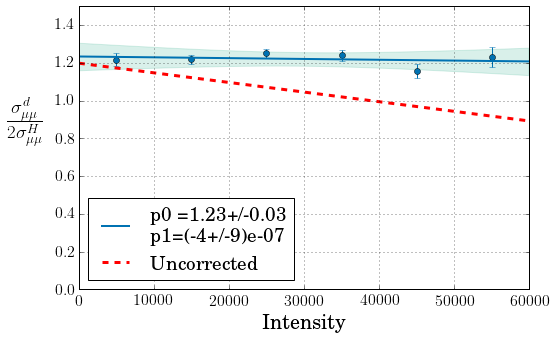

In [360]:
fig, ax = plt.subplots(1, figsize=(8, 5))
ax.errorbar(x, y, yerr=yerr, color=colors[0], fmt='o')
plt.fill_between(*get_confidence(x, y, p0, p1), alpha=0.15, color=colors[1])
ax.plot(linx, linval, color=colors[0], lw=2,
        label="p0 ={:.02f}+/-{:.02f}\n p1={:.1ue}".format(p0, pcov[0,0]**0.5, unc.ufloat(p1, pcov[1,1]**0.5)))
ax.plot(linx, raw_linval, color='r', ls='--', lw=3, label='Uncorrected')#,
        #label="p0 ={:.02f}+/-{:.02f}\n p1={:.1ue}".format(p0, pcov[0,0]**0.5, unc.ufloat(p1, pcov[1,1]**0.5)))

# Axis Labels
ax.grid()
ax.set_ylabel(r'$\frac{\sigma^d_{\mu\mu}}{2\sigma^H_{\mu\mu}}$', rotation=0, fontsize=27)
ax.set_xlabel(r'Intensity', fontsize=20)
ax.yaxis.labelpad = 30
t = ax.yaxis.get_offset_text()
t.set_size(16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.ylim([0,1.5])
plt.legend(loc='lower left')
fig.set_tight_layout(True)

fig.savefig('remaining-rate-dep.png')

In [247]:
pcov

array([[  6.93968549e-04,  -2.12139406e-08],
       [ -2.12139406e-08,   8.52241526e-13]])

In [248]:
popt

array([  1.19320100e+00,   7.27929937e-07])

In [76]:
dimuon_set = my_emc.get_all_dimuons('target=="LD2"').copy()

In [192]:
dimuon_set.chamber_intensity.mean()

24762.877426721054

In [80]:
cuts = []
cuts.append(pd.cut(dimuon_set.chamber_intensity,
            [0,10000,20000,30000,40000,50000,60000]))
int_counts = unp.nominal_values(dimuon_set.groupby(by=cuts).weight.sum())
int_unc = np.sqrt(unp.nominal_values(dimuon_set.groupby(by=cuts).weight_sq.sum()))

In [81]:
nim_trig_int = pd.read_csv('nim_trig_int.csv',
            header=None,
            names=['chamber_intensity', 'trigger_intensity'],
            index_col='chamber_intensity'
           )

In [82]:
x = [5000,15000,25000,35000,45000,55000]
y = (int_counts/nim_trig_int.trigger_intensity[:6]).values
yerr = int_unc/nim_trig_int.trigger_intensity[:6]

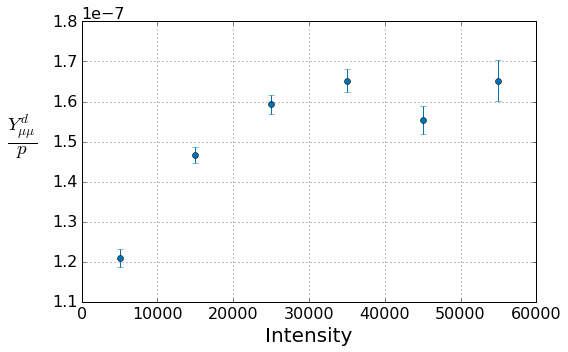

In [83]:
fig, ax = plt.subplots(1, figsize=(8, 5))
ax.errorbar(x, y, yerr=yerr, color=colors[0], fmt='o')
# Axis Labels
ax.grid()
ax.set_ylabel(r'$\frac{Y^d_{\mu\mu}}{p}$', rotation=0, fontsize=27)
ax.set_xlabel(r'Intensity', fontsize=20)
ax.yaxis.labelpad = 30
t = ax.yaxis.get_offset_text()
t.set_size(16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
fig.set_tight_layout(True)
fig.savefig('rate-dep-after-corr.png', dpi=1500)

In [238]:
cuts = []
binnum = 3
cuts.append(pd.qcut(dimuon_set.xT,binnum))
cuts.append(pd.cut(dimuon_set.chamber_intensity,
            [0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000]))
int_xT_counts = dimuon_set.groupby(by=cuts).weight.sum().apply(unp.nominal_values)
int_xT_unc = np.sqrt(dimuon_set.groupby(by=cuts).weight_sq.sum().apply(unp.nominal_values))

In [239]:
colors = [(0.0, 0.4470588235294118, 0.6980392156862745),
          (0.0, 0.6196078431372549, 0.45098039215686275),
          (0.8352941176470589, 0.3686274509803922, 0.0)]
#colors = [(0.2823529411764706, 0.47058823529411764, 0.8117647058823529),
#          (0.41568627450980394, 0.8, 0.396078431372549),
#          (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
#          (0.7058823529411765, 0.48627450980392156, 0.7803921568627451)]

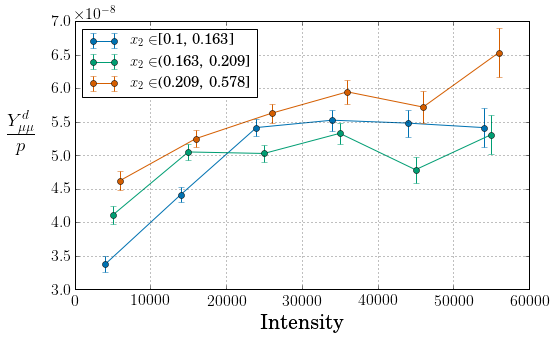

In [361]:
fig, ax = plt.subplots(1, figsize=(8, 5))

i = 0
offset = -1000
for index in int_xT_counts.index.levels[0]:
    x = [5000,15000,25000,35000,45000,55000]
    y = (int_xT_counts.ix[index].values/nim_trig_int.trigger_intensity[:6]).values
    yerr = (int_xT_unc.ix[index].values/nim_trig_int.trigger_intensity[:6]).values
    ax.errorbar(np.add(x,offset+i*1000), y, yerr=yerr, color=colors[i], fmt='-o', label=(r'$x_2\in$%s'%index))
    i += 1
    
# Axis Labels
ax.grid()
ax.set_ylabel(r'$\frac{Y^d_{\mu\mu}}{p}$', rotation=0, fontsize=27)
ax.set_xlabel(r'Intensity', fontsize=20)
ax.legend(loc='best', fontsize=15)
ax.yaxis.labelpad = 30
t = ax.yaxis.get_offset_text()
t.set_size(16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
fig.set_tight_layout(True)
fig.show()
fig.savefig('rate-dep-x2-after-corr.png')

# Plot the BG Curves!

In [363]:
from scipy import stats

In [364]:
x, y_e, y_e_err, y_n, y_n_err = my_emc.get_bg()
xx = np.arange(0, 60000, 10)
p0_e, p1_e, p0_n, p1_n = my_emc.calc_bg_curve()

e_curve = unc.nominal_value(p0_e) * (1.0 + unc.nominal_value(p1_e) * np.square(xx))
n_curve = unc.nominal_value(p0_n) * (1.0 + unc.nominal_value(p1_n) * np.square(xx))

In [365]:
colors = [(0.0, 0.4470588235294118, 0.6980392156862745),
          (0.0, 0.6196078431372549, 0.45098039215686275),
          (0.8352941176470589, 0.3686274509803922, 0.0)]

In [366]:
def bg_func(x, p0, p1):
    return p0 * (1.0 + p1 * np.square(x))

In [367]:
def get_confidence(x, y, p0, p1):
    # predict y values of origional data using the fit
    p_y = bg_func(x, p0, p1)

    # calculate the y-error (residuals)
    y_err = y - p_y

    # create series of new test x-values to predict for
    p_x = np.arange(0,np.max(x)+5000,100)

    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(x)                 # mean of x
    n = len(x)                          # number of samples in origional fit
    t = stats.t.ppf(1-0.025, n)         # appropriate t value (with n, two tailed 95%)
    s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals

    confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/
                ((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))

    # now predict y based on test x-values
    p_y = bg_func(p_x, p0, p1)

    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - abs(confs)
    upper = p_y + abs(confs)

    return p_x, lower, upper

In [368]:
print p1_e, p1_n

(8.0+/-2.1)e-10 (8.7+/-1.5)e-10


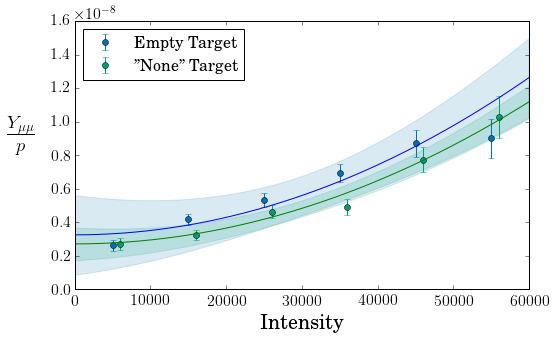

In [370]:
fig, ax = plt.subplots(1, figsize=(8,5))
plt.errorbar(x, y_e, yerr=y_e_err, label="Empty Target", c=colors[0], fmt='o')
plt.errorbar(np.add(x,1000.0), y_n, yerr=y_n_err, label="\"None\" Target", c=colors[1], fmt='o')
plt.plot(xx, e_curve, c='b', lw=1)
plt.plot(xx, n_curve, c='g', lw=1)
plt.fill_between(*get_confidence(x, y_e, unc.nominal_value(p0_e),
                                 unc.nominal_value(p1_e)),
                 alpha=0.15,
                 color=colors[0])
plt.fill_between(*get_confidence(x, y_n, unc.nominal_value(p0_n), unc.nominal_value(p1_n)), alpha=0.15, color=colors[1])

#ax.grid()
ax.set_ylabel(r'$\frac{Y_{\mu\mu}}{p}$', rotation=0, fontsize=27)
ax.set_xlabel(r'Intensity', fontsize=20)
ax.legend(loc='upper left', numpoints=1, fontsize=16)
ax.yaxis.labelpad = 30
t = ax.yaxis.get_offset_text()
t.set_size(16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
fig.set_tight_layout(True)
fig.show()
fig.savefig('rate-dep-empty.png')

In [21]:
my_emc.roadsets[67].B

{1: 0.09536522286965768+/-0.011289914829445306,
 3: 0.03904807992205541+/-0.00452192126656747,
 5: 0.01813323662176635+/-0.0017279107472038867,
 6: 0.04315853292516982+/-0.004077880970908107,
 7: 0.015137049532524227+/-0.0014450282772938041}

# Print Out Raw Yields!

In [170]:
print pd.concat([my_emc.roadsets[57].means.raw_counts.apply(unc.nominal_value).apply(int),
           my_emc.roadsets[62].means.raw_counts.apply(unc.nominal_value).apply(int),
           my_emc.roadsets[67].means.raw_counts.apply(unc.nominal_value).apply(int)], axis=1).to_latex()

                      raw_counts  raw_counts  raw_counts
target xT                                               
C      (0.1, 0.13]           143         109         357
       (0.13, 0.16]          358         349         990
       (0.16, 0.195]         439         470        1147
       (0.195, 0.24]         326         374         853
       (0.24, 0.29]          167         213         507
       (0.29, 0.35]           84         100         219
       (0.35, 0.45]           42          41         127
       (0.45, 0.58]            2           8          10
Fe     (0.1, 0.13]           112         145         358
       (0.13, 0.16]          279         398        1075
       (0.16, 0.195]         345         509        1284
       (0.195, 0.24]         262         411        1020
       (0.24, 0.29]          125         212         564
       (0.29, 0.35]           90          94         274
       (0.35, 0.45]           32          41         138
       (0.45, 0.58]            

# Print Out kEff Corrected Yields!

In [175]:
print pd.concat([my_emc.roadsets[57].means.w_keff_counts.apply(unc.nominal_value).apply(int),
           my_emc.roadsets[62].means.w_keff_counts.apply(unc.nominal_value).apply(int),
           my_emc.roadsets[67].means.w_keff_counts.apply(unc.nominal_value).apply(int)], axis=1).to_latex()

\begin{tabular}{llrrr}
\toprule
  &             &  w\_keff\_counts &  w\_keff\_counts &  w\_keff\_counts \\
target & xT &                &                &                \\
\midrule
C & (0.1, 0.13] &            203 &            155 &            513 \\
  & (0.13, 0.16] &            547 &            549 &           1559 \\
  & (0.16, 0.195] &            653 &            717 &           1779 \\
  & (0.195, 0.24] &            502 &            583 &           1321 \\
  & (0.24, 0.29] &            282 &            339 &            822 \\
  & (0.29, 0.35] &            139 &            167 &            384 \\
  & (0.35, 0.45] &             72 &             77 &            243 \\
  & (0.45, 0.58] &              3 &             15 &             25 \\
Fe & (0.1, 0.13] &            163 &            221 &            542 \\
  & (0.13, 0.16] &            416 &            601 &           1671 \\
  & (0.16, 0.195] &            525 &            788 &           2054 \\
  & (0.195, 0.24] &            413

In [172]:
print pd.concat([my_emc.roadsets[57].spills.live_p['liveProton_x10^16'],
           my_emc.roadsets[62].spills.live_p['liveProton_x10^16'],
           my_emc.roadsets[67].spills.live_p['liveProton_x10^16']], axis=1).to_latex()

\begin{tabular}{lrrr}
\toprule
{} &  liveProton\_x10\textasciicircum16 &  liveProton\_x10\textasciicircum16 &  liveProton\_x10\textasciicircum16 \\
target &                    &                    &                    \\
\midrule
C      &           1.291511 &           1.085006 &           3.521281 \\
Empty  &           0.447559 &           1.130467 &           3.676907 \\
Fe     &           0.416507 &           0.534557 &           1.722781 \\
LD2    &           2.024414 &           2.446566 &           7.729321 \\
LH2    &           4.026744 &           5.436520 &          16.183687 \\
None   &           0.663900 &           1.145530 &           3.670561 \\
W      &           0.431011 &           0.538645 &           1.755087 \\
\bottomrule
\end{tabular}



In [169]:
target_df

,TargetPos,Density[g/cm^3],Length[cm],LengthPerLayer[cm],NLayers,NIL[g/cm^2],NIL/D[cm],MassNo[g/mol],Density[/cm^3],Density[mol/cm^3],IntLengths,AttenLength[cm],Scale
targetPos,,,,,,,,,,,,,
LH2,1,0.0708,50.80000,50.80000,1.0,52.0,734.463277,1.00794,4.230089e+22,0.070242,0.069166,49.082993,3.475076
Empty,2,NaN,50.80000,50.80000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LD2,3,0.1634,50.80000,50.80000,1.0,71.8,439.412485,2.01410,4.885646e+22,0.081128,0.115609,47.973498,7.838870
None,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fe,5,7.8740,1.90500,0.63500,3.0,132.1,16.776734,55.84500,8.491063e+22,0.140997,0.113550,1.800824,14.179685
C,6,1.8020,3.32232,1.10744,3.0,85.8,47.613762,12.01070,9.035192e+22,0.150033,0.069776,3.209060,5.782726
W,7,19.3000,0.95250,0.31750,3.0,191.9,9.943005,183.84000,6.322200e+22,0.104983,0.095796,0.908300,17.530185


# NIM Intensity Trigger Protons Work

### Calculate the sum of trigger_intensity for each chamber_intensity bin

 * This is awful! 22M NIM3 events in the three merged productions
 * Don't re-do this unless you have to!
 * Load up the local file or the local summation
 * Raw: `nim_int.csv` (also in `nim_int` table on db3)
 * Summation: `nim_int_sum.csv`
 

In [158]:
def get_randoms_intensity(source):
        
    query = """
            SELECT e.eventID, e.spillID, 
                `RF+00` * value / (QIESum - 588*360000*37) AS trigger_intensity,
                Intensity_p AS chamber_intensity
            FROM Spill s 
                INNER JOIN Beam b USING(spillID)
                INNER JOIN BeamDAQ bd USING(spillID)
                INNER JOIN QIE q USING(spillID)
                INNER JOIN Event e ON q.runID=e.runID AND q.eventID=e.eventID
            WHERE b.name='S:G2SEM' AND e.NIM3=1
            HAVING trigger_intensity > 0 AND chamber_intensity > 0
            """

    try:
        db = Mdb.connect(read_default_file='../.my.cnf',
                         read_default_group='guest',
                         host='e906-db3.fnal.gov',
                         db=source,
                         port=3306)

        randoms_intensity = pd.read_sql(query, db)

        if db:
            db.close()

    except Mdb.Error, e:

        print "Error %d: %s" % (e.args[0], e.args[1])
        return 1

    return randoms_intensity

In [159]:
nim_int = pd.concat([get_randoms_intensity('merged_roadset57_R005_V001'),
                     get_randoms_intensity('merged_roadset62_R005_V001'),
                     get_randoms_intensity('merged_roadset67_R005_V001')])

In [216]:
# Write to file
nim_int.to_csv('nim_int.csv')

#### Load from file instead:

In [185]:
nim_int = pd.read_csv('nim_int.csv', header=0, index_col=0)

#### Load from MySQL

In [278]:
def get_randoms_intensity_preaggregated():
        
    query = """
            SELECT chamber_intensity, trigger_intensity
            FROM nim_int_redux
            WHERE dataQuality = 0 AND
                spillID NOT BETWEEN 551030 AND 610059
            """

    try:
        db = Mdb.connect(read_default_file='../.my.cnf',
                         read_default_group='guest',
                         host='e906-db3.fnal.gov',
                         db='user_dannowitz_thesis',
                         port=3306)

        randoms_intensity = pd.read_sql(query, db)

        if db:
            db.close()

    except Mdb.Error, e:

        print "Error %d: %s" % (e.args[0], e.args[1])
        return 1

    return randoms_intensity

In [287]:
nim_int = get_randoms_intensity_preaggregated()

In [288]:
nim_int.head()

,chamber_intensity,trigger_intensity
0,4354.234527,8673.187509
1,1030.285381,1003.596212
2,2842.082027,8354.074224
3,350.816874,1287.273850
4,6341.519534,6130.814500


In [289]:
len(nim_int)

10763175

#### Calculate sum of trigger_intensity for each chamber_intensity bin

In [290]:
int_bins = [0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000]
nim_trig_int = (nim_int[['chamber_intensity', 'trigger_intensity']].groupby(
        by=pd.cut(nim_int.chamber_intensity, int_bins)).sum().trigger_intensity)

In [80]:
nim_trig_int.ix[:'(50000,60000]']

,trigger_intensity
chamber_intensity,
"(0, 10000]",2.489909e+10
"(10000, 20000]",4.444494e+10
"(20000, 30000]",4.362763e+10
"(30000, 40000]",3.413847e+10
"(40000, 50000]",2.296316e+10
"(50000, 60000]",1.274972e+10


#### Write THIS to file and use THIS for further and repeated analysis

In [293]:
nim_trig_int.to_csv('nim_trig_int.csv')

In [8]:
nim_trig_int = pd.read_csv('nim_trig_int.csv',
            header=None,
            names=['chamber_intensity', 'trigger_intensity'],
            index_col='chamber_intensity'
           )

# Rate Dependence Intro Plot

In [371]:
dimuon_set = my_emc.get_all_dimuons('target=="LD2"').copy()

In [372]:
cuts = []
cuts.append(pd.cut(dimuon_set.chamber_intensity,
            [0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000]))
int_counts = dimuon_set.groupby(by=cuts).count()

In [373]:
nim_trig_int = pd.read_csv('nim_trig_int.csv',
            header=None,
            names=['chamber_intensity', 'trigger_intensity'],
            index_col='chamber_intensity'
           )

In [374]:
x = [5000,15000,25000,35000,45000,55000]
y = (int_counts.chisq_dimuon/nim_trig_int.trigger_intensity).values[:6]
yerr = (np.sqrt(int_counts.chisq_dimuon.values)/nim_trig_int.trigger_intensity).values[:6]

In [375]:
colors = [(0.0, 0.4470588235294118, 0.6980392156862745),
          (0.0, 0.6196078431372549, 0.45098039215686275),
          (0.8352941176470589, 0.3686274509803922, 0.0)]

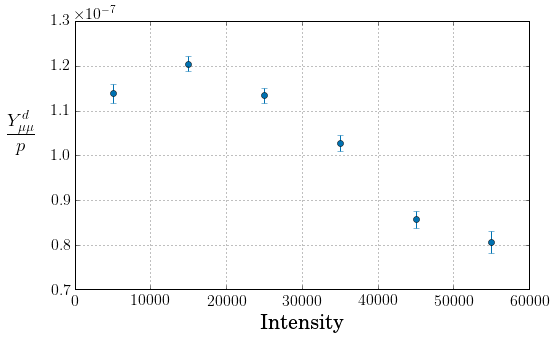

In [376]:
fig, ax = plt.subplots(1, figsize=(8, 5))
ax.errorbar(x, y, yerr=yerr, color=colors[0], fmt='o')
# Axis Labels
ax.grid()
ax.set_ylabel(r'$\frac{Y^d_{\mu\mu}}{p}$', rotation=0, fontsize=27)
ax.set_xlabel(r'Intensity', fontsize=20)
ax.yaxis.labelpad = 30
t = ax.yaxis.get_offset_text()
t.set_size(16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
fig.set_tight_layout(True)
fig.savefig('rate-dep.png')

In [377]:
cuts = []
cuts.append(pd.qcut(dimuon_set.xT,3))
cuts.append(pd.cut(dimuon_set.chamber_intensity,
            [0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000]))
int_xT_counts = dimuon_set.groupby(by=cuts).count()

In [378]:
colors = [(0.0, 0.4470588235294118, 0.6980392156862745),
          (0.0, 0.6196078431372549, 0.45098039215686275),
          (0.8352941176470589, 0.3686274509803922, 0.0)]

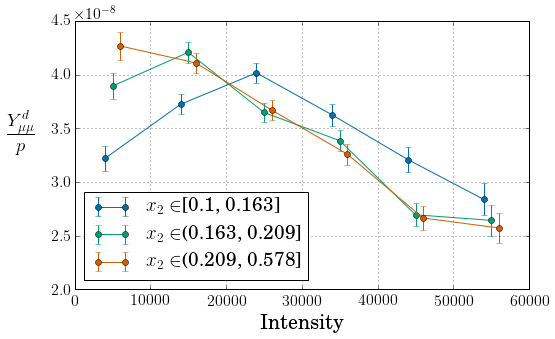

In [379]:
fig, ax = plt.subplots(1, figsize=(8, 5))

i = 0
offset = -1000
for index in int_xT_counts.xT.index.levels[0]:
    x = [5000,15000,25000,35000,45000,55000]
    y = (int_xT_counts.ix[index].chisq_dimuon/nim_trig_int.trigger_intensity).values[:6]
    yerr = (np.sqrt(int_xT_counts.ix[index].chisq_dimuon.values)/nim_trig_int.trigger_intensity).values[:6]
    ax.errorbar(np.add(x,offset+i*1000), y, yerr=yerr, color=colors[i], fmt='-o', label=(r'$x_2\in$%s'%index))
    i += 1
    
# Axis Labels
ax.grid()
ax.set_ylabel(r'$\frac{Y^d_{\mu\mu}}{p}$', rotation=0, fontsize=27)
ax.set_xlabel(r'Intensity', fontsize=20)
ax.legend(loc='best')
ax.yaxis.labelpad = 30
t = ax.yaxis.get_offset_text()
t.set_size(16)
plt.setp(ax.get_yticklabels(), fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=16)
fig.set_tight_layout(True)
fig.show()
fig.savefig('rate-dep-x2.png')